In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns
from patsy import dmatrix, build_design_matrices
from scipy.stats import multivariate_normal
from scipy.stats import norm
from itertools import cycle
import re
from scipy.linalg import pinv
from scipy.integrate import simpson

sns.set_theme()
sns.set_context("notebook")

In [16]:
dtype_dict = {
    'Date': 'str',
    'FarmName_Pseudo': 'str',
    'SE_Number': 'str',
    'Age': 'Int64',
    'BreedName': 'str',
    'DailyYield': 'float',
    'PreviousDailyYield': 'float',
    'DailyYieldChange': 'float',
    'DaysInMilk': 'Int64',
    'YearSeason': 'str',
    'LactationNumber': 'Int64',
    'ExpectedYield': 'float',
    'NormalizedDailyYield': 'float',
    'NormalizedDailyYieldChange': 'float',
    'HeatStress': 'Int64',
    'Temp15Threshold': 'Int64',
    'HW': 'Int64',
    'cum_HW': 'Int64',
    'MeanTemperature': 'float',
    'MeanTHI_adj': 'float',
    'HeatLoad': 'float',
    'CumulativeHeatLoad': 'float',
}

milk_data = pd.read_csv('../Data/MergedData/HeatApproachCleanedYieldDataTestQuantile.csv', dtype=dtype_dict)
milk_data['Date'] = pd.to_datetime(milk_data['Date'], format='%Y-%m-%d')
milk_data.head(-5)

Date FarmName_Pseudo         SE_Number  Age   BreedName  \
0      2022-11-25        5b581702  SE-27c3257a-1492  773  DairyCross   
1      2022-11-26        5b581702  SE-27c3257a-1492  774  DairyCross   
2      2022-11-27        5b581702  SE-27c3257a-1492  775  DairyCross   
3      2022-11-28        5b581702  SE-27c3257a-1492  776  DairyCross   
4      2022-11-29        5b581702  SE-27c3257a-1492  777  DairyCross   
...           ...             ...               ...  ...         ...   
289898 2023-04-07        ad0a39f5  SE-ad0a39f5-2805  869         SLB   
289899 2023-04-08        ad0a39f5  SE-ad0a39f5-2805  870         SLB   
289900 2023-04-09        ad0a39f5  SE-ad0a39f5-2805  871         SLB   
289901 2023-04-10        ad0a39f5  SE-ad0a39f5-2805  872         SLB   
289902 2023-04-11        ad0a39f5  SE-ad0a39f5-2805  873         SLB   

        LactationNumber  DaysInMilk YearSeason  DailyYield  \
0                     1          32     202204       39.60   
1                     1          33     202204       22.19   
2                     1          34     202204       29.40   
3                     1          35     202204       27.03   
4                     1          36     202204       26.88   
...                 ...         ...        ...         ...   
289898                1         156     202302       47.71   
289899                1         157     202302       50.91   
289900                1         158     202302       46.53   
289901                1         159     202302       37.26   
289902                1         160     202302       54.39   

        PreviousDailyYield  ...  NormalizedDailyYieldChange  Residuals  \
0                      NaN  ...                         NaN   6.630949   
1                    39.60  ...                   -0.528276 -10.766278   
2                    22.19  ...                    0.218860  -3.543505   
3                    29.40  ...                   -0.071969  -5.900733   
4                    27.03  ...                   -0.004557  -6.037960   
...                    ...  ...                         ...        ...   
289898               45.67  ...                    0.043832   1.169136   
289899               47.71  ...                    0.069170   4.647419   
289900               50.91  ...                   -0.094332   0.098447   
289901               46.53  ...                   -0.198830  -9.362667   
289902               37.26  ...                    0.369204   7.992841   

        HeatStress  Temp15Threshold  HW  cum_HW  MeanTemperature  MeanTHI_adj  \
0                0                0   0       0         1.500000    37.235887   
1                0                0   0       0         1.450000    36.869260   
2                0                0   0       0        -0.150000    30.678900   
3                0                0   0       0         2.700000    37.007500   
4                0                0   0       0         2.850000    38.536020   
...            ...              ...  ..     ...              ...          ...   
289898           0                0   0       0         1.366667    35.780160   
289899           0                0   0       0         4.700000    43.447053   
289900           0                0   0       0         4.233333    44.991420   
289901           0                0   0       0         6.066667    45.551007   
289902           0                0   0       0         6.566667    44.454140   

         HeatLoad  CumulativeHeatLoad  
0      -23.764113                 0.0  
1      -24.130740                 0.0  
2      -30.321100                 0.0  
3      -23.992500                 0.0  
4      -22.463980                 0.0  
...           ...                 ...  
289898 -25.219840                 0.0  
289899 -17.552947                 0.0  
289900 -16.008580                 0.0  
289901 -15.448993                 0.0  
289902 -16.545860                 0.0  

[289903 rows x 23 columns]

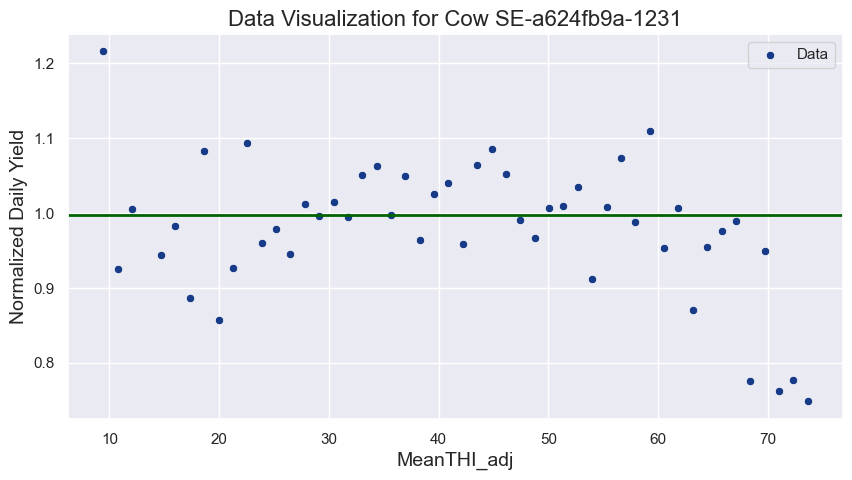

In [17]:
# Filter data for the specific farm
farm_id = 'a624fb9a'
farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm_id]

# Get unique cows (SE_Number) in the farm
unique_cows = farm_data['SE_Number'].unique()

# Initialize an empty DataFrame to store results
results_df = pd.DataFrame(columns=['FarmName_Pseudo', 'SE_Number', 'THIMilkProduction [%]'])

# Select a random cow for plotting (you can set seed for reproducibility)
np.random.seed(42)  # For reproducibility
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Data Preparation
    N = 50  # Number of bins
    input_feature_label = 'MeanTHI_adj'
    
    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N) 
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Calculate mean_yield for this cow
    mean_yield = cow_data['NormalizedDailyYield'].mean()

    # Initial Visualization (for a random cow only)
    if se_number == random_cow:
        fig = plt.figure(figsize=(10, 5))
        ax = plt.subplot(111)
        scatter = sns.scatterplot(x=x, y=y, label='Data', color='#183B87', ax=ax)

        # Add horizontal line for the mean yield
        mean_yield = cow_data['NormalizedDailyYield'].mean()
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')
        
        plt.title(f"Data Visualization for Cow {se_number}", fontsize=16)
        plt.xlabel('MeanTHI_adj', fontsize=14)
        plt.ylabel('Normalized Daily Yield', fontsize=14)
        plt.show()

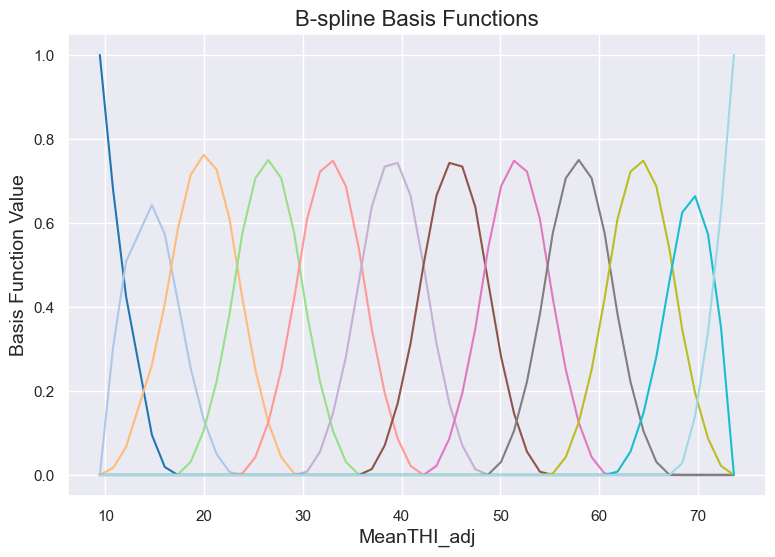

In [18]:
def Phi(a, knots, degree=3, spline_type='B'):
    lower_bound = min(a)
    upper_bound = max(a)
    
    # Adjust knots to ensure they are within the bounds
    knots = np.clip(knots, lower_bound, upper_bound)
    
    if spline_type == 'B':
        B = dmatrix(f"bs(x, knots=knots, degree={degree}, include_intercept=True) - 1", {"x": a, 'knots': knots})
    elif spline_type == 'CR':
        B = dmatrix(f"cr(x, knots=knots, constraints='center')- 1", {"x": a, 'knots': knots})
    elif spline_type == 'CC':
        B = dmatrix(f"cc(x, knots=knots, constraints='center') - 1", {"x": a, 'knots': knots})
    else:
        raise ValueError(f"{spline_type} is not a valid type, choose from 'B', 'CC' or 'CR'")
    return B


for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]
    
    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N) 
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Block 2: B-Spline Basis Functions
    degree_spline = 2  # Change the order of the polynomial here
    num_qs = 10
    knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs+1)[1:-1])

    B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

    # Plot Basis Functions (for the random cow)
    if se_number == random_cow:
        color_map = plt.colormaps.get_cmap('tab20')
        colors = color_map(np.linspace(0, 1, B.shape[1]))

        fig = plt.figure(figsize=(9, 6))
        ax = plt.subplot(111)
        for i in range(B.shape[1]):
            c = colors[i]
            ax.plot(x, B[:, i], c=c, label=f'Basis {i + 1}')

        plt.title('B-spline Basis Functions', fontsize=16)
        plt.xlabel('MeanTHI_adj', fontsize=14)
        plt.ylabel('Basis Function Value', fontsize=14)
        plt.show()

Mean squared error for Cow SE-a624fb9a-1231 is 0.0033


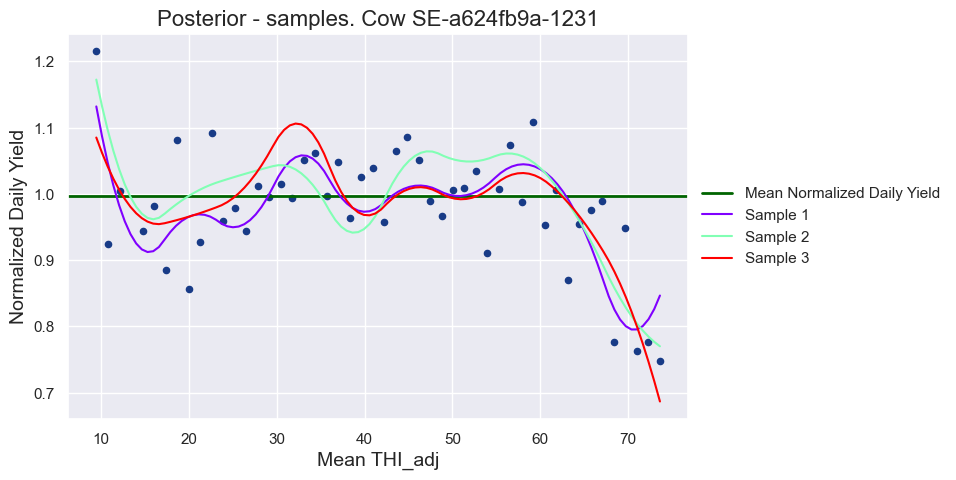

In [19]:
# Seed for reproducibility
np.random.seed(42)

# Select a random cow for plotting
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N)
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Check if there are enough data points
    if len(y) < 2:  # If fewer than 2 data points, skip this cow
        print(f"Skipping Cow {se_number} due to insufficient data points.")
        continue

    # Block 2: B-Spline Basis Functions
    degree_spline = 2  # Change the order of the polynomial here
    num_qs = 10
    knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs + 1)[1:-1])

    B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

    # Block 3: Bayesian Linear Regression - GAM
    # Calculate empirical priors from the data
    D = B.shape[1]
    m0 = np.linalg.lstsq(B, y, rcond=None)[0]  # Least-squares estimate as prior mean
    S0 = np.cov(B.T)  # Covariance of the design matrix as prior covariance

    if np.any(np.isnan(S0)) or np.any(np.isinf(S0)):
        print(f"Skipping Cow {se_number} due to invalid covariance matrix.")
        continue

    beta = 1 / np.var(y)

    if np.isinf(beta) or np.isnan(beta):
        print(f"Skipping Cow {se_number} due to invalid beta value.")
        continue

    # Compute the posterior distribution with new priors
    SN = pinv(pinv(S0) + beta * B.T @ B)

    # Adding a small regularization term to ensure positive semi-definiteness
    regularization_term = 1e-6 * np.eye(D)
    SN += regularization_term

    mN = SN @ (pinv(S0) @ m0 + beta * B.T @ y)

    # Print MSE for this cow
    mse = np.mean((y - B @ mN) ** 2)

    # Plot the posterior for the random cow
    if se_number == random_cow:
        print(f"Mean squared error for Cow {se_number} is {mse:.4f}")
        samples = 3
        seed = 100
        ws = multivariate_normal(mean=mN, cov=SN, allow_singular=True).rvs(samples, random_state=seed)

        n = 100  # number of grid-points
        xs = np.linspace(x.min(), x.max(), n)
        new_data = {'x': xs}

        B_star = build_design_matrices([B.design_info], new_data)[0]
        B_star = np.asarray(B_star)

        # Compute corresponding values f(x*)
        fs = B_star @ ws.T

        # Plot the samples
        fig = plt.figure(figsize=(10, 5))
        ax = plt.subplot(111)
        plt.scatter(x, y, color='#183B87', zorder=1, s=20)

        # Add horizontal line for the mean yield
        mean_yield = cow_data['NormalizedDailyYield'].mean()
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')

        color = cycle(cm.rainbow(np.linspace(0, 1, samples)))
        for i in range(ws.shape[0]):
            c = next(color)
            line, = ax.plot(xs, fs[:, i], c=c, label=f"Sample {i+1}")

        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0)  # Set legend transparency

        plt.title(f'Posterior - samples. Cow {se_number}', fontsize=16)
        plt.xlabel(re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label), fontsize=14)
        plt.ylabel('Normalized Daily Yield', fontsize=14)  # Updated ylabel

        plt.show()

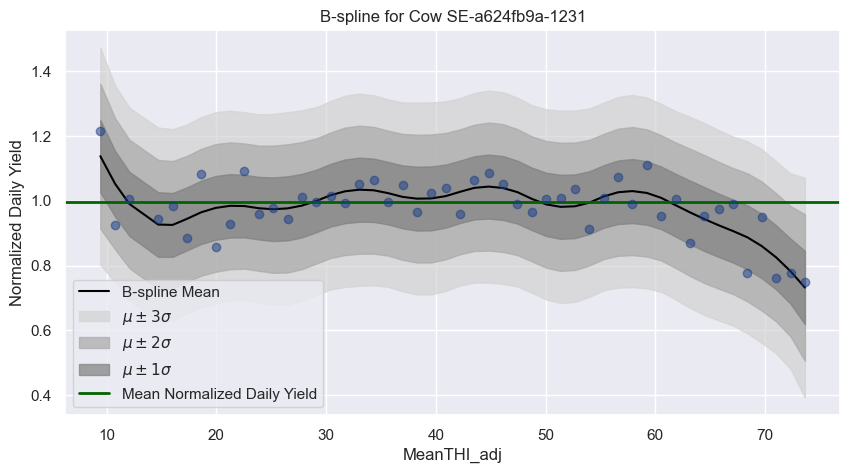

FarmName_Pseudo         SE_Number  THIMilkProduction [%]  \
0          a624fb9a  SE-30dc5787-1389              -7.209656   
1          a624fb9a  SE-a624fb9a-1162              -1.697404   
2          a624fb9a  SE-a624fb9a-1199              -7.039613   
3          a624fb9a  SE-a624fb9a-1200              -5.893083   
4          a624fb9a  SE-a624fb9a-1257              -7.886912   
..              ...               ...                    ...   
117        a624fb9a  SE-a624fb9a-1471              -3.894191   
118        a624fb9a  SE-a624fb9a-1508              -6.406279   
119        a624fb9a  SE-a624fb9a-1517              -4.700343   
120        a624fb9a  SE-a624fb9a-1531              -6.563145   
121        a624fb9a  SE-a624fb9a-1542              -3.146411   

     THIMilkProduction  
0            -0.072097  
1            -0.016974  
2            -0.070396  
3            -0.058931  
4            -0.078869  
..                 ...  
117          -0.038942  
118          -0.064063  
119          -0.047003  
120          -0.065631  
121          -0.031464  

[122 rows x 4 columns]

In [20]:
# Seed for reproducibility
np.random.seed(42)

# Initialize an empty DataFrame to store results
results_df = pd.DataFrame(columns=['FarmName_Pseudo', 'SE_Number', 'THIMilkProduction [%]'])

# Select a random cow for plotting
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N)
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Convert bin_midpoints to numeric for comparison
    x = mean_yields[input_feature_label].values.astype(float)
    y = mean_yields.NormalizedDailyYield.values

    # Ensure sufficient data points
    if len(y) < 2:  # Ensure at least 2 data points
        print(f"Skipping Cow {se_number} due to insufficient data points.")
        continue

    try:
        # B-Spline Basis Functions (Primary Method)
        degree_spline = 2  # Change the order of the polynomial here
        max_knots = min(len(y) - 1, 10)
        num_qs = max_knots
        knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs + 1)[1:-1])
        B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

        # Check if B has more rows than columns
        if B.shape[0] < B.shape[1]:
            raise ValueError(f"Incompatible dimensions (B: {B.shape})")

        # Step 1: Calculate empirical priors from the correct data
        m0 = np.linalg.lstsq(B, y, rcond=None)[0]  # Least-squares estimate as prior mean
        S0 = np.cov(B.T)  # Covariance of the design matrix as prior covariance

        if np.any(np.isnan(S0)) or np.any(np.isinf(S0)):
            print(f"Skipping Cow {se_number} due to invalid covariance matrix.")
            continue

        # Bayesian Linear Regression
        beta = 1 / np.var(y)
        lambda_ridge = 0.1
        SN = np.linalg.pinv(np.linalg.pinv(S0) + beta * B.T @ B + lambda_ridge * np.eye(B.shape[1]))
        mN = SN @ (np.linalg.pinv(S0) @ m0 + beta * B.T @ y)

        # Make predictions
        mstar_mle = B @ mN
        Sstar_mle = B @ SN @ B.T + beta ** (-1) * np.eye(B.shape[0])
        stdpred_mle = np.sqrt(np.diag(Sstar_mle))
        model_type = 'B-spline'

    except Exception as e:
        print(f"Skipping Cow {se_number} due to incompatible dimensions or another error: {str(e)}")
        continue

    # Filter x and corresponding mstar_mle for values >= 61
    filtered_indices = x >= 61  # Only include THI values >= 61
    if np.sum(filtered_indices) < 2:
        print(f"Skipping Cow {se_number} due to insufficient data points after filtering.")
        continue

    filtered_xs = x[filtered_indices]
    filtered_mstar_mle = mstar_mle[filtered_indices]

    # Integration to calculate THIMilkProduction
    above_mean = np.maximum(filtered_mstar_mle - mean_yield, 0)
    below_mean = np.maximum(mean_yield - filtered_mstar_mle, 0)

    # Integrate over the filtered x values
    area_above_mean = simpson(above_mean, x=filtered_xs)
    area_below_mean = simpson(below_mean, x=filtered_xs)

    # Calculate the net area (above - below)
    net_area = area_above_mean - area_below_mean
    range_mean_temperature = filtered_xs[-1] - filtered_xs[0]
    net_effect_per_unit = net_area / range_mean_temperature

    # Express the net effect as a percentage of the mean yield
    net_effect_percentage = (net_effect_per_unit / mean_yield) * 100

    # Store results in the DataFrame
    new_result = pd.DataFrame([{
        'FarmName_Pseudo': farm_id,
        'SE_Number': se_number,
        'THIMilkProduction [%]': net_effect_percentage
    }])

    if results_df.empty:
        results_df = new_result
    else:
        results_df = pd.concat([results_df, new_result], ignore_index=True)

    # Plot for the randomly selected cow
    if se_number == random_cow:
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(x, mstar_mle, 'black', label=f'{model_type} Mean')
        ax.fill_between(x, mstar_mle + 3*stdpred_mle, mstar_mle - 3*stdpred_mle, color='lightgray', alpha=0.7, label=r'$\mu \pm 3\sigma$')
        ax.fill_between(x, mstar_mle + 2*stdpred_mle, mstar_mle - 2*stdpred_mle, color='darkgray', alpha=0.7, label=r'$\mu \pm 2\sigma$')
        ax.fill_between(x, mstar_mle + 1*stdpred_mle, mstar_mle - 1*stdpred_mle, color='gray', alpha=0.7, label=r'$\mu \pm 1\sigma$')
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')
        plt.scatter(x, y, c='#183B87', zorder=4, alpha=0.5)
        ax.legend(loc='best')
        plt.title(f'{model_type} for Cow {se_number}')
        plt.xlabel(f'{input_feature_label}')
        plt.ylabel('Normalized Daily Yield')
        plt.show()

# Display the results
results_df['THIMilkProduction'] = results_df['THIMilkProduction [%]'] / 100
results_df

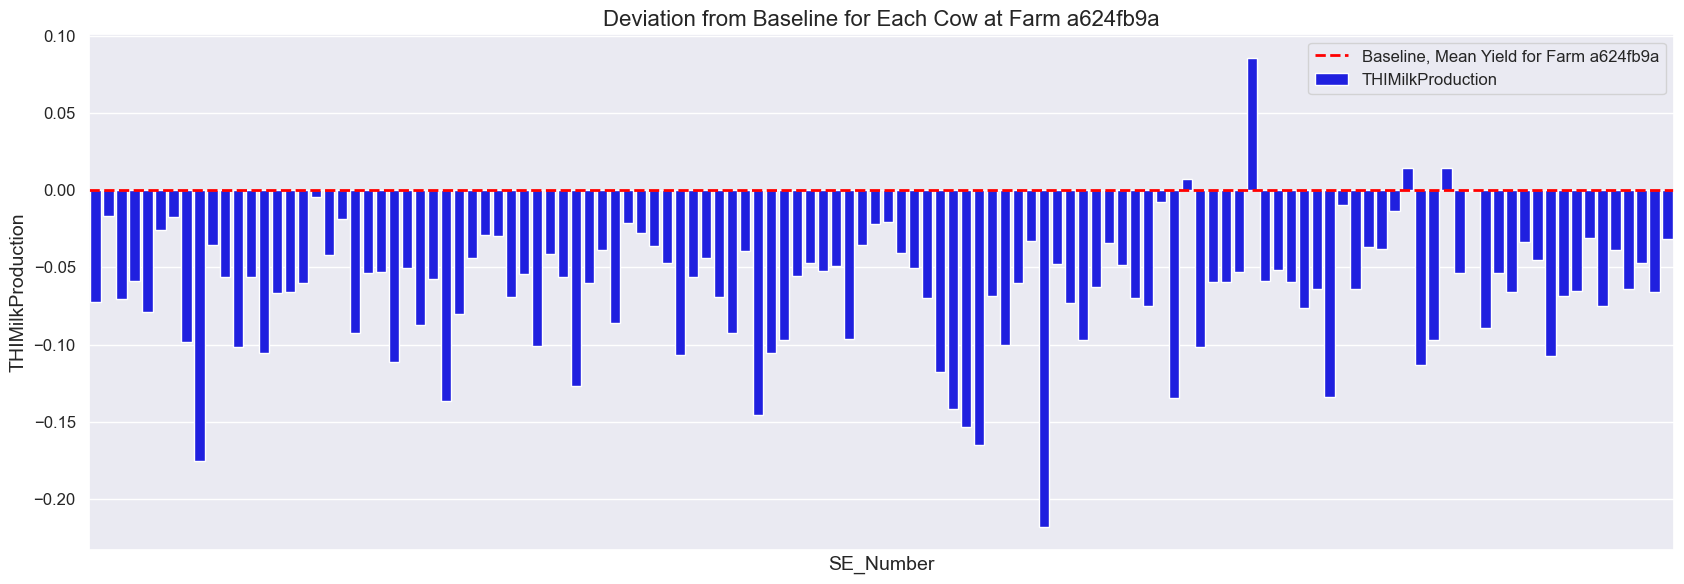

In [21]:
# Create the bar plot
plt.figure(figsize=(17, 6))
sns.barplot(x=results_df.index, y=results_df['THIMilkProduction'], color='blue', label='THIMilkProduction')

# Add a baseline line set to 0
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')

# Formatting the plot
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('THIMilkProduction', fontsize=14)
plt.title(f'Deviation from Baseline for Each Cow at Farm {farm_id}', fontsize=16)

# Optionally, remove x-axis labels if too many entries
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.legend(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

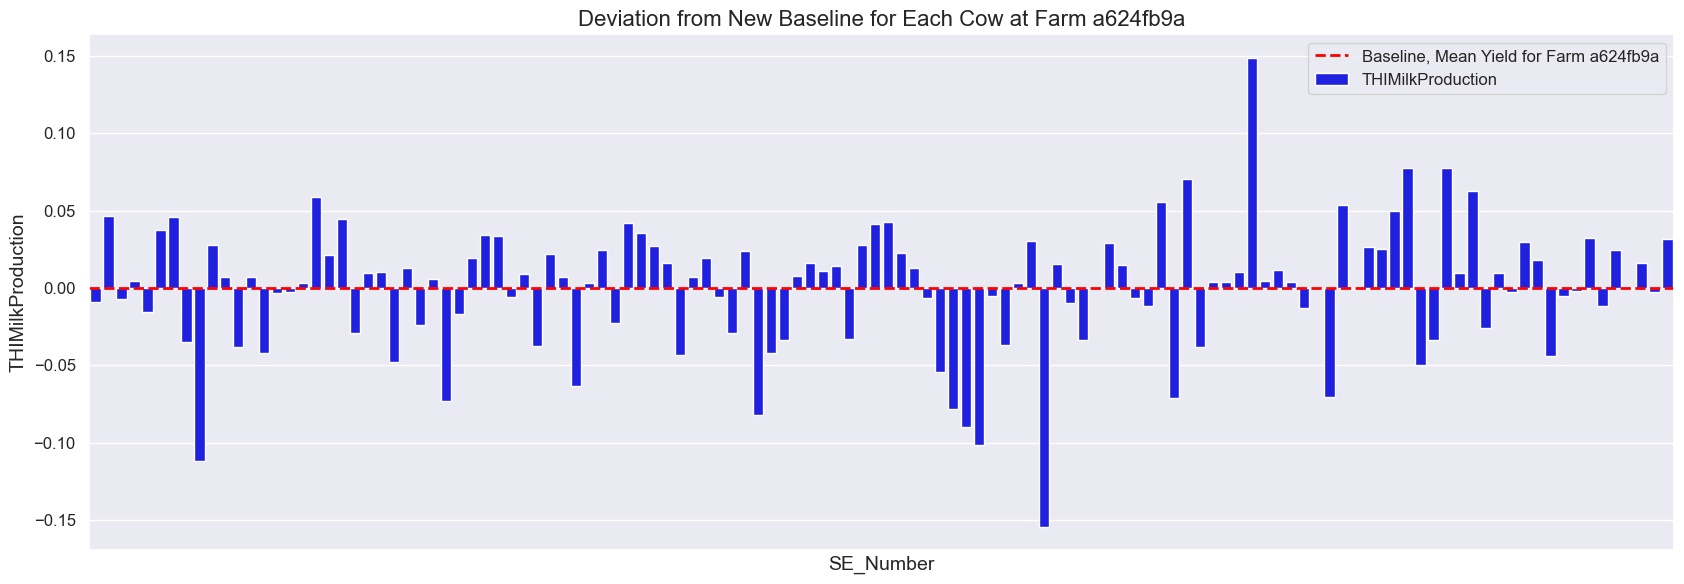

In [22]:
# New baseline value
new_baseline = results_df['THIMilkProduction'].mean()

# Adjust the THIMilkProduction to start from the new baseline
results_df['AdjustedTHIMilkProduction'] = results_df['THIMilkProduction'] - new_baseline

# Create the bar plot
plt.figure(figsize=(17, 6))
sns.barplot(x=results_df.index, y=results_df['AdjustedTHIMilkProduction'], color='blue', label='THIMilkProduction')

# Add a baseline line set to 0 (now adjusted to the new baseline)
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')

# Formatting the plot
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('THIMilkProduction', fontsize=14)
plt.title(f'Deviation from New Baseline for Each Cow at Farm {farm_id}', fontsize=16)

# Optionally, remove x-axis labels if too many entries
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.legend(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

# Farm 5c06d92d

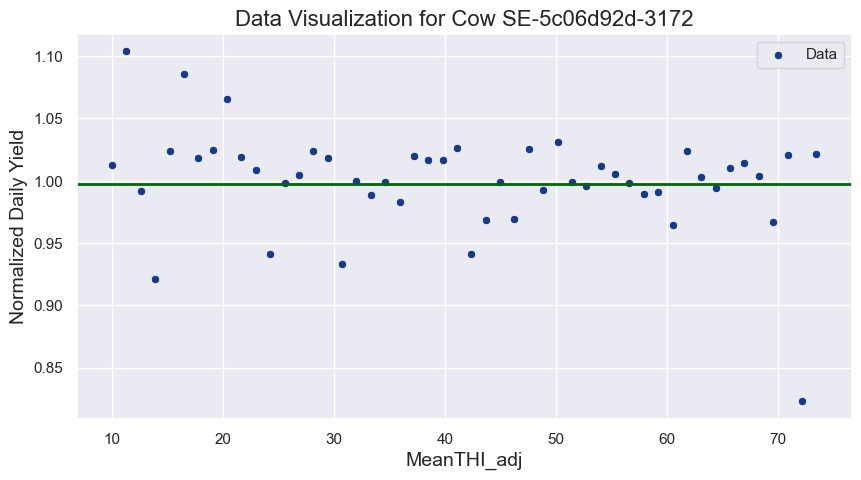

In [23]:
# Filter data for the specific farm
farm_id = '5c06d92d'
farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm_id]

# Get unique cows (SE_Number) in the farm
unique_cows = farm_data['SE_Number'].unique()

# Select a random cow for plotting (you can set seed for reproducibility)
np.random.seed(42)  # For reproducibility
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Data Preparation
    N = 50  # Number of bins
    input_feature_label = 'MeanTHI_adj'
    
    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N) 
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Calculate mean_yield for this cow
    mean_yield = cow_data['NormalizedDailyYield'].mean()

    # Initial Visualization (for a random cow only)
    if se_number == random_cow:
        fig = plt.figure(figsize=(10, 5))
        ax = plt.subplot(111)
        scatter = sns.scatterplot(x=x, y=y, label='Data', color='#183B87', ax=ax)

        # Add horizontal line for the mean yield
        mean_yield = cow_data['NormalizedDailyYield'].mean()
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')
        
        plt.title(f"Data Visualization for Cow {se_number}", fontsize=16)
        plt.xlabel('MeanTHI_adj', fontsize=14)
        plt.ylabel('Normalized Daily Yield', fontsize=14)
        plt.show()

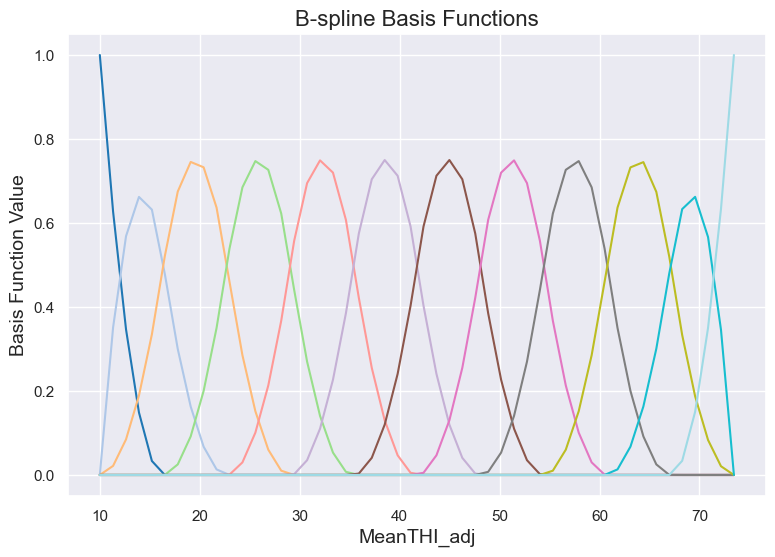

In [24]:
def Phi(a, knots, degree=3, spline_type='B'):
    lower_bound = min(a)
    upper_bound = max(a)
    
    # Adjust knots to ensure they are within the bounds
    knots = np.clip(knots, lower_bound, upper_bound)
    
    if spline_type == 'B':
        B = dmatrix(f"bs(x, knots=knots, degree={degree}, include_intercept=True) - 1", {"x": a, 'knots': knots})
    elif spline_type == 'CR':
        B = dmatrix(f"cr(x, knots=knots, constraints='center')- 1", {"x": a, 'knots': knots})
    elif spline_type == 'CC':
        B = dmatrix(f"cc(x, knots=knots, constraints='center') - 1", {"x": a, 'knots': knots})
    else:
        raise ValueError(f"{spline_type} is not a valid type, choose from 'B', 'CC' or 'CR'")
    return B


for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]
    
    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N) 
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Block 2: B-Spline Basis Functions
    degree_spline = 2  # Change the order of the polynomial here
    num_qs = 10
    knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs+1)[1:-1])

    B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

    # Plot Basis Functions (for the random cow)
    if se_number == random_cow:
        color_map = plt.colormaps.get_cmap('tab20')
        colors = color_map(np.linspace(0, 1, B.shape[1]))

        fig = plt.figure(figsize=(9, 6))
        ax = plt.subplot(111)
        for i in range(B.shape[1]):
            c = colors[i]
            ax.plot(x, B[:, i], c=c, label=f'Basis {i + 1}')

        plt.title('B-spline Basis Functions', fontsize=16)
        plt.xlabel('MeanTHI_adj', fontsize=14)
        plt.ylabel('Basis Function Value', fontsize=14)
        plt.show()

Mean squared error for Cow SE-5c06d92d-3172 is 0.0013


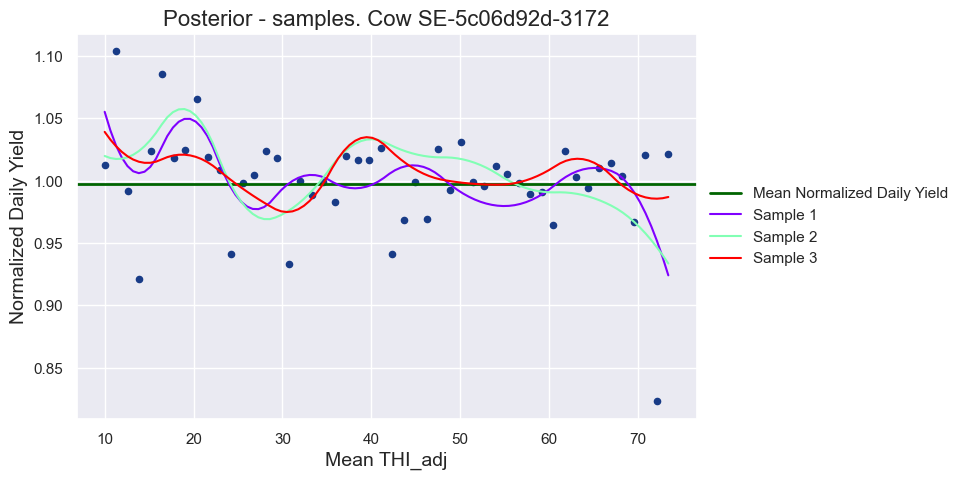

In [25]:
# Seed for reproducibility
np.random.seed(42)

# Select a random cow for plotting
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N)
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Check if there are enough data points
    if len(y) < 2:  # If fewer than 2 data points, skip this cow
        print(f"Skipping Cow {se_number} due to insufficient data points.")
        continue

    # Block 2: B-Spline Basis Functions
    degree_spline = 2  # Change the order of the polynomial here
    num_qs = 10
    knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs + 1)[1:-1])

    B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

    # Block 3: Bayesian Linear Regression - GAM
    # Calculate empirical priors from the data
    D = B.shape[1]
    m0 = np.linalg.lstsq(B, y, rcond=None)[0]  # Least-squares estimate as prior mean
    S0 = np.cov(B.T)  # Covariance of the design matrix as prior covariance

    if np.any(np.isnan(S0)) or np.any(np.isinf(S0)):
        print(f"Skipping Cow {se_number} due to invalid covariance matrix.")
        continue

    beta = 1 / np.var(y)

    if np.isinf(beta) or np.isnan(beta):
        print(f"Skipping Cow {se_number} due to invalid beta value.")
        continue

    # Compute the posterior distribution with new priors
    SN = pinv(pinv(S0) + beta * B.T @ B)

    # Adding a small regularization term to ensure positive semi-definiteness
    regularization_term = 1e-6 * np.eye(D)
    SN += regularization_term

    mN = SN @ (pinv(S0) @ m0 + beta * B.T @ y)

    # Print MSE for this cow
    mse = np.mean((y - B @ mN) ** 2)

    # Plot the posterior for the random cow
    if se_number == random_cow:
        print(f"Mean squared error for Cow {se_number} is {mse:.4f}")
        samples = 3
        seed = 100
        ws = multivariate_normal(mean=mN, cov=SN, allow_singular=True).rvs(samples, random_state=seed)

        n = 100  # number of grid-points
        xs = np.linspace(x.min(), x.max(), n)
        new_data = {'x': xs}

        B_star = build_design_matrices([B.design_info], new_data)[0]
        B_star = np.asarray(B_star)

        # Compute corresponding values f(x*)
        fs = B_star @ ws.T

        # Plot the samples
        fig = plt.figure(figsize=(10, 5))
        ax = plt.subplot(111)
        plt.scatter(x, y, color='#183B87', zorder=1, s=20)

        # Add horizontal line for the mean yield
        mean_yield = cow_data['NormalizedDailyYield'].mean()
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')

        color = cycle(cm.rainbow(np.linspace(0, 1, samples)))
        for i in range(ws.shape[0]):
            c = next(color)
            line, = ax.plot(xs, fs[:, i], c=c, label=f"Sample {i+1}")

        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0)  # Set legend transparency

        plt.title(f'Posterior - samples. Cow {se_number}', fontsize=16)
        plt.xlabel(re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label), fontsize=14)
        plt.ylabel('Normalized Daily Yield', fontsize=14)  # Updated ylabel

        plt.show()

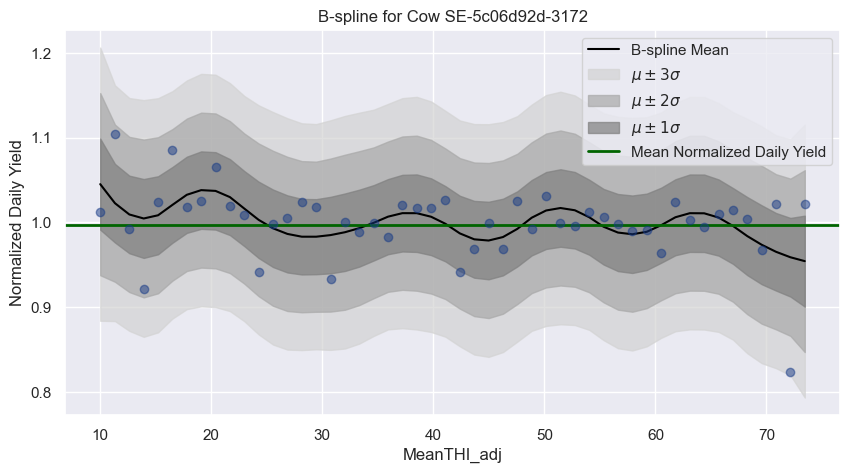

Skipping Cow SE-5c06d92d-2990 due to insufficient data points after filtering.


FarmName_Pseudo         SE_Number  THIMilkProduction [%]  \
0          5c06d92d  SE-5c06d92d-2055              -2.800484   
1          5c06d92d  SE-5c06d92d-2424               0.617917   
2          5c06d92d  SE-5c06d92d-2457              -7.432399   
3          5c06d92d  SE-5c06d92d-2470              -2.598223   
4          5c06d92d  SE-5c06d92d-2478              -0.403822   
..              ...               ...                    ...   
350        5c06d92d  SE-5c06d92d-3562              -1.465985   
351        5c06d92d  SE-5c06d92d-3565               1.593291   
352        5c06d92d  SE-5c06d92d-3573               1.442480   
353        5c06d92d  SE-5c06d92d-3580              -0.006016   
354        5c06d92d  SE-5c06d92d-3591               1.172761   

     THIMilkProduction  
0            -0.028005  
1             0.006179  
2            -0.074324  
3            -0.025982  
4            -0.004038  
..                 ...  
350          -0.014660  
351           0.015933  
352           0.014425  
353          -0.000060  
354           0.011728  

[355 rows x 4 columns]

In [26]:
# Seed for reproducibility
np.random.seed(42)

# Initialize an empty DataFrame to store results
results_df = pd.DataFrame(columns=['FarmName_Pseudo', 'SE_Number', 'THIMilkProduction [%]'])

# Select a random cow for plotting
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N)
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Convert bin_midpoints to numeric for comparison
    x = mean_yields[input_feature_label].values.astype(float)
    y = mean_yields.NormalizedDailyYield.values

    # Ensure sufficient data points
    if len(y) < 2:  # Ensure at least 2 data points
        print(f"Skipping Cow {se_number} due to insufficient data points.")
        continue

    try:
        # B-Spline Basis Functions (Primary Method)
        degree_spline = 2  # Change the order of the polynomial here
        max_knots = min(len(y) - 1, 10)
        num_qs = max_knots
        knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs + 1)[1:-1])
        B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

        # Check if B has more rows than columns
        if B.shape[0] < B.shape[1]:
            raise ValueError(f"Incompatible dimensions (B: {B.shape})")

        # Step 1: Calculate empirical priors from the correct data
        m0 = np.linalg.lstsq(B, y, rcond=None)[0]  # Least-squares estimate as prior mean
        S0 = np.cov(B.T)  # Covariance of the design matrix as prior covariance

        if np.any(np.isnan(S0)) or np.any(np.isinf(S0)):
            print(f"Skipping Cow {se_number} due to invalid covariance matrix.")
            continue

        # Bayesian Linear Regression
        beta = 1 / np.var(y)
        lambda_ridge = 0.1
        SN = np.linalg.pinv(np.linalg.pinv(S0) + beta * B.T @ B + lambda_ridge * np.eye(B.shape[1]))
        mN = SN @ (np.linalg.pinv(S0) @ m0 + beta * B.T @ y)

        # Make predictions
        mstar_mle = B @ mN
        Sstar_mle = B @ SN @ B.T + beta ** (-1) * np.eye(B.shape[0])
        stdpred_mle = np.sqrt(np.diag(Sstar_mle))
        model_type = 'B-spline'

    except Exception as e:
        print(f"Skipping Cow {se_number} due to incompatible dimensions or another error: {str(e)}")
        continue

    # Filter x and corresponding mstar_mle for values >= 61
    filtered_indices = x >= 61  # Only include THI values >= 61
    if np.sum(filtered_indices) < 2:
        print(f"Skipping Cow {se_number} due to insufficient data points after filtering.")
        continue

    filtered_xs = x[filtered_indices]
    filtered_mstar_mle = mstar_mle[filtered_indices]

    # Integration to calculate THIMilkProduction
    above_mean = np.maximum(filtered_mstar_mle - mean_yield, 0)
    below_mean = np.maximum(mean_yield - filtered_mstar_mle, 0)

    # Integrate over the filtered x values
    area_above_mean = simpson(above_mean, x=filtered_xs)
    area_below_mean = simpson(below_mean, x=filtered_xs)

    # Calculate the net area (above - below)
    net_area = area_above_mean - area_below_mean
    range_mean_temperature = filtered_xs[-1] - filtered_xs[0]
    net_effect_per_unit = net_area / range_mean_temperature

    # Express the net effect as a percentage of the mean yield
    net_effect_percentage = (net_effect_per_unit / mean_yield) * 100

    # Store results in the DataFrame
    new_result = pd.DataFrame([{
        'FarmName_Pseudo': farm_id,
        'SE_Number': se_number,
        'THIMilkProduction [%]': net_effect_percentage
    }])

    if results_df.empty:
        results_df = new_result
    else:
        results_df = pd.concat([results_df, new_result], ignore_index=True)

    # Plot for the randomly selected cow
    if se_number == random_cow:
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(x, mstar_mle, 'black', label=f'{model_type} Mean')
        ax.fill_between(x, mstar_mle + 3*stdpred_mle, mstar_mle - 3*stdpred_mle, color='lightgray', alpha=0.7, label=r'$\mu \pm 3\sigma$')
        ax.fill_between(x, mstar_mle + 2*stdpred_mle, mstar_mle - 2*stdpred_mle, color='darkgray', alpha=0.7, label=r'$\mu \pm 2\sigma$')
        ax.fill_between(x, mstar_mle + 1*stdpred_mle, mstar_mle - 1*stdpred_mle, color='gray', alpha=0.7, label=r'$\mu \pm 1\sigma$')
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')
        plt.scatter(x, y, c='#183B87', zorder=4, alpha=0.5)
        ax.legend(loc='best')
        plt.title(f'{model_type} for Cow {se_number}')
        plt.xlabel(f'{input_feature_label}')
        plt.ylabel('Normalized Daily Yield')
        plt.show()

# Display the results
results_df['THIMilkProduction'] = results_df['THIMilkProduction [%]'] / 100
results_df

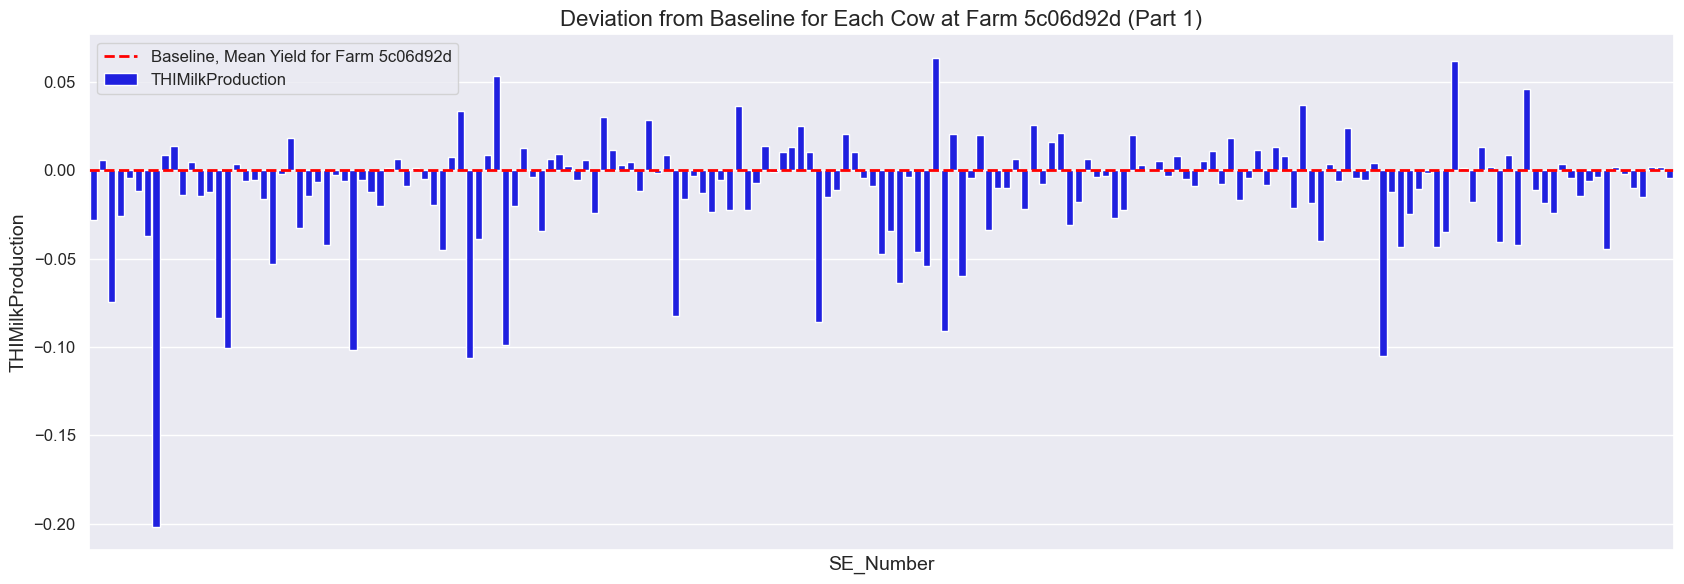

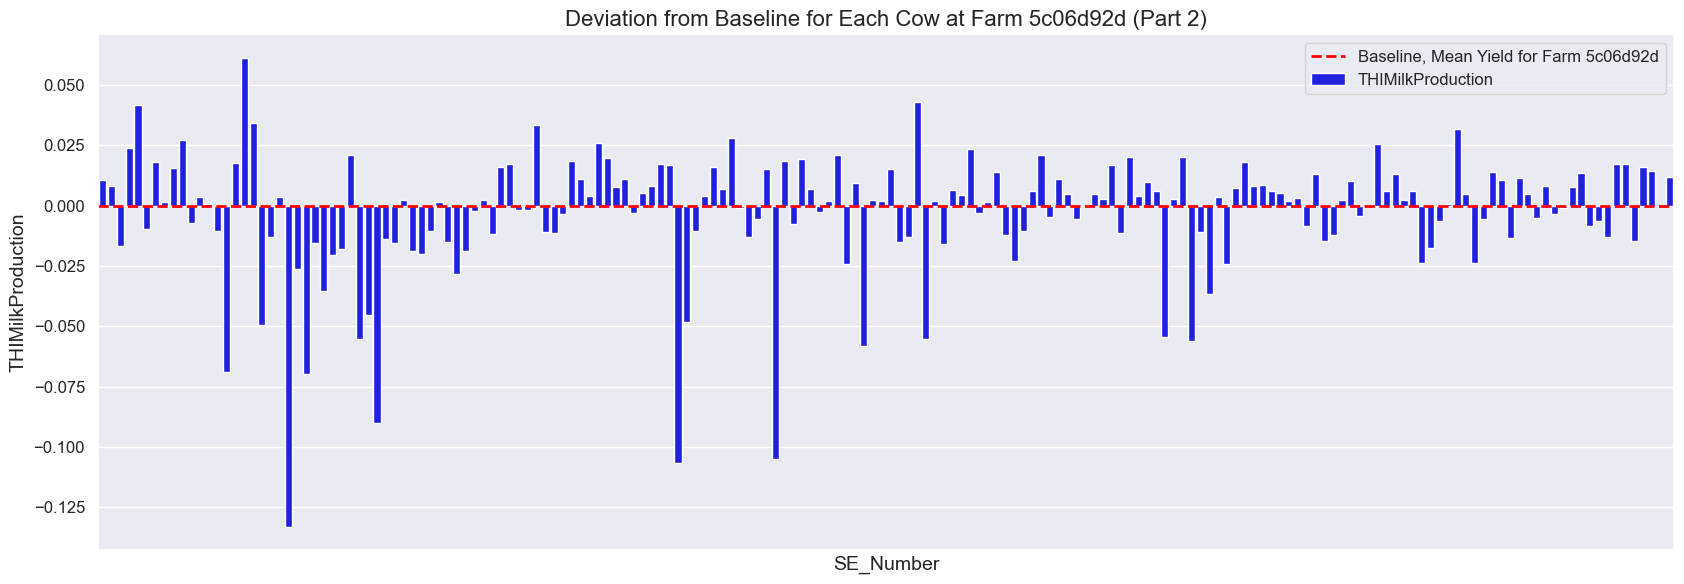

In [27]:
# Calculate the midpoint to split the data into two halves
midpoint = len(results_df) // 2

# Split the data into two halves
first_half = results_df.iloc[:midpoint]
second_half = results_df.iloc[midpoint:]

# Plotting for the first half
plt.figure(figsize=(17, 6))
sns.barplot(x=first_half.index, y=first_half['THIMilkProduction'], color='blue', label='THIMilkProduction')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('THIMilkProduction', fontsize=14)
plt.title(f'Deviation from Baseline for Each Cow at Farm {farm_id} (Part 1)', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Plotting for the second half
plt.figure(figsize=(17, 6))
sns.barplot(x=second_half.index, y=second_half['THIMilkProduction'], color='blue', label='THIMilkProduction')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('THIMilkProduction', fontsize=14)
plt.title(f'Deviation from Baseline for Each Cow at Farm {farm_id} (Part 2)', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

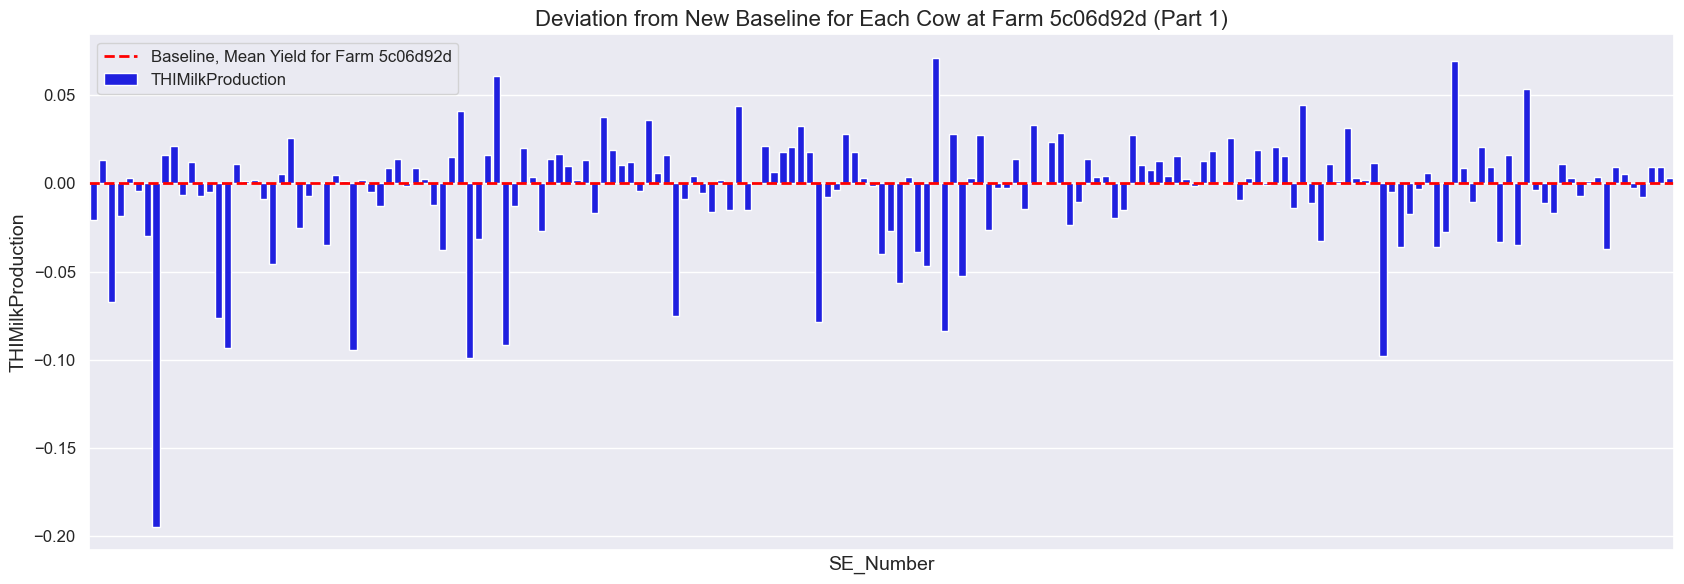

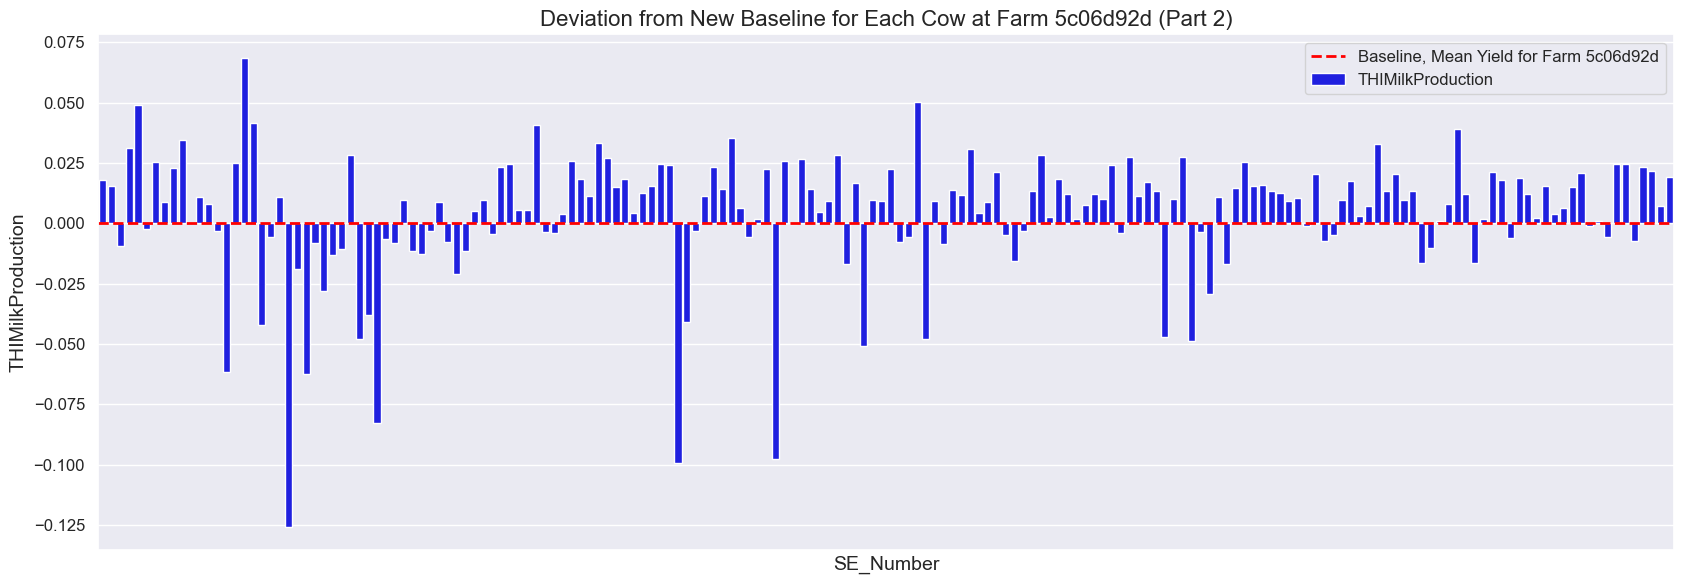

In [28]:
# New baseline value
new_baseline = results_df['THIMilkProduction'].mean()

# Adjust the THIMilkProduction to start from the new baseline
results_df['AdjustedTHIMilkProduction'] = results_df['THIMilkProduction'] - new_baseline

# Calculate the midpoint to split the data into two halves
midpoint = len(results_df) // 2

# Split the data into two halves
first_half = results_df.iloc[:midpoint]
second_half = results_df.iloc[midpoint:]

# Plotting for the first half
plt.figure(figsize=(17, 6))
sns.barplot(x=first_half.index, y=first_half['AdjustedTHIMilkProduction'], color='blue', label='THIMilkProduction')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('THIMilkProduction', fontsize=14)
plt.title(f'Deviation from New Baseline for Each Cow at Farm {farm_id} (Part 1)', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Plotting for the second half
plt.figure(figsize=(17, 6))
sns.barplot(x=second_half.index, y=second_half['AdjustedTHIMilkProduction'], color='blue', label='THIMilkProduction')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('THIMilkProduction', fontsize=14)
plt.title(f'Deviation from New Baseline for Each Cow at Farm {farm_id} (Part 2)', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

## Farm 752efd72
- herd not in P. Ask-Gullstrand's cleaned dataset

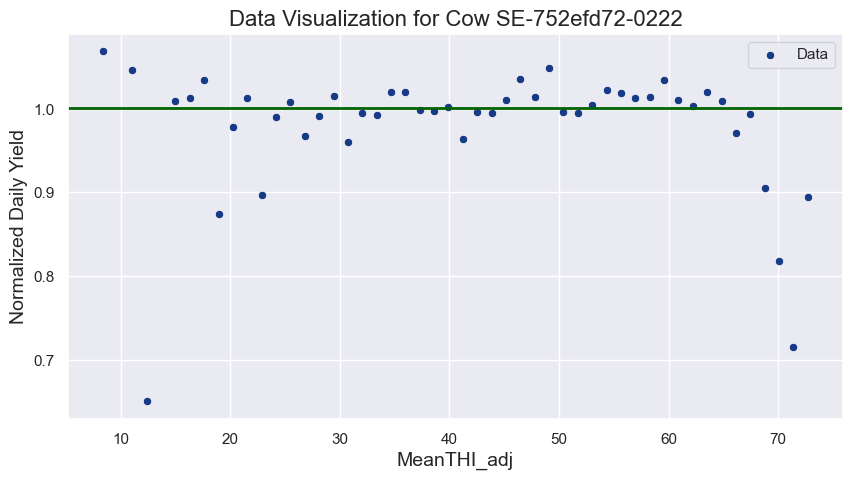

In [15]:
# Filter data for the specific farm
farm_id = '752efd72'
farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm_id]

# Get unique cows (SE_Number) in the farm
unique_cows = farm_data['SE_Number'].unique()

# Initialize an empty DataFrame to store results
results_df = pd.DataFrame(columns=['FarmName_Pseudo', 'SE_Number', 'CumHeatLoadMilkProduction [%]'])

# Select a random cow for plotting (you can set seed for reproducibility)
np.random.seed(42)  # For reproducibility
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Data Preparation
    N = 50  # Number of bins
    input_feature_label = 'MeanTHI_adj'
    
    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N) 
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Calculate mean_yield for this cow
    mean_yield = cow_data['NormalizedDailyYield'].mean()

    # Initial Visualization (for a random cow only)
    if se_number == random_cow:
        fig = plt.figure(figsize=(10, 5))
        ax = plt.subplot(111)
        scatter = sns.scatterplot(x=x, y=y, label='Data', color='#183B87', ax=ax)

        # Add horizontal line for the mean yield
        mean_yield = cow_data['NormalizedDailyYield'].mean()
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')
        
        plt.title(f"Data Visualization for Cow {se_number}", fontsize=16)
        plt.xlabel('MeanTHI_adj', fontsize=14)
        plt.ylabel('Normalized Daily Yield', fontsize=14)
        plt.show()

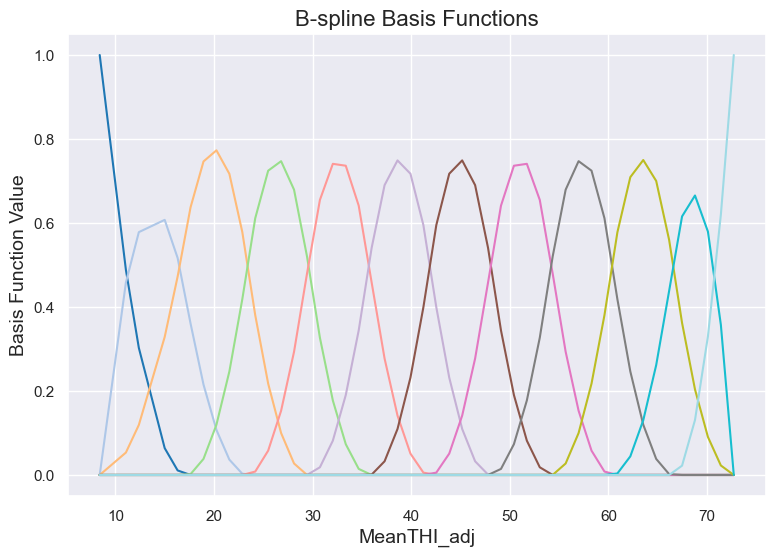

In [16]:
def Phi(a, knots, degree=3, spline_type='B'):
    lower_bound = min(a)
    upper_bound = max(a)
    
    # Adjust knots to ensure they are within the bounds
    knots = np.clip(knots, lower_bound, upper_bound)
    
    if spline_type == 'B':
        B = dmatrix(f"bs(x, knots=knots, degree={degree}, include_intercept=True) - 1", {"x": a, 'knots': knots})
    elif spline_type == 'CR':
        B = dmatrix(f"cr(x, knots=knots, constraints='center')- 1", {"x": a, 'knots': knots})
    elif spline_type == 'CC':
        B = dmatrix(f"cc(x, knots=knots, constraints='center') - 1", {"x": a, 'knots': knots})
    else:
        raise ValueError(f"{spline_type} is not a valid type, choose from 'B', 'CC' or 'CR'")
    return B


for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]
    
    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N) 
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Block 2: B-Spline Basis Functions
    degree_spline = 2  # Change the order of the polynomial here
    num_qs = 10
    knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs+1)[1:-1])

    B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

    # Plot Basis Functions (for the random cow)
    if se_number == random_cow:
        color_map = plt.colormaps.get_cmap('tab20')
        colors = color_map(np.linspace(0, 1, B.shape[1]))

        fig = plt.figure(figsize=(9, 6))
        ax = plt.subplot(111)
        for i in range(B.shape[1]):
            c = colors[i]
            ax.plot(x, B[:, i], c=c, label=f'Basis {i + 1}')

        plt.title('B-spline Basis Functions', fontsize=16)
        plt.xlabel('MeanTHI_adj', fontsize=14)
        plt.ylabel('Basis Function Value', fontsize=14)
        plt.show()

Mean squared error for Cow SE-752efd72-0222 is 0.0034


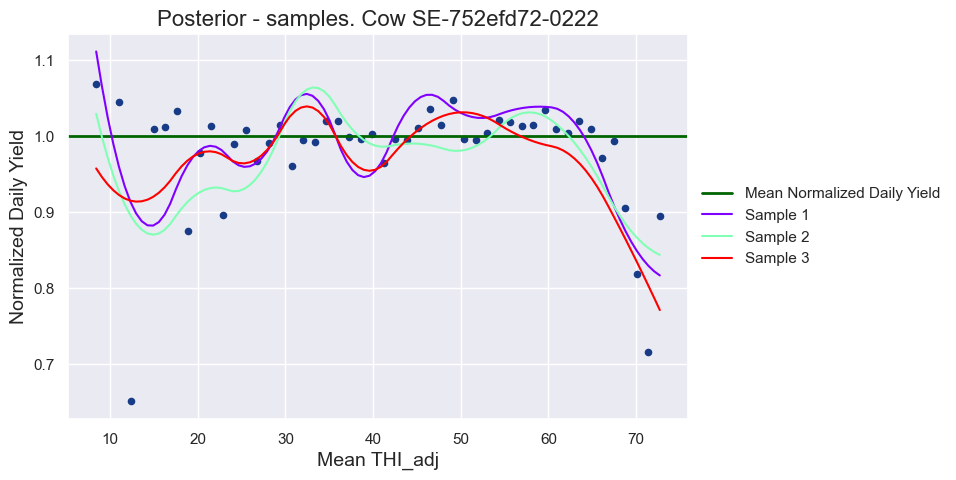

In [17]:
# Seed for reproducibility
np.random.seed(42)

# Select a random cow for plotting
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N)
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Check if there are enough data points
    if len(y) < 2:  # If fewer than 2 data points, skip this cow
        print(f"Skipping Cow {se_number} due to insufficient data points.")
        continue

    # Block 2: B-Spline Basis Functions
    degree_spline = 2  # Change the order of the polynomial here
    num_qs = 10
    knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs + 1)[1:-1])

    B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

    # Block 3: Bayesian Linear Regression - GAM
    # Calculate empirical priors from the data
    D = B.shape[1]
    m0 = np.linalg.lstsq(B, y, rcond=None)[0]  # Least-squares estimate as prior mean
    S0 = np.cov(B.T)  # Covariance of the design matrix as prior covariance

    if np.any(np.isnan(S0)) or np.any(np.isinf(S0)):
        print(f"Skipping Cow {se_number} due to invalid covariance matrix.")
        continue

    beta = 1 / np.var(y)

    if np.isinf(beta) or np.isnan(beta):
        print(f"Skipping Cow {se_number} due to invalid beta value.")
        continue

    # Compute the posterior distribution with new priors
    SN = pinv(pinv(S0) + beta * B.T @ B)

    # Adding a small regularization term to ensure positive semi-definiteness
    regularization_term = 1e-6 * np.eye(D)
    SN += regularization_term

    mN = SN @ (pinv(S0) @ m0 + beta * B.T @ y)

    # Print MSE for this cow
    mse = np.mean((y - B @ mN) ** 2)

    # Plot the posterior for the random cow
    if se_number == random_cow:
        print(f"Mean squared error for Cow {se_number} is {mse:.4f}")
        samples = 3
        seed = 100
        ws = multivariate_normal(mean=mN, cov=SN, allow_singular=True).rvs(samples, random_state=seed)

        n = 100  # number of grid-points
        xs = np.linspace(x.min(), x.max(), n)
        new_data = {'x': xs}

        B_star = build_design_matrices([B.design_info], new_data)[0]
        B_star = np.asarray(B_star)

        # Compute corresponding values f(x*)
        fs = B_star @ ws.T

        # Plot the samples
        fig = plt.figure(figsize=(10, 5))
        ax = plt.subplot(111)
        plt.scatter(x, y, color='#183B87', zorder=1, s=20)

        # Add horizontal line for the mean yield
        mean_yield = cow_data['NormalizedDailyYield'].mean()
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')

        color = cycle(cm.rainbow(np.linspace(0, 1, samples)))
        for i in range(ws.shape[0]):
            c = next(color)
            line, = ax.plot(xs, fs[:, i], c=c, label=f"Sample {i+1}")

        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0)  # Set legend transparency

        plt.title(f'Posterior - samples. Cow {se_number}', fontsize=16)
        plt.xlabel(re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label), fontsize=14)
        plt.ylabel('Normalized Daily Yield', fontsize=14)  # Updated ylabel

        plt.show()

Skipping Cow SE-752efd72-0093 due to insufficient data points after filtering.


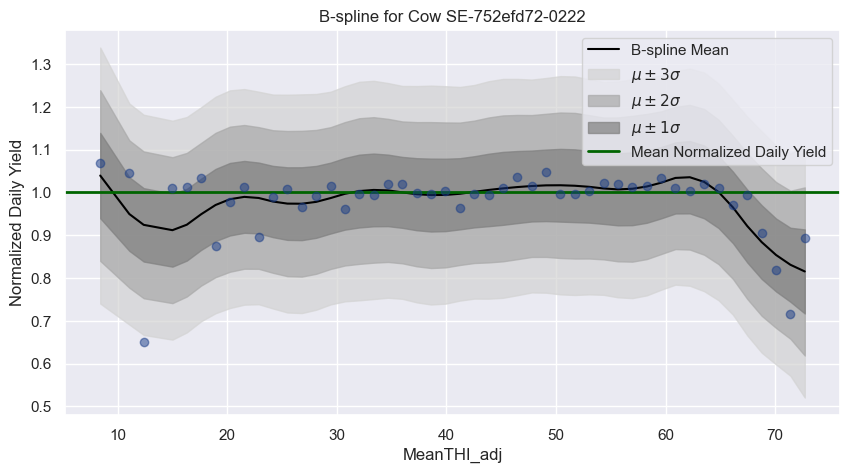

Skipping Cow SE-752efd72-2795 due to insufficient data points after filtering.


FarmName_Pseudo         SE_Number  THIMilkProduction [%]  \
0          752efd72  SE-752efd72-0001              -3.366610   
1          752efd72  SE-752efd72-0002               7.096095   
2          752efd72  SE-752efd72-0008              -0.626645   
3          752efd72  SE-752efd72-0010              -2.743902   
4          752efd72  SE-752efd72-0011              -1.993399   
..              ...               ...                    ...   
396        752efd72  SE-752efd72-0345              -2.447161   
397        752efd72  SE-752efd72-0450              -0.826783   
398        752efd72  SE-752efd72-0468              -0.652259   
399        752efd72  SE-752efd72-0469              -0.815849   
400        752efd72  SE-752efd72-2734              -7.922792   

     THIMilkProduction  
0            -0.033666  
1             0.070961  
2            -0.006266  
3            -0.027439  
4            -0.019934  
..                 ...  
396          -0.024472  
397          -0.008268  
398          -0.006523  
399          -0.008158  
400          -0.079228  

[401 rows x 4 columns]

In [18]:
# Seed for reproducibility
np.random.seed(42)

# Initialize an empty DataFrame to store results
results_df = pd.DataFrame(columns=['FarmName_Pseudo', 'SE_Number', 'THIMilkProduction [%]'])

# Select a random cow for plotting
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N)
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Convert bin_midpoints to numeric for comparison
    x = mean_yields[input_feature_label].values.astype(float)
    y = mean_yields.NormalizedDailyYield.values

    # Ensure sufficient data points
    if len(y) < 2:  # Ensure at least 2 data points
        print(f"Skipping Cow {se_number} due to insufficient data points.")
        continue

    try:
        # B-Spline Basis Functions (Primary Method)
        degree_spline = 2  # Change the order of the polynomial here
        max_knots = min(len(y) - 1, 10)
        num_qs = max_knots
        knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs + 1)[1:-1])
        B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

        # Check if B has more rows than columns
        if B.shape[0] < B.shape[1]:
            raise ValueError(f"Incompatible dimensions (B: {B.shape})")

        # Step 1: Calculate empirical priors from the correct data
        m0 = np.linalg.lstsq(B, y, rcond=None)[0]  # Least-squares estimate as prior mean
        S0 = np.cov(B.T)  # Covariance of the design matrix as prior covariance

        if np.any(np.isnan(S0)) or np.any(np.isinf(S0)):
            print(f"Skipping Cow {se_number} due to invalid covariance matrix.")
            continue

        # Bayesian Linear Regression
        beta = 1 / np.var(y)
        lambda_ridge = 0.1
        SN = np.linalg.pinv(np.linalg.pinv(S0) + beta * B.T @ B + lambda_ridge * np.eye(B.shape[1]))
        mN = SN @ (np.linalg.pinv(S0) @ m0 + beta * B.T @ y)

        # Make predictions
        mstar_mle = B @ mN
        Sstar_mle = B @ SN @ B.T + beta ** (-1) * np.eye(B.shape[0])
        stdpred_mle = np.sqrt(np.diag(Sstar_mle))
        model_type = 'B-spline'

    except Exception as e:
        print(f"Skipping Cow {se_number} due to incompatible dimensions or another error: {str(e)}")
        continue

    # Filter x and corresponding mstar_mle for values >= 61
    filtered_indices = x >= 61  # Only include THI values >= 61
    if np.sum(filtered_indices) < 2:
        print(f"Skipping Cow {se_number} due to insufficient data points after filtering.")
        continue

    filtered_xs = x[filtered_indices]
    filtered_mstar_mle = mstar_mle[filtered_indices]

    # Integration to calculate THIMilkProduction
    above_mean = np.maximum(filtered_mstar_mle - mean_yield, 0)
    below_mean = np.maximum(mean_yield - filtered_mstar_mle, 0)

    # Integrate over the filtered x values
    area_above_mean = simpson(above_mean, x=filtered_xs)
    area_below_mean = simpson(below_mean, x=filtered_xs)

    # Calculate the net area (above - below)
    net_area = area_above_mean - area_below_mean
    range_mean_temperature = filtered_xs[-1] - filtered_xs[0]
    net_effect_per_unit = net_area / range_mean_temperature

    # Express the net effect as a percentage of the mean yield
    net_effect_percentage = (net_effect_per_unit / mean_yield) * 100

    # Store results in the DataFrame
    new_result = pd.DataFrame([{
        'FarmName_Pseudo': farm_id,
        'SE_Number': se_number,
        'THIMilkProduction [%]': net_effect_percentage
    }])

    if results_df.empty:
        results_df = new_result
    else:
        results_df = pd.concat([results_df, new_result], ignore_index=True)

    # Plot for the randomly selected cow
    if se_number == random_cow:
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(x, mstar_mle, 'black', label=f'{model_type} Mean')
        ax.fill_between(x, mstar_mle + 3*stdpred_mle, mstar_mle - 3*stdpred_mle, color='lightgray', alpha=0.7, label=r'$\mu \pm 3\sigma$')
        ax.fill_between(x, mstar_mle + 2*stdpred_mle, mstar_mle - 2*stdpred_mle, color='darkgray', alpha=0.7, label=r'$\mu \pm 2\sigma$')
        ax.fill_between(x, mstar_mle + 1*stdpred_mle, mstar_mle - 1*stdpred_mle, color='gray', alpha=0.7, label=r'$\mu \pm 1\sigma$')
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')
        plt.scatter(x, y, c='#183B87', zorder=4, alpha=0.5)
        ax.legend(loc='best')
        plt.title(f'{model_type} for Cow {se_number}')
        plt.xlabel(f'{input_feature_label}')
        plt.ylabel('Normalized Daily Yield')
        plt.show()

# Display the results
results_df['THIMilkProduction'] = results_df['THIMilkProduction [%]'] / 100
results_df

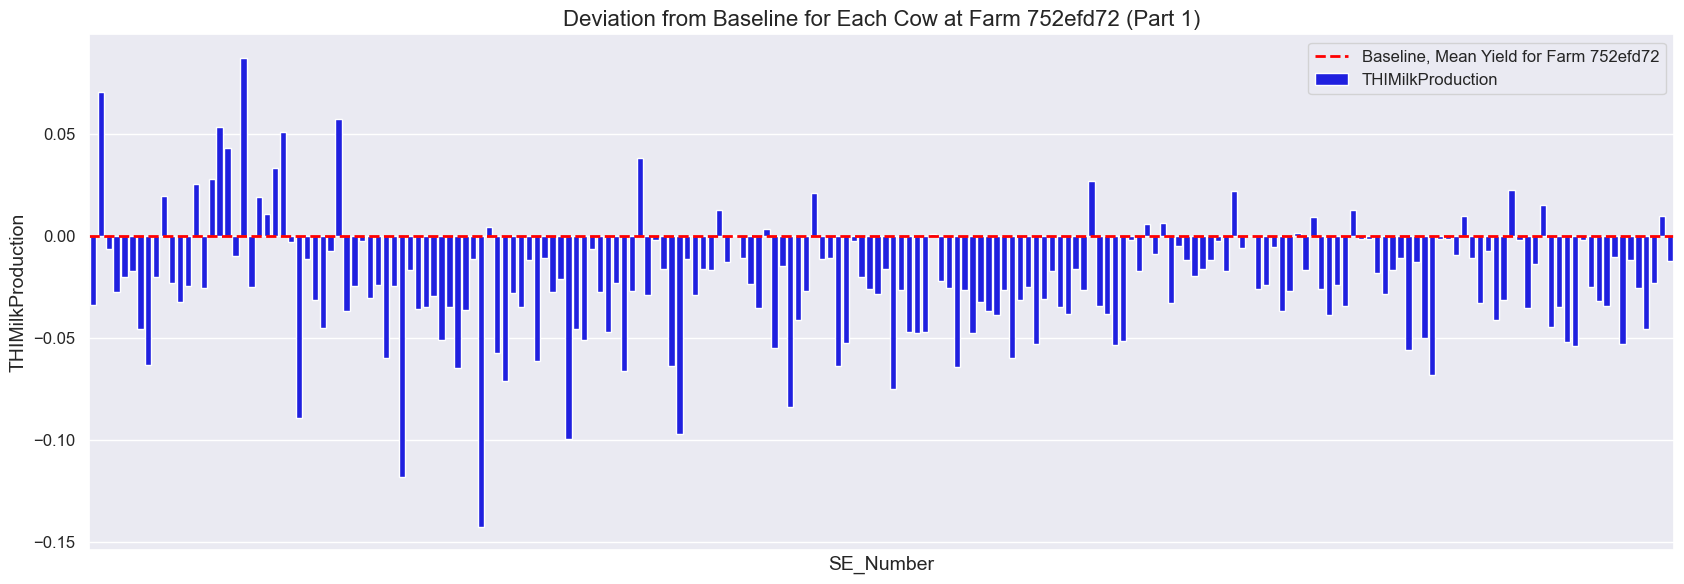

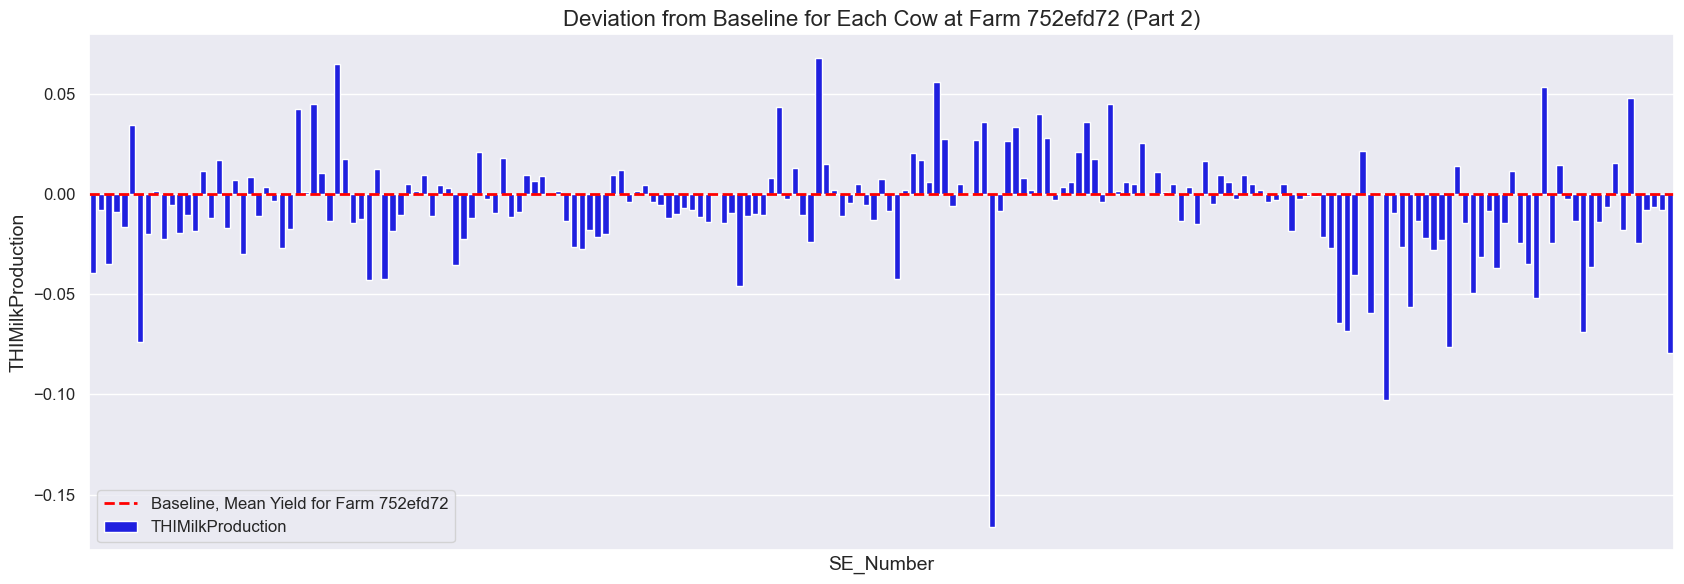

In [19]:
# Calculate the midpoint to split the data into two halves
midpoint = len(results_df) // 2

# Split the data into two halves
first_half = results_df.iloc[:midpoint]
second_half = results_df.iloc[midpoint:]

# Plotting for the first half
plt.figure(figsize=(17, 6))
sns.barplot(x=first_half.index, y=first_half['THIMilkProduction'], color='blue', label='THIMilkProduction')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('THIMilkProduction', fontsize=14)
plt.title(f'Deviation from Baseline for Each Cow at Farm {farm_id} (Part 1)', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Plotting for the second half
plt.figure(figsize=(17, 6))
sns.barplot(x=second_half.index, y=second_half['THIMilkProduction'], color='blue', label='THIMilkProduction')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('THIMilkProduction', fontsize=14)
plt.title(f'Deviation from Baseline for Each Cow at Farm {farm_id} (Part 2)', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

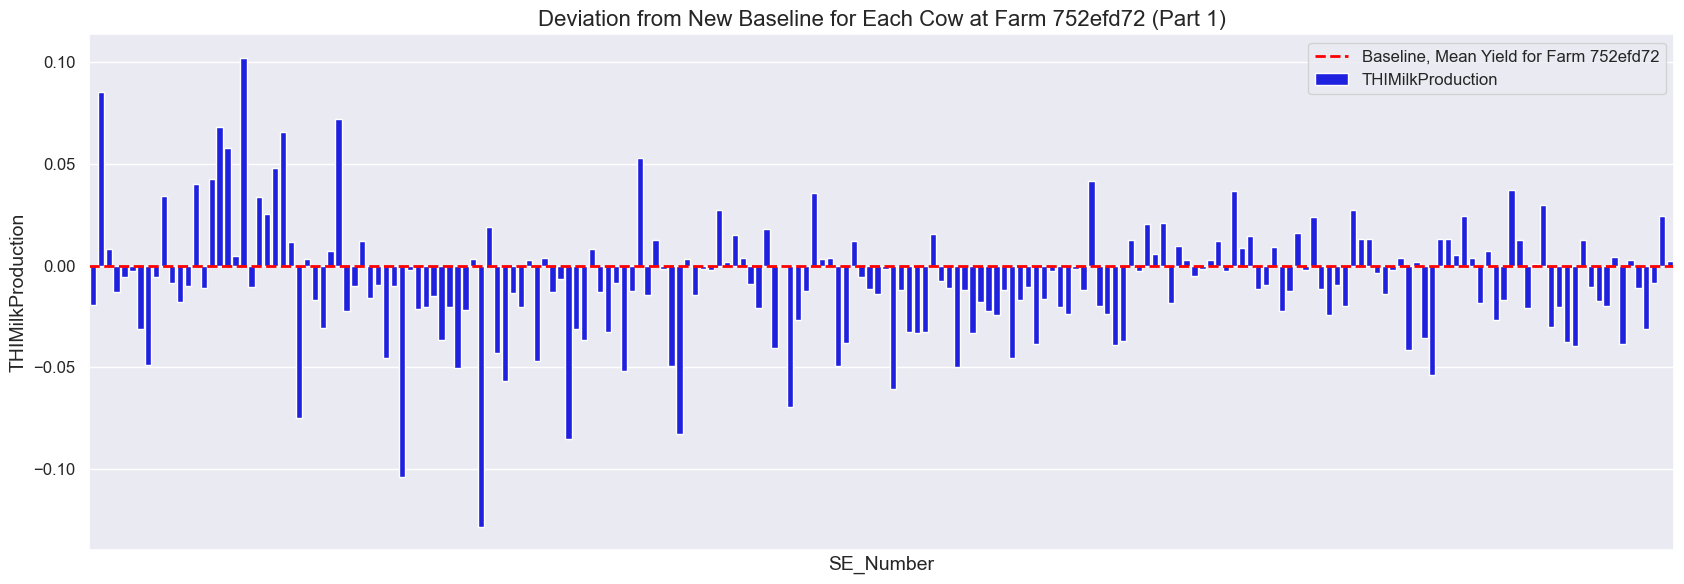

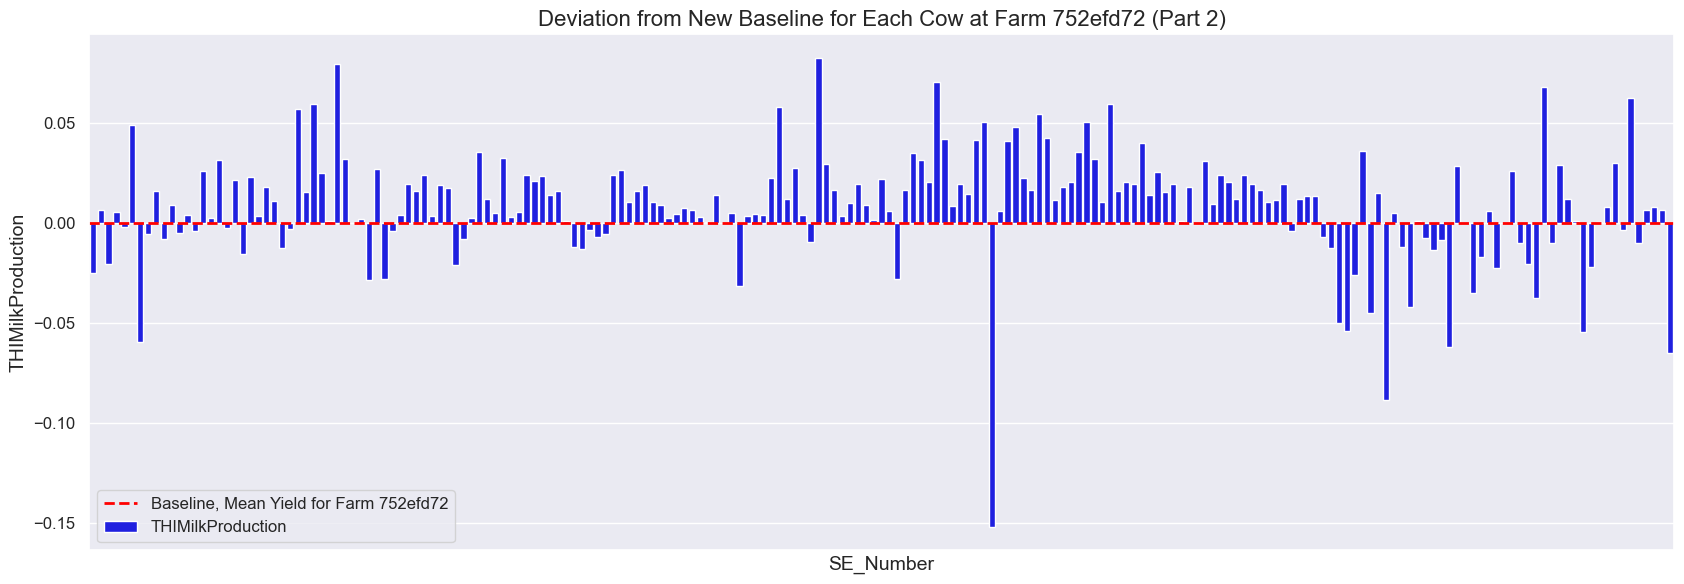

In [20]:
# New baseline value
new_baseline = results_df['THIMilkProduction'].mean()

# Adjust the THIMilkProduction to start from the new baseline
results_df['AdjustedTHIMilkProduction'] = results_df['THIMilkProduction'] - new_baseline

# Calculate the midpoint to split the data into two halves
midpoint = len(results_df) // 2

# Split the data into two halves
first_half = results_df.iloc[:midpoint]
second_half = results_df.iloc[midpoint:]

# Plotting for the first half
plt.figure(figsize=(17, 6))
sns.barplot(x=first_half.index, y=first_half['AdjustedTHIMilkProduction'], color='blue', label='THIMilkProduction')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('THIMilkProduction', fontsize=14)
plt.title(f'Deviation from New Baseline for Each Cow at Farm {farm_id} (Part 1)', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Plotting for the second half
plt.figure(figsize=(17, 6))
sns.barplot(x=second_half.index, y=second_half['AdjustedTHIMilkProduction'], color='blue', label='THIMilkProduction')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('THIMilkProduction', fontsize=14)
plt.title(f'Deviation from New Baseline for Each Cow at Farm {farm_id} (Part 2)', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

## Farm f454e660

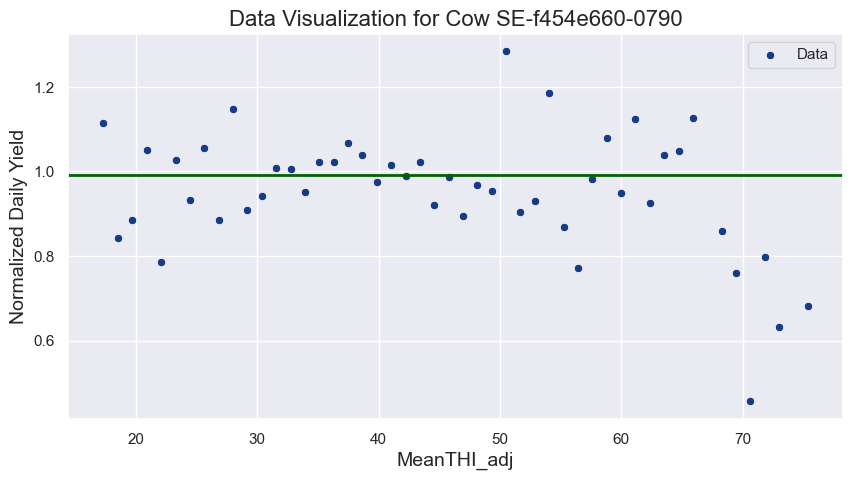

In [29]:
# Filter data for the specific farm
farm_id = 'f454e660'
farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm_id]

# Get unique cows (SE_Number) in the farm
unique_cows = farm_data['SE_Number'].unique()

# Select a random cow for plotting (you can set seed for reproducibility)
np.random.seed(42)  # For reproducibility
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Data Preparation
    N = 50  # Number of bins
    input_feature_label = 'MeanTHI_adj'
    
    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N) 
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Calculate mean_yield for this cow
    mean_yield = cow_data['NormalizedDailyYield'].mean()

    # Initial Visualization (for a random cow only)
    if se_number == random_cow:
        fig = plt.figure(figsize=(10, 5))
        ax = plt.subplot(111)
        scatter = sns.scatterplot(x=x, y=y, label='Data', color='#183B87', ax=ax)

        # Add horizontal line for the mean yield
        mean_yield = cow_data['NormalizedDailyYield'].mean()
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')
        
        plt.title(f"Data Visualization for Cow {se_number}", fontsize=16)
        plt.xlabel('MeanTHI_adj', fontsize=14)
        plt.ylabel('Normalized Daily Yield', fontsize=14)
        plt.show()

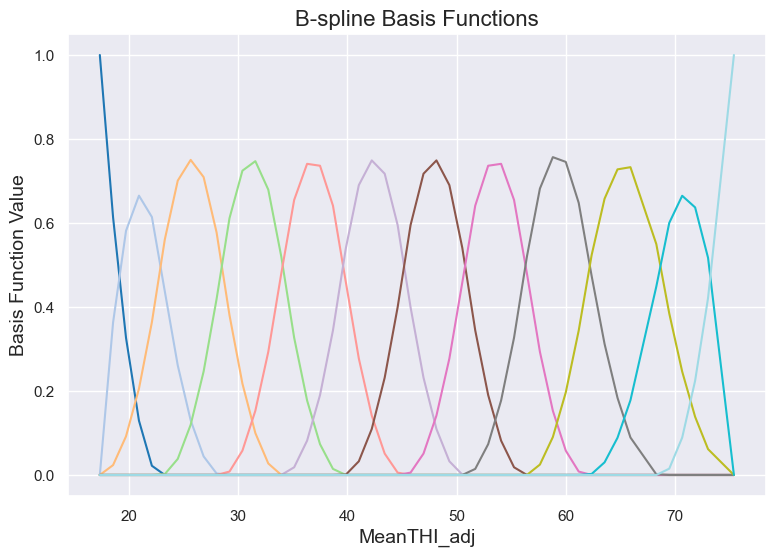

In [30]:
def Phi(a, knots, degree=3, spline_type='B'):
    lower_bound = min(a)
    upper_bound = max(a)
    
    # Adjust knots to ensure they are within the bounds
    knots = np.clip(knots, lower_bound, upper_bound)
    
    if spline_type == 'B':
        B = dmatrix(f"bs(x, knots=knots, degree={degree}, include_intercept=True) - 1", {"x": a, 'knots': knots})
    elif spline_type == 'CR':
        B = dmatrix(f"cr(x, knots=knots, constraints='center')- 1", {"x": a, 'knots': knots})
    elif spline_type == 'CC':
        B = dmatrix(f"cc(x, knots=knots, constraints='center') - 1", {"x": a, 'knots': knots})
    else:
        raise ValueError(f"{spline_type} is not a valid type, choose from 'B', 'CC' or 'CR'")
    return B


for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]
    
    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N) 
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Block 2: B-Spline Basis Functions
    degree_spline = 2  # Change the order of the polynomial here
    num_qs = 10
    knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs+1)[1:-1])

    B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

    # Plot Basis Functions (for the random cow)
    if se_number == random_cow:
        color_map = plt.colormaps.get_cmap('tab20')
        colors = color_map(np.linspace(0, 1, B.shape[1]))

        fig = plt.figure(figsize=(9, 6))
        ax = plt.subplot(111)
        for i in range(B.shape[1]):
            c = colors[i]
            ax.plot(x, B[:, i], c=c, label=f'Basis {i + 1}')

        plt.title('B-spline Basis Functions', fontsize=16)
        plt.xlabel('MeanTHI_adj', fontsize=14)
        plt.ylabel('Basis Function Value', fontsize=14)
        plt.show()

Mean squared error for Cow SE-f454e660-0790 is 0.0094


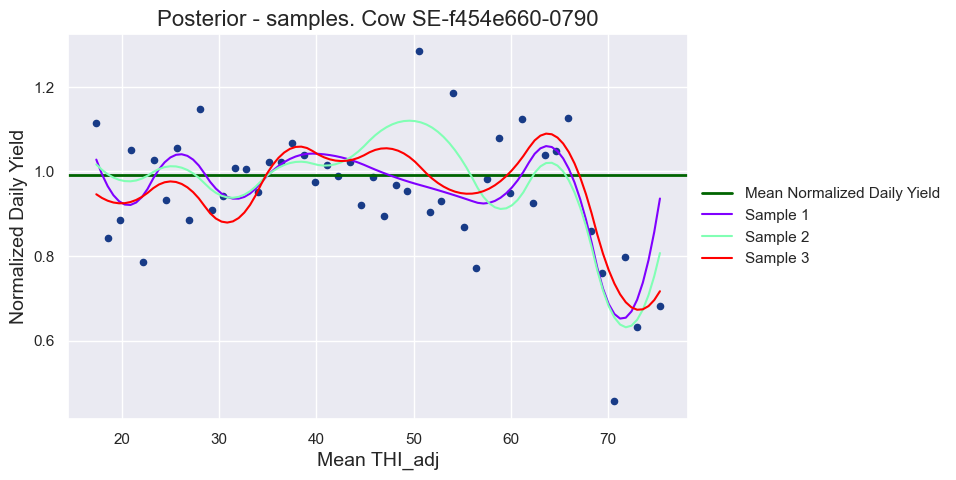

In [31]:
# Seed for reproducibility
np.random.seed(42)

# Select a random cow for plotting
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N)
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Check if there are enough data points
    if len(y) < 2:  # If fewer than 2 data points, skip this cow
        print(f"Skipping Cow {se_number} due to insufficient data points.")
        continue

    # Block 2: B-Spline Basis Functions
    degree_spline = 2  # Change the order of the polynomial here
    num_qs = 10
    knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs + 1)[1:-1])

    B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

    # Block 3: Bayesian Linear Regression - GAM
    # Calculate empirical priors from the data
    D = B.shape[1]
    m0 = np.linalg.lstsq(B, y, rcond=None)[0]  # Least-squares estimate as prior mean
    S0 = np.cov(B.T)  # Covariance of the design matrix as prior covariance

    if np.any(np.isnan(S0)) or np.any(np.isinf(S0)):
        print(f"Skipping Cow {se_number} due to invalid covariance matrix.")
        continue

    beta = 1 / np.var(y)

    if np.isinf(beta) or np.isnan(beta):
        print(f"Skipping Cow {se_number} due to invalid beta value.")
        continue

    # Compute the posterior distribution with new priors
    SN = pinv(pinv(S0) + beta * B.T @ B)

    # Adding a small regularization term to ensure positive semi-definiteness
    regularization_term = 1e-6 * np.eye(D)
    SN += regularization_term

    mN = SN @ (pinv(S0) @ m0 + beta * B.T @ y)

    # Print MSE for this cow
    mse = np.mean((y - B @ mN) ** 2)

    # Plot the posterior for the random cow
    if se_number == random_cow:
        print(f"Mean squared error for Cow {se_number} is {mse:.4f}")
        samples = 3
        seed = 100
        ws = multivariate_normal(mean=mN, cov=SN, allow_singular=True).rvs(samples, random_state=seed)

        n = 100  # number of grid-points
        xs = np.linspace(x.min(), x.max(), n)
        new_data = {'x': xs}

        B_star = build_design_matrices([B.design_info], new_data)[0]
        B_star = np.asarray(B_star)

        # Compute corresponding values f(x*)
        fs = B_star @ ws.T

        # Plot the samples
        fig = plt.figure(figsize=(10, 5))
        ax = plt.subplot(111)
        plt.scatter(x, y, color='#183B87', zorder=1, s=20)

        # Add horizontal line for the mean yield
        mean_yield = cow_data['NormalizedDailyYield'].mean()
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')

        color = cycle(cm.rainbow(np.linspace(0, 1, samples)))
        for i in range(ws.shape[0]):
            c = next(color)
            line, = ax.plot(xs, fs[:, i], c=c, label=f"Sample {i+1}")

        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0)  # Set legend transparency

        plt.title(f'Posterior - samples. Cow {se_number}', fontsize=16)
        plt.xlabel(re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label), fontsize=14)
        plt.ylabel('Normalized Daily Yield', fontsize=14)  # Updated ylabel

        plt.show()

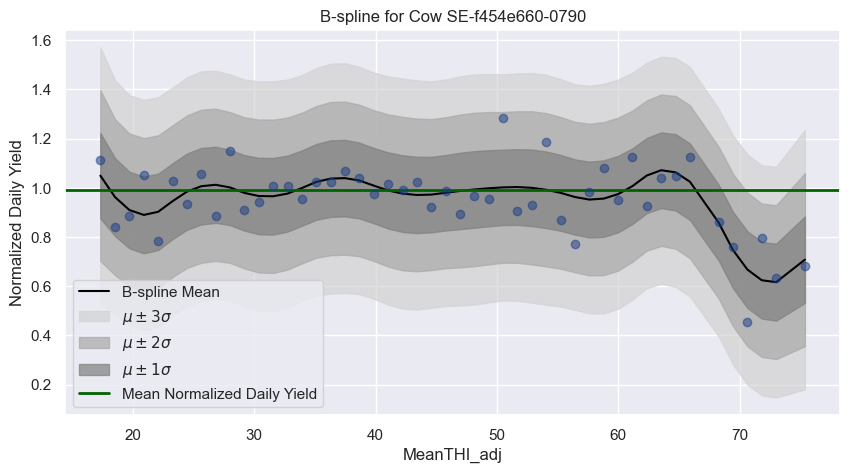

FarmName_Pseudo         SE_Number  THIMilkProduction [%]  THIMilkProduction
0         f454e660  SE-f454e660-0139              -7.205672          -0.072057
1         f454e660  SE-f454e660-0282              -1.484270          -0.014843
2         f454e660  SE-f454e660-0373              -6.642661          -0.066427
3         f454e660  SE-f454e660-0374              -2.581679          -0.025817
4         f454e660  SE-f454e660-0412              -2.818322          -0.028183
5         f454e660  SE-f454e660-0420              -2.812654          -0.028127
6         f454e660  SE-f454e660-0422              -2.660661          -0.026607
7         f454e660  SE-f454e660-0444              -3.304267          -0.033043
8         f454e660  SE-f454e660-0448              -2.539761          -0.025398
9         f454e660  SE-f454e660-0465              -2.833641          -0.028336
10        f454e660  SE-f454e660-0477             -13.419408          -0.134194
11        f454e660  SE-f454e660-0494              -7.478054          -0.074781
12        f454e660  SE-f454e660-0503              -3.919728          -0.039197
13        f454e660  SE-f454e660-0504              -1.589346          -0.015893
14        f454e660  SE-f454e660-0569               1.920025           0.019200
15        f454e660  SE-f454e660-0579              -6.904710          -0.069047
16        f454e660  SE-f454e660-0588             -15.007078          -0.150071
17        f454e660  SE-f454e660-0611             -11.156674          -0.111567
18        f454e660  SE-f454e660-0616              -8.577019          -0.085770
19        f454e660  SE-f454e660-0635             -17.839659          -0.178397
20        f454e660  SE-f454e660-0638              -6.658791          -0.066588
21        f454e660  SE-f454e660-0652              -0.413068          -0.004131
22        f454e660  SE-f454e660-0675             -11.730308          -0.117303
23        f454e660  SE-f454e660-0684             -13.965481          -0.139655
24        f454e660  SE-f454e660-0700              -5.772115          -0.057721
25        f454e660  SE-f454e660-0708              -4.645841          -0.046458
26        f454e660  SE-f454e660-0710             -31.416292          -0.314163
27        f454e660  SE-f454e660-0719              -6.079803          -0.060798
28        f454e660  SE-f454e660-0726             -11.233855          -0.112339
29        f454e660  SE-f454e660-0740             -14.069563          -0.140696
30        f454e660  SE-f454e660-0743              -3.626246          -0.036262
31        f454e660  SE-f454e660-0745               3.495256           0.034953
32        f454e660  SE-f454e660-0752              -3.569431          -0.035694
33        f454e660  SE-f454e660-0754              -6.249832          -0.062498
34        f454e660  SE-f454e660-0760              -2.392026          -0.023920
35        f454e660  SE-f454e660-0762              -0.820755          -0.008208
36        f454e660  SE-f454e660-0770              -4.733403          -0.047334
37        f454e660  SE-f454e660-0785               0.282416           0.002824
38        f454e660  SE-f454e660-0790             -14.540340          -0.145403
39        f454e660  SE-f454e660-0791              -2.483078          -0.024831
40        f454e660  SE-f454e660-0793             -12.523260          -0.125233
41        f454e660  SE-f454e660-0794             -13.197807          -0.131978
42        f454e660  SE-f454e660-0795             -19.447800          -0.194478
43        f454e660  SE-f454e660-0797             -18.392844          -0.183928
44        f454e660  SE-f454e660-0798             -18.959108          -0.189591
45        f454e660  SE-f454e660-0800              -2.440523          -0.024405
46        f454e660  SE-f454e660-0803             -31.949251          -0.319493
47        f454e660  SE-f454e660-0823              -4.011922          -0.040119
48        f454e660  SE-f454e660-0829              -2.053156          -0.020532

In [32]:
# Seed for reproducibility
np.random.seed(42)

# Initialize an empty DataFrame to store results
results_df = pd.DataFrame(columns=['FarmName_Pseudo', 'SE_Number', 'THIMilkProduction [%]'])

# Select a random cow for plotting
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N)
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Convert bin_midpoints to numeric for comparison
    x = mean_yields[input_feature_label].values.astype(float)
    y = mean_yields.NormalizedDailyYield.values

    # Ensure sufficient data points
    if len(y) < 2:  # Ensure at least 2 data points
        print(f"Skipping Cow {se_number} due to insufficient data points.")
        continue

    try:
        # B-Spline Basis Functions (Primary Method)
        degree_spline = 2  # Change the order of the polynomial here
        max_knots = min(len(y) - 1, 10)
        num_qs = max_knots
        knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs + 1)[1:-1])
        B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

        # Check if B has more rows than columns
        if B.shape[0] < B.shape[1]:
            raise ValueError(f"Incompatible dimensions (B: {B.shape})")

        # Step 1: Calculate empirical priors from the correct data
        m0 = np.linalg.lstsq(B, y, rcond=None)[0]  # Least-squares estimate as prior mean
        S0 = np.cov(B.T)  # Covariance of the design matrix as prior covariance

        if np.any(np.isnan(S0)) or np.any(np.isinf(S0)):
            print(f"Skipping Cow {se_number} due to invalid covariance matrix.")
            continue

        # Bayesian Linear Regression
        beta = 1 / np.var(y)
        lambda_ridge = 0.1
        SN = np.linalg.pinv(np.linalg.pinv(S0) + beta * B.T @ B + lambda_ridge * np.eye(B.shape[1]))
        mN = SN @ (np.linalg.pinv(S0) @ m0 + beta * B.T @ y)

        # Make predictions
        mstar_mle = B @ mN
        Sstar_mle = B @ SN @ B.T + beta ** (-1) * np.eye(B.shape[0])
        stdpred_mle = np.sqrt(np.diag(Sstar_mle))
        model_type = 'B-spline'

    except Exception as e:
        print(f"Skipping Cow {se_number} due to incompatible dimensions or another error: {str(e)}")
        continue

    # Filter x and corresponding mstar_mle for values >= 61
    filtered_indices = x >= 61  # Only include THI values >= 61
    if np.sum(filtered_indices) < 2:
        print(f"Skipping Cow {se_number} due to insufficient data points after filtering.")
        continue

    filtered_xs = x[filtered_indices]
    filtered_mstar_mle = mstar_mle[filtered_indices]

    # Integration to calculate THIMilkProduction
    above_mean = np.maximum(filtered_mstar_mle - mean_yield, 0)
    below_mean = np.maximum(mean_yield - filtered_mstar_mle, 0)

    # Integrate over the filtered x values
    area_above_mean = simpson(above_mean, x=filtered_xs)
    area_below_mean = simpson(below_mean, x=filtered_xs)

    # Calculate the net area (above - below)
    net_area = area_above_mean - area_below_mean
    range_mean_temperature = filtered_xs[-1] - filtered_xs[0]
    net_effect_per_unit = net_area / range_mean_temperature

    # Express the net effect as a percentage of the mean yield
    net_effect_percentage = (net_effect_per_unit / mean_yield) * 100

    # Store results in the DataFrame
    new_result = pd.DataFrame([{
        'FarmName_Pseudo': farm_id,
        'SE_Number': se_number,
        'THIMilkProduction [%]': net_effect_percentage
    }])

    if results_df.empty:
        results_df = new_result
    else:
        results_df = pd.concat([results_df, new_result], ignore_index=True)

    # Plot for the randomly selected cow
    if se_number == random_cow:
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(x, mstar_mle, 'black', label=f'{model_type} Mean')
        ax.fill_between(x, mstar_mle + 3*stdpred_mle, mstar_mle - 3*stdpred_mle, color='lightgray', alpha=0.7, label=r'$\mu \pm 3\sigma$')
        ax.fill_between(x, mstar_mle + 2*stdpred_mle, mstar_mle - 2*stdpred_mle, color='darkgray', alpha=0.7, label=r'$\mu \pm 2\sigma$')
        ax.fill_between(x, mstar_mle + 1*stdpred_mle, mstar_mle - 1*stdpred_mle, color='gray', alpha=0.7, label=r'$\mu \pm 1\sigma$')
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')
        plt.scatter(x, y, c='#183B87', zorder=4, alpha=0.5)
        ax.legend(loc='best')
        plt.title(f'{model_type} for Cow {se_number}')
        plt.xlabel(f'{input_feature_label}')
        plt.ylabel('Normalized Daily Yield')
        plt.show()

# Display the results
results_df['THIMilkProduction'] = results_df['THIMilkProduction [%]'] / 100
results_df

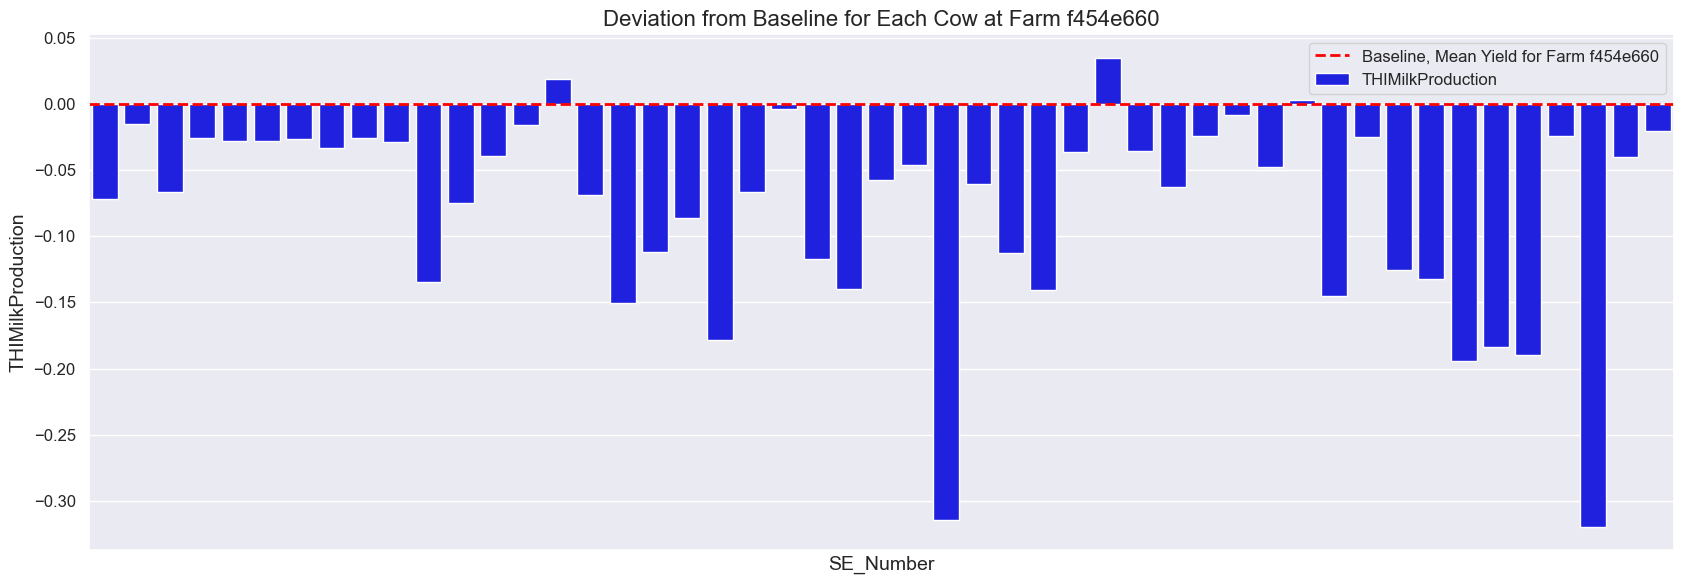

In [33]:
# Create the bar plot
plt.figure(figsize=(17, 6))
sns.barplot(x=results_df.index, y=results_df['THIMilkProduction'], color='blue', label='THIMilkProduction')

# Add a baseline line set to 0
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')

# Formatting the plot
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('THIMilkProduction', fontsize=14)
plt.title(f'Deviation from Baseline for Each Cow at Farm {farm_id}', fontsize=16)

# Optionally, remove x-axis labels if too many entries
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.legend(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

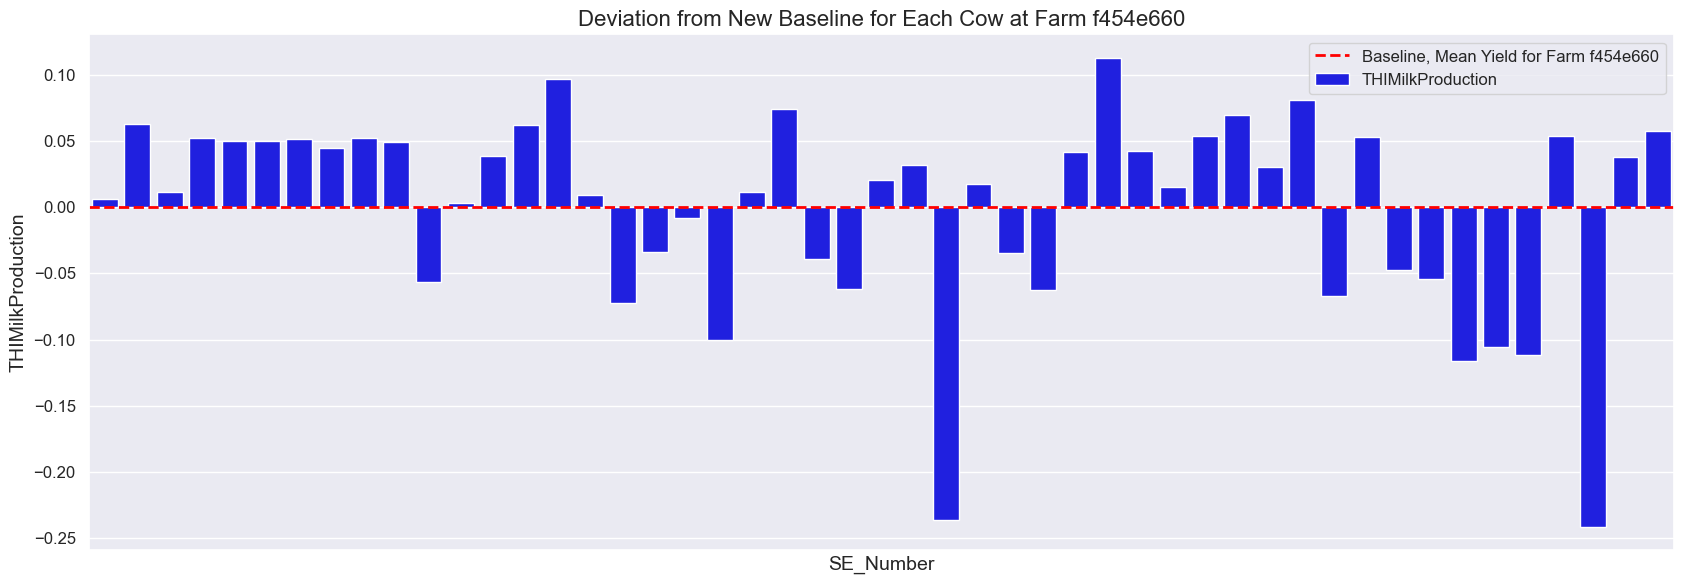

In [34]:
# New baseline value
new_baseline = results_df['THIMilkProduction'].mean()

# Adjust the THIMilkProduction to start from the new baseline
results_df['AdjustedTHIMilkProduction'] = results_df['THIMilkProduction'] - new_baseline

# Create the bar plot
plt.figure(figsize=(17, 6))
sns.barplot(x=results_df.index, y=results_df['AdjustedTHIMilkProduction'], color='blue', label='THIMilkProduction')

# Add a baseline line set to 0 (now adjusted to the new baseline)
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')

# Formatting the plot
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('THIMilkProduction', fontsize=14)
plt.title(f'Deviation from New Baseline for Each Cow at Farm {farm_id}', fontsize=16)

# Optionally, remove x-axis labels if too many entries
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.legend(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

# Farm 5b581702

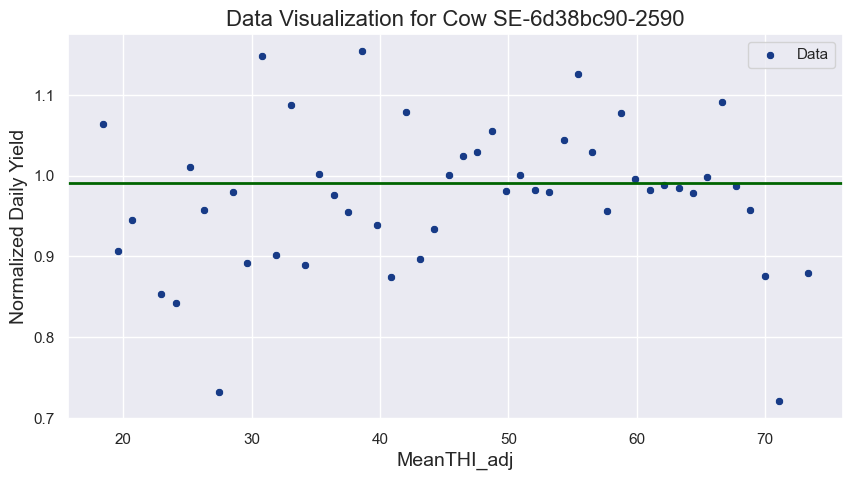

In [35]:
# Filter data for the specific farm
farm_id = '5b581702'
farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm_id]

# Get unique cows (SE_Number) in the farm
unique_cows = farm_data['SE_Number'].unique()

# Initialize an empty DataFrame to store results
results_df = pd.DataFrame(columns=['FarmName_Pseudo', 'SE_Number', 'CumHeatLoadMilkProduction [%]'])

# Select a random cow for plotting (you can set seed for reproducibility)
np.random.seed(42)  # For reproducibility
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Data Preparation
    N = 50  # Number of bins
    input_feature_label = 'MeanTHI_adj'
    
    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N) 
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Calculate mean_yield for this cow
    mean_yield = cow_data['NormalizedDailyYield'].mean()

    # Initial Visualization (for a random cow only)
    if se_number == random_cow:
        fig = plt.figure(figsize=(10, 5))
        ax = plt.subplot(111)
        scatter = sns.scatterplot(x=x, y=y, label='Data', color='#183B87', ax=ax)

        # Add horizontal line for the mean yield
        mean_yield = cow_data['NormalizedDailyYield'].mean()
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')
        
        plt.title(f"Data Visualization for Cow {se_number}", fontsize=16)
        plt.xlabel('MeanTHI_adj', fontsize=14)
        plt.ylabel('Normalized Daily Yield', fontsize=14)
        plt.show()

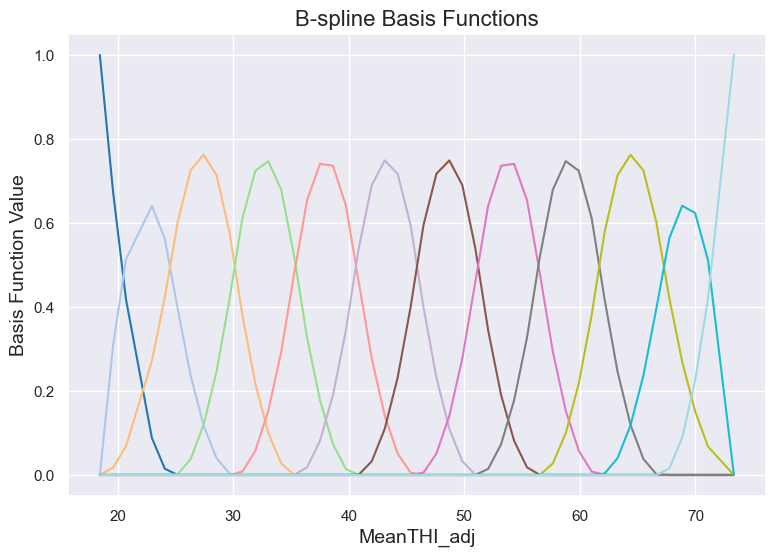

In [36]:
def Phi(a, knots, degree=3, spline_type='B'):
    lower_bound = min(a)
    upper_bound = max(a)
    
    # Adjust knots to ensure they are within the bounds
    knots = np.clip(knots, lower_bound, upper_bound)
    
    if spline_type == 'B':
        B = dmatrix(f"bs(x, knots=knots, degree={degree}, include_intercept=True) - 1", {"x": a, 'knots': knots})
    elif spline_type == 'CR':
        B = dmatrix(f"cr(x, knots=knots, constraints='center')- 1", {"x": a, 'knots': knots})
    elif spline_type == 'CC':
        B = dmatrix(f"cc(x, knots=knots, constraints='center') - 1", {"x": a, 'knots': knots})
    else:
        raise ValueError(f"{spline_type} is not a valid type, choose from 'B', 'CC' or 'CR'")
    return B


for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]
    
    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N) 
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Block 2: B-Spline Basis Functions
    degree_spline = 2  # Change the order of the polynomial here
    num_qs = 10
    knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs+1)[1:-1])

    B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

    # Plot Basis Functions (for the random cow)
    if se_number == random_cow:
        color_map = plt.colormaps.get_cmap('tab20')
        colors = color_map(np.linspace(0, 1, B.shape[1]))

        fig = plt.figure(figsize=(9, 6))
        ax = plt.subplot(111)
        for i in range(B.shape[1]):
            c = colors[i]
            ax.plot(x, B[:, i], c=c, label=f'Basis {i + 1}')

        plt.title('B-spline Basis Functions', fontsize=16)
        plt.xlabel('MeanTHI_adj', fontsize=14)
        plt.ylabel('Basis Function Value', fontsize=14)
        plt.show()

Mean squared error for Cow SE-6d38bc90-2590 is 0.0054


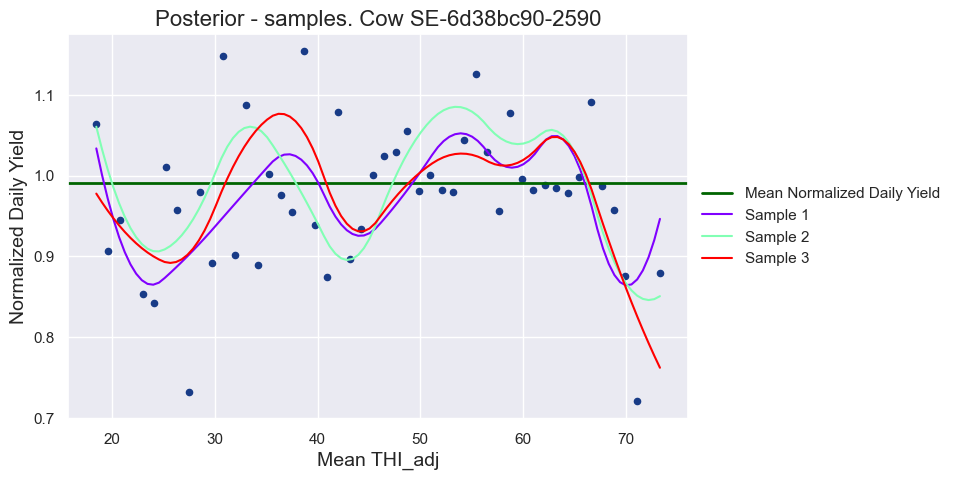

In [37]:
# Seed for reproducibility
np.random.seed(42)

# Select a random cow for plotting
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N)
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Check if there are enough data points
    if len(y) < 2:  # If fewer than 2 data points, skip this cow
        print(f"Skipping Cow {se_number} due to insufficient data points.")
        continue

    # Block 2: B-Spline Basis Functions
    degree_spline = 2  # Change the order of the polynomial here
    num_qs = 10
    knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs + 1)[1:-1])

    B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

    # Block 3: Bayesian Linear Regression - GAM
    # Calculate empirical priors from the data
    D = B.shape[1]
    m0 = np.linalg.lstsq(B, y, rcond=None)[0]  # Least-squares estimate as prior mean
    S0 = np.cov(B.T)  # Covariance of the design matrix as prior covariance

    if np.any(np.isnan(S0)) or np.any(np.isinf(S0)):
        print(f"Skipping Cow {se_number} due to invalid covariance matrix.")
        continue

    beta = 1 / np.var(y)

    if np.isinf(beta) or np.isnan(beta):
        print(f"Skipping Cow {se_number} due to invalid beta value.")
        continue

    # Compute the posterior distribution with new priors
    SN = pinv(pinv(S0) + beta * B.T @ B)

    # Adding a small regularization term to ensure positive semi-definiteness
    regularization_term = 1e-6 * np.eye(D)
    SN += regularization_term

    mN = SN @ (pinv(S0) @ m0 + beta * B.T @ y)

    # Print MSE for this cow
    mse = np.mean((y - B @ mN) ** 2)

    # Plot the posterior for the random cow
    if se_number == random_cow:
        print(f"Mean squared error for Cow {se_number} is {mse:.4f}")
        samples = 3
        seed = 100
        ws = multivariate_normal(mean=mN, cov=SN, allow_singular=True).rvs(samples, random_state=seed)

        n = 100  # number of grid-points
        xs = np.linspace(x.min(), x.max(), n)
        new_data = {'x': xs}

        B_star = build_design_matrices([B.design_info], new_data)[0]
        B_star = np.asarray(B_star)

        # Compute corresponding values f(x*)
        fs = B_star @ ws.T

        # Plot the samples
        fig = plt.figure(figsize=(10, 5))
        ax = plt.subplot(111)
        plt.scatter(x, y, color='#183B87', zorder=1, s=20)

        # Add horizontal line for the mean yield
        mean_yield = cow_data['NormalizedDailyYield'].mean()
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')

        color = cycle(cm.rainbow(np.linspace(0, 1, samples)))
        for i in range(ws.shape[0]):
            c = next(color)
            line, = ax.plot(xs, fs[:, i], c=c, label=f"Sample {i+1}")

        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0)  # Set legend transparency

        plt.title(f'Posterior - samples. Cow {se_number}', fontsize=16)
        plt.xlabel(re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label), fontsize=14)
        plt.ylabel('Normalized Daily Yield', fontsize=14)  # Updated ylabel

        plt.show()

Skipping Cow SE-5b581702-2138 due to insufficient data points after filtering.


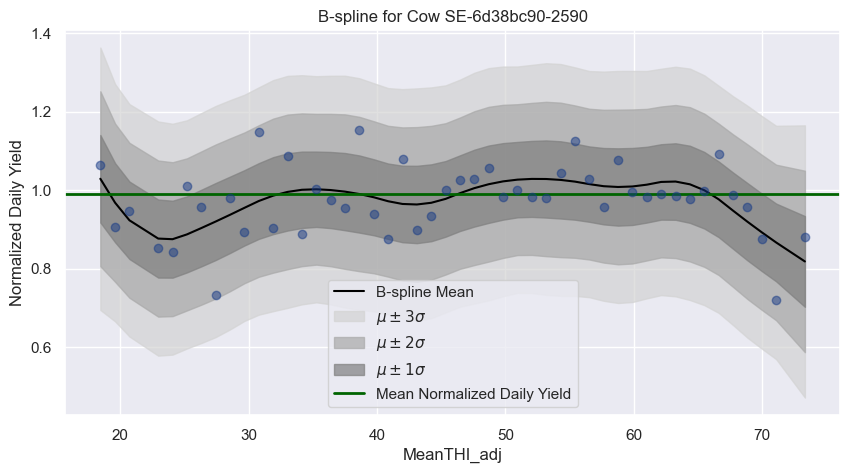

FarmName_Pseudo         SE_Number  THIMilkProduction [%]  THIMilkProduction
0         5b581702  SE-27c3257a-1492              -9.676940          -0.096769
1         5b581702  SE-4b8091ac-1472              -7.753137          -0.077531
2         5b581702  SE-5b581702-1742              -0.120991          -0.001210
3         5b581702  SE-5b581702-1755              -7.997232          -0.079972
4         5b581702  SE-5b581702-1759               6.901918           0.069019
..             ...               ...                    ...                ...
59        5b581702  SE-5b581702-1802              -1.397543          -0.013975
60        5b581702  SE-5b581702-1856              -7.523206          -0.075232
61        5b581702  SE-5b581702-1902              -1.507334          -0.015073
62        5b581702  SE-5b581702-2104               1.587994           0.015880
63        5b581702  SE-5b581702-2151              -1.585498          -0.015855

[64 rows x 4 columns]

In [38]:
# Seed for reproducibility
np.random.seed(42)

# Initialize an empty DataFrame to store results
results_df = pd.DataFrame(columns=['FarmName_Pseudo', 'SE_Number', 'THIMilkProduction [%]'])

# Select a random cow for plotting
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N)
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Convert bin_midpoints to numeric for comparison
    x = mean_yields[input_feature_label].values.astype(float)
    y = mean_yields.NormalizedDailyYield.values

    # Ensure sufficient data points
    if len(y) < 2:  # Ensure at least 2 data points
        print(f"Skipping Cow {se_number} due to insufficient data points.")
        continue

    try:
        # B-Spline Basis Functions (Primary Method)
        degree_spline = 2  # Change the order of the polynomial here
        max_knots = min(len(y) - 1, 10)
        num_qs = max_knots
        knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs + 1)[1:-1])
        B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

        # Check if B has more rows than columns
        if B.shape[0] < B.shape[1]:
            raise ValueError(f"Incompatible dimensions (B: {B.shape})")

        # Step 1: Calculate empirical priors from the correct data
        m0 = np.linalg.lstsq(B, y, rcond=None)[0]  # Least-squares estimate as prior mean
        S0 = np.cov(B.T)  # Covariance of the design matrix as prior covariance

        if np.any(np.isnan(S0)) or np.any(np.isinf(S0)):
            print(f"Skipping Cow {se_number} due to invalid covariance matrix.")
            continue

        # Bayesian Linear Regression
        beta = 1 / np.var(y)
        lambda_ridge = 0.1
        SN = np.linalg.pinv(np.linalg.pinv(S0) + beta * B.T @ B + lambda_ridge * np.eye(B.shape[1]))
        mN = SN @ (np.linalg.pinv(S0) @ m0 + beta * B.T @ y)

        # Make predictions
        mstar_mle = B @ mN
        Sstar_mle = B @ SN @ B.T + beta ** (-1) * np.eye(B.shape[0])
        stdpred_mle = np.sqrt(np.diag(Sstar_mle))
        model_type = 'B-spline'

    except Exception as e:
        print(f"Skipping Cow {se_number} due to incompatible dimensions or another error: {str(e)}")
        continue

    # Filter x and corresponding mstar_mle for values >= 61
    filtered_indices = x >= 61  # Only include THI values >= 61
    if np.sum(filtered_indices) < 2:
        print(f"Skipping Cow {se_number} due to insufficient data points after filtering.")
        continue

    filtered_xs = x[filtered_indices]
    filtered_mstar_mle = mstar_mle[filtered_indices]

    # Integration to calculate THIMilkProduction
    above_mean = np.maximum(filtered_mstar_mle - mean_yield, 0)
    below_mean = np.maximum(mean_yield - filtered_mstar_mle, 0)

    # Integrate over the filtered x values
    area_above_mean = simpson(above_mean, x=filtered_xs)
    area_below_mean = simpson(below_mean, x=filtered_xs)

    # Calculate the net area (above - below)
    net_area = area_above_mean - area_below_mean
    range_mean_temperature = filtered_xs[-1] - filtered_xs[0]
    net_effect_per_unit = net_area / range_mean_temperature

    # Express the net effect as a percentage of the mean yield
    net_effect_percentage = (net_effect_per_unit / mean_yield) * 100

    # Store results in the DataFrame
    new_result = pd.DataFrame([{
        'FarmName_Pseudo': farm_id,
        'SE_Number': se_number,
        'THIMilkProduction [%]': net_effect_percentage
    }])

    if results_df.empty:
        results_df = new_result
    else:
        results_df = pd.concat([results_df, new_result], ignore_index=True)

    # Plot for the randomly selected cow
    if se_number == random_cow:
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(x, mstar_mle, 'black', label=f'{model_type} Mean')
        ax.fill_between(x, mstar_mle + 3*stdpred_mle, mstar_mle - 3*stdpred_mle, color='lightgray', alpha=0.7, label=r'$\mu \pm 3\sigma$')
        ax.fill_between(x, mstar_mle + 2*stdpred_mle, mstar_mle - 2*stdpred_mle, color='darkgray', alpha=0.7, label=r'$\mu \pm 2\sigma$')
        ax.fill_between(x, mstar_mle + 1*stdpred_mle, mstar_mle - 1*stdpred_mle, color='gray', alpha=0.7, label=r'$\mu \pm 1\sigma$')
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')
        plt.scatter(x, y, c='#183B87', zorder=4, alpha=0.5)
        ax.legend(loc='best')
        plt.title(f'{model_type} for Cow {se_number}')
        plt.xlabel(f'{input_feature_label}')
        plt.ylabel('Normalized Daily Yield')
        plt.show()

# Display the results
results_df['THIMilkProduction'] = results_df['THIMilkProduction [%]'] / 100
results_df

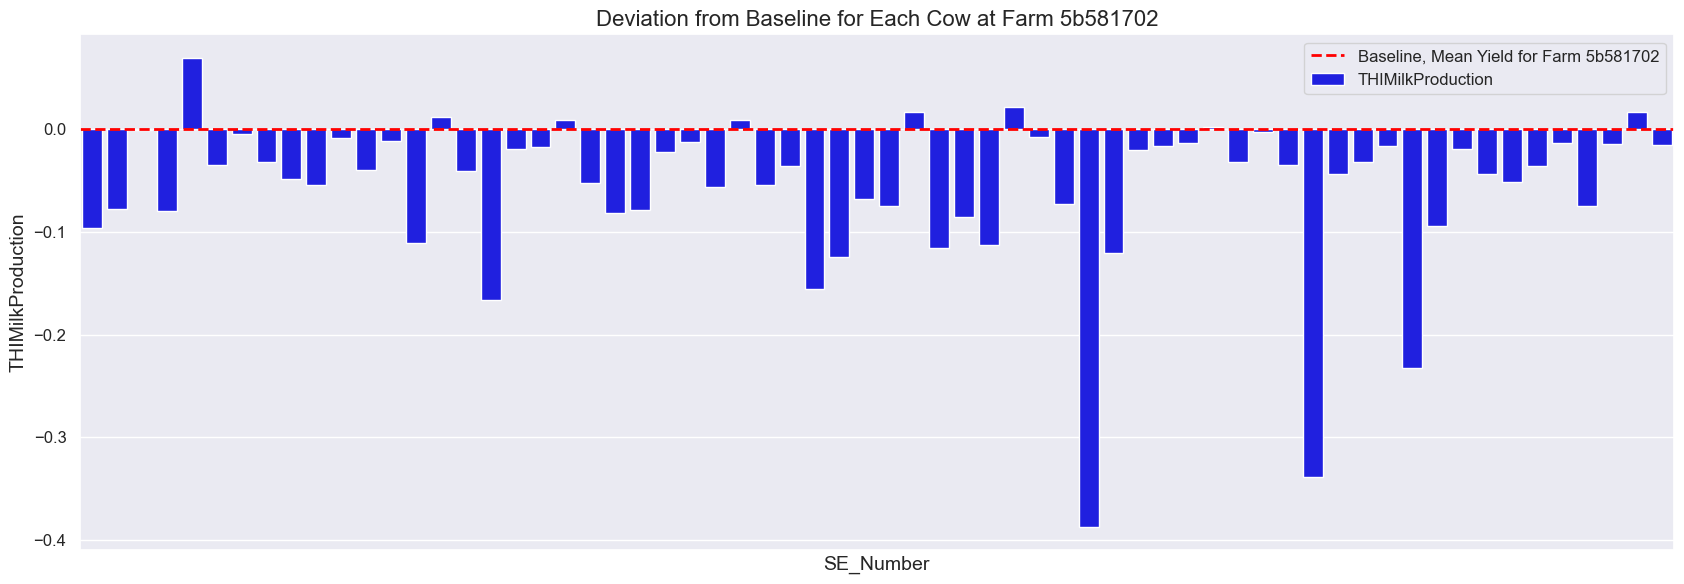

In [39]:
# Create the bar plot
plt.figure(figsize=(17, 6))
sns.barplot(x=results_df.index, y=results_df['THIMilkProduction'], color='blue', label='THIMilkProduction')

# Add a baseline line set to 0
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')

# Formatting the plot
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('THIMilkProduction', fontsize=14)
plt.title(f'Deviation from Baseline for Each Cow at Farm {farm_id}', fontsize=16)

# Optionally, remove x-axis labels if too many entries
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.legend(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

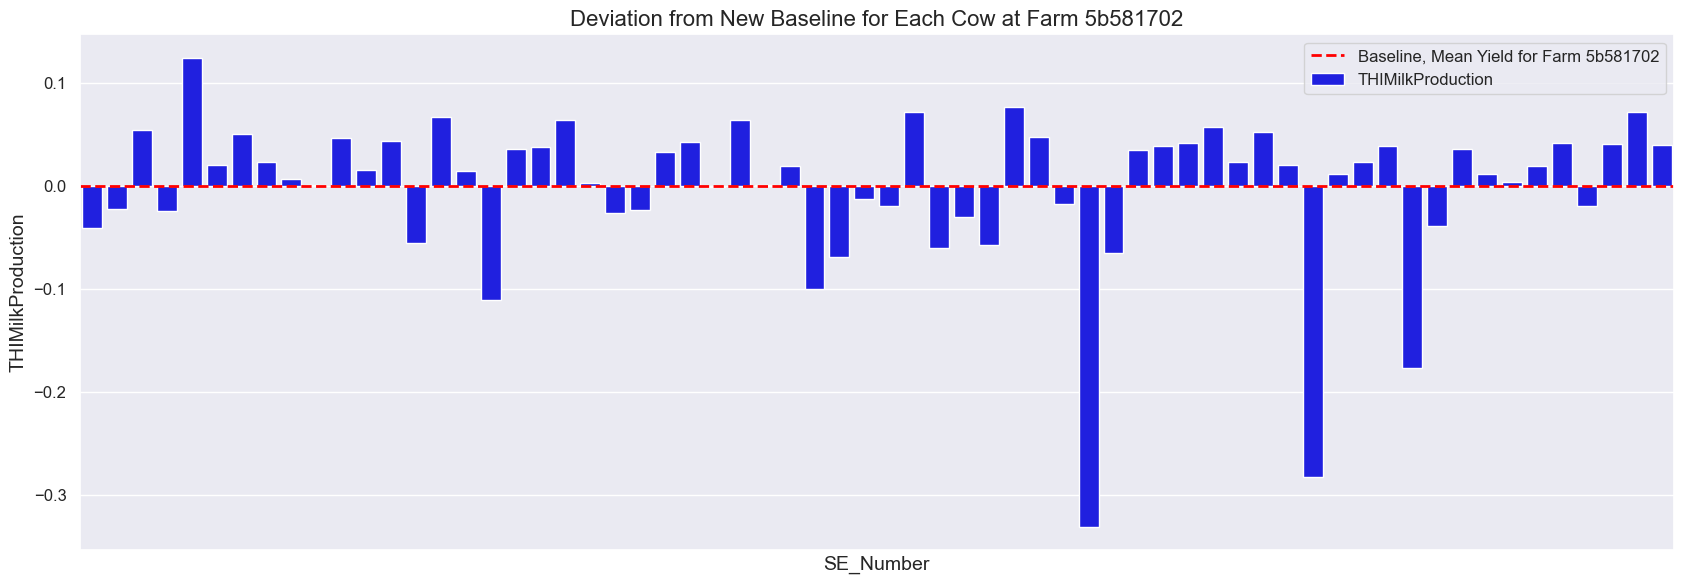

In [40]:
# New baseline value
new_baseline = results_df['THIMilkProduction'].mean()

# Adjust the THIMilkProduction to start from the new baseline
results_df['AdjustedTHIMilkProduction'] = results_df['THIMilkProduction'] - new_baseline

# Create the bar plot
plt.figure(figsize=(17, 6))
sns.barplot(x=results_df.index, y=results_df['AdjustedTHIMilkProduction'], color='blue', label='THIMilkProduction')

# Add a baseline line set to 0 (now adjusted to the new baseline)
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')

# Formatting the plot
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('THIMilkProduction', fontsize=14)
plt.title(f'Deviation from New Baseline for Each Cow at Farm {farm_id}', fontsize=16)

# Optionally, remove x-axis labels if too many entries
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.legend(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

# Farm ad0a39f5

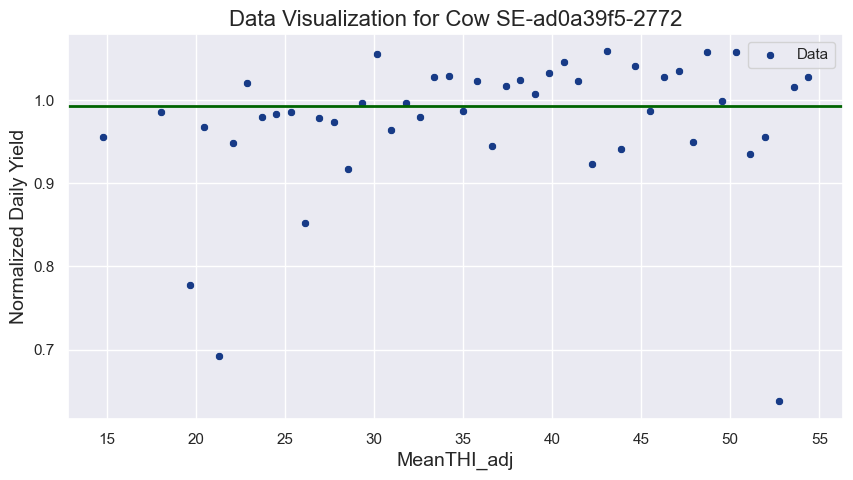

In [41]:
# Filter data for the specific farm
farm_id = 'ad0a39f5'
farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm_id]

# Get unique cows (SE_Number) in the farm
unique_cows = farm_data['SE_Number'].unique()

# Select a random cow for plotting (you can set seed for reproducibility)
np.random.seed(42)  # For reproducibility
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Data Preparation
    N = 50  # Number of bins
    input_feature_label = 'MeanTHI_adj'
    
    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N) 
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Calculate mean_yield for this cow
    mean_yield = cow_data['NormalizedDailyYield'].mean()

    # Initial Visualization (for a random cow only)
    if se_number == random_cow:
        fig = plt.figure(figsize=(10, 5))
        ax = plt.subplot(111)
        scatter = sns.scatterplot(x=x, y=y, label='Data', color='#183B87', ax=ax)

        # Add horizontal line for the mean yield
        mean_yield = cow_data['NormalizedDailyYield'].mean()
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')
        
        plt.title(f"Data Visualization for Cow {se_number}", fontsize=16)
        plt.xlabel('MeanTHI_adj', fontsize=14)
        plt.ylabel('Normalized Daily Yield', fontsize=14)
        plt.show()

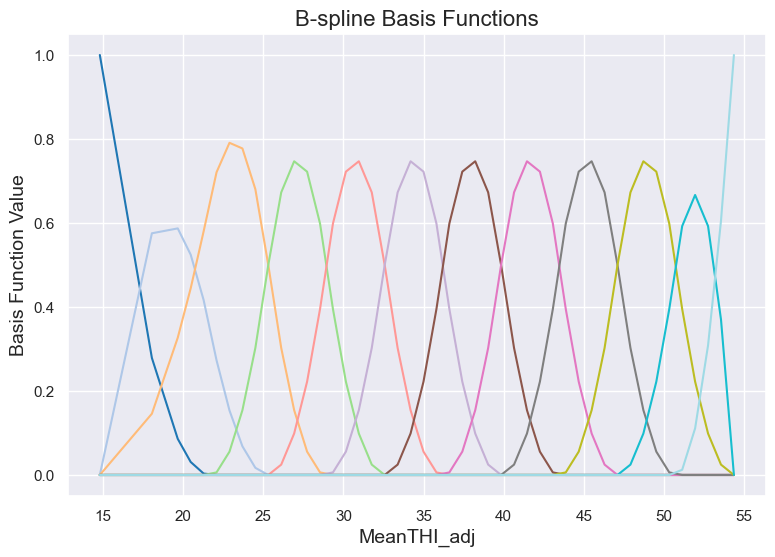

In [42]:
def Phi(a, knots, degree=3, spline_type='B'):
    lower_bound = min(a)
    upper_bound = max(a)
    
    # Adjust knots to ensure they are within the bounds
    knots = np.clip(knots, lower_bound, upper_bound)
    
    if spline_type == 'B':
        B = dmatrix(f"bs(x, knots=knots, degree={degree}, include_intercept=True) - 1", {"x": a, 'knots': knots})
    elif spline_type == 'CR':
        B = dmatrix(f"cr(x, knots=knots, constraints='center')- 1", {"x": a, 'knots': knots})
    elif spline_type == 'CC':
        B = dmatrix(f"cc(x, knots=knots, constraints='center') - 1", {"x": a, 'knots': knots})
    else:
        raise ValueError(f"{spline_type} is not a valid type, choose from 'B', 'CC' or 'CR'")
    return B


for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]
    
    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N) 
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Block 2: B-Spline Basis Functions
    degree_spline = 2  # Change the order of the polynomial here
    num_qs = 10
    knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs+1)[1:-1])

    B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

    # Plot Basis Functions (for the random cow)
    if se_number == random_cow:
        color_map = plt.colormaps.get_cmap('tab20')
        colors = color_map(np.linspace(0, 1, B.shape[1]))

        fig = plt.figure(figsize=(9, 6))
        ax = plt.subplot(111)
        for i in range(B.shape[1]):
            c = colors[i]
            ax.plot(x, B[:, i], c=c, label=f'Basis {i + 1}')

        plt.title('B-spline Basis Functions', fontsize=16)
        plt.xlabel('MeanTHI_adj', fontsize=14)
        plt.ylabel('Basis Function Value', fontsize=14)
        plt.show()

Mean squared error for Cow SE-ad0a39f5-2772 is 0.0047


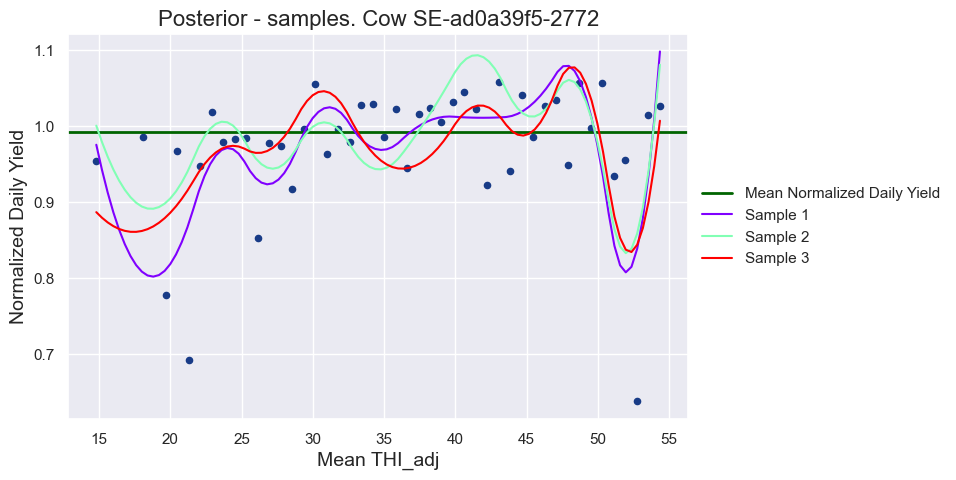

In [43]:
# Seed for reproducibility
np.random.seed(42)

# Select a random cow for plotting
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N)
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Check if there are enough data points
    if len(y) < 2:  # If fewer than 2 data points, skip this cow
        print(f"Skipping Cow {se_number} due to insufficient data points.")
        continue

    # Block 2: B-Spline Basis Functions
    degree_spline = 2  # Change the order of the polynomial here
    num_qs = 10
    knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs + 1)[1:-1])

    B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

    # Block 3: Bayesian Linear Regression - GAM
    # Calculate empirical priors from the data
    D = B.shape[1]
    m0 = np.linalg.lstsq(B, y, rcond=None)[0]  # Least-squares estimate as prior mean
    S0 = np.cov(B.T)  # Covariance of the design matrix as prior covariance

    if np.any(np.isnan(S0)) or np.any(np.isinf(S0)):
        print(f"Skipping Cow {se_number} due to invalid covariance matrix.")
        continue

    beta = 1 / np.var(y)

    if np.isinf(beta) or np.isnan(beta):
        print(f"Skipping Cow {se_number} due to invalid beta value.")
        continue

    # Compute the posterior distribution with new priors
    SN = pinv(pinv(S0) + beta * B.T @ B)

    # Adding a small regularization term to ensure positive semi-definiteness
    regularization_term = 1e-6 * np.eye(D)
    SN += regularization_term

    mN = SN @ (pinv(S0) @ m0 + beta * B.T @ y)

    # Print MSE for this cow
    mse = np.mean((y - B @ mN) ** 2)

    # Plot the posterior for the random cow
    if se_number == random_cow:
        print(f"Mean squared error for Cow {se_number} is {mse:.4f}")
        samples = 3
        seed = 100
        ws = multivariate_normal(mean=mN, cov=SN, allow_singular=True).rvs(samples, random_state=seed)

        n = 100  # number of grid-points
        xs = np.linspace(x.min(), x.max(), n)
        new_data = {'x': xs}

        B_star = build_design_matrices([B.design_info], new_data)[0]
        B_star = np.asarray(B_star)

        # Compute corresponding values f(x*)
        fs = B_star @ ws.T

        # Plot the samples
        fig = plt.figure(figsize=(10, 5))
        ax = plt.subplot(111)
        plt.scatter(x, y, color='#183B87', zorder=1, s=20)

        # Add horizontal line for the mean yield
        mean_yield = cow_data['NormalizedDailyYield'].mean()
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')

        color = cycle(cm.rainbow(np.linspace(0, 1, samples)))
        for i in range(ws.shape[0]):
            c = next(color)
            line, = ax.plot(xs, fs[:, i], c=c, label=f"Sample {i+1}")

        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0)  # Set legend transparency

        plt.title(f'Posterior - samples. Cow {se_number}', fontsize=16)
        plt.xlabel(re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label), fontsize=14)
        plt.ylabel('Normalized Daily Yield', fontsize=14)  # Updated ylabel

        plt.show()

In [44]:
# Seed for reproducibility
np.random.seed(42)

# Initialize an empty DataFrame to store results
results_df = pd.DataFrame(columns=['FarmName_Pseudo', 'SE_Number', 'THIMilkProduction [%]'])

# Select a random cow for plotting
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N)
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Convert bin_midpoints to numeric for comparison
    x = mean_yields[input_feature_label].values.astype(float)
    y = mean_yields.NormalizedDailyYield.values

    # Ensure sufficient data points
    if len(y) < 2:  # Ensure at least 2 data points
        print(f"Skipping Cow {se_number} due to insufficient data points.")
        continue

    try:
        # B-Spline Basis Functions (Primary Method)
        degree_spline = 2  # Change the order of the polynomial here
        max_knots = min(len(y) - 1, 10)
        num_qs = max_knots
        knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs + 1)[1:-1])
        B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

        # Check if B has more rows than columns
        if B.shape[0] < B.shape[1]:
            raise ValueError(f"Incompatible dimensions (B: {B.shape})")

        # Step 1: Calculate empirical priors from the correct data
        m0 = np.linalg.lstsq(B, y, rcond=None)[0]  # Least-squares estimate as prior mean
        S0 = np.cov(B.T)  # Covariance of the design matrix as prior covariance

        if np.any(np.isnan(S0)) or np.any(np.isinf(S0)):
            print(f"Skipping Cow {se_number} due to invalid covariance matrix.")
            continue

        # Bayesian Linear Regression
        beta = 1 / np.var(y)
        lambda_ridge = 0.1
        SN = np.linalg.pinv(np.linalg.pinv(S0) + beta * B.T @ B + lambda_ridge * np.eye(B.shape[1]))
        mN = SN @ (np.linalg.pinv(S0) @ m0 + beta * B.T @ y)

        # Make predictions
        mstar_mle = B @ mN
        Sstar_mle = B @ SN @ B.T + beta ** (-1) * np.eye(B.shape[0])
        stdpred_mle = np.sqrt(np.diag(Sstar_mle))
        model_type = 'B-spline'

    except Exception as e:
        print(f"Skipping Cow {se_number} due to incompatible dimensions or another error: {str(e)}")
        continue

    # Filter x and corresponding mstar_mle for values >= 61
    filtered_indices = x >= 61  # Only include THI values >= 61
    if np.sum(filtered_indices) < 2:
        print(f"Skipping Cow {se_number} due to insufficient data points after filtering.")
        continue

    filtered_xs = x[filtered_indices]
    filtered_mstar_mle = mstar_mle[filtered_indices]

    # Integration to calculate THIMilkProduction
    above_mean = np.maximum(filtered_mstar_mle - mean_yield, 0)
    below_mean = np.maximum(mean_yield - filtered_mstar_mle, 0)

    # Integrate over the filtered x values
    area_above_mean = simpson(above_mean, x=filtered_xs)
    area_below_mean = simpson(below_mean, x=filtered_xs)

    # Calculate the net area (above - below)
    net_area = area_above_mean - area_below_mean
    range_mean_temperature = filtered_xs[-1] - filtered_xs[0]
    net_effect_per_unit = net_area / range_mean_temperature

    # Express the net effect as a percentage of the mean yield
    net_effect_percentage = (net_effect_per_unit / mean_yield) * 100

    # Store results in the DataFrame
    new_result = pd.DataFrame([{
        'FarmName_Pseudo': farm_id,
        'SE_Number': se_number,
        'THIMilkProduction [%]': net_effect_percentage
    }])

    if results_df.empty:
        results_df = new_result
    else:
        results_df = pd.concat([results_df, new_result], ignore_index=True)

    # Plot for the randomly selected cow
    if se_number == random_cow:
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(x, mstar_mle, 'black', label=f'{model_type} Mean')
        ax.fill_between(x, mstar_mle + 3*stdpred_mle, mstar_mle - 3*stdpred_mle, color='lightgray', alpha=0.7, label=r'$\mu \pm 3\sigma$')
        ax.fill_between(x, mstar_mle + 2*stdpred_mle, mstar_mle - 2*stdpred_mle, color='darkgray', alpha=0.7, label=r'$\mu \pm 2\sigma$')
        ax.fill_between(x, mstar_mle + 1*stdpred_mle, mstar_mle - 1*stdpred_mle, color='gray', alpha=0.7, label=r'$\mu \pm 1\sigma$')
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')
        plt.scatter(x, y, c='#183B87', zorder=4, alpha=0.5)
        ax.legend(loc='best')
        plt.title(f'{model_type} for Cow {se_number}')
        plt.xlabel(f'{input_feature_label}')
        plt.ylabel('Normalized Daily Yield')
        plt.show()

# Display the results
results_df['THIMilkProduction'] = results_df['THIMilkProduction [%]'] / 100
results_df

Skipping Cow SE-a756bc39-1048 due to insufficient data points after filtering.
Skipping Cow SE-a756bc39-1204 due to insufficient data points after filtering.
Skipping Cow SE-a756bc39-1217 due to insufficient data points after filtering.
Skipping Cow SE-a756bc39-1218 due to insufficient data points after filtering.
Skipping Cow SE-a756bc39-1258 due to insufficient data points after filtering.
Skipping Cow SE-a756bc39-1269 due to insufficient data points after filtering.
Skipping Cow SE-ad0a39f5-2140 due to insufficient data points after filtering.
Skipping Cow SE-ad0a39f5-2305 due to insufficient data points after filtering.
Skipping Cow SE-ad0a39f5-2435 due to insufficient data points after filtering.
Skipping Cow SE-ad0a39f5-2464 due to insufficient data points after filtering.
Skipping Cow SE-ad0a39f5-2474 due to insufficient data points after filtering.
Skipping Cow SE-ad0a39f5-2479 due to insufficient data points after filtering.
Skipping Cow SE-ad0a39f5-2488 due to insufficient da

FarmName_Pseudo         SE_Number  THIMilkProduction [%]  \
0          ad0a39f5  SE-a756bc39-0943              -5.391640   
1          ad0a39f5  SE-a756bc39-0994               2.975340   
2          ad0a39f5  SE-a756bc39-1026             -10.232134   
3          ad0a39f5  SE-a756bc39-1030               3.659849   
4          ad0a39f5  SE-a756bc39-1141               2.444824   
..              ...               ...                    ...   
156        ad0a39f5  SE-ad0a39f5-2721               1.347408   
157        ad0a39f5  SE-ad0a39f5-2728              -1.540333   
158        ad0a39f5  SE-ad0a39f5-2730             -11.534489   
159        ad0a39f5  SE-ad0a39f5-2746              -8.684950   
160        ad0a39f5  SE-ad0a39f5-2756              -4.141704   

     THIMilkProduction  
0            -0.053916  
1             0.029753  
2            -0.102321  
3             0.036598  
4             0.024448  
..                 ...  
156           0.013474  
157          -0.015403  
158          -0.115345  
159          -0.086849  
160          -0.041417  

[161 rows x 4 columns]

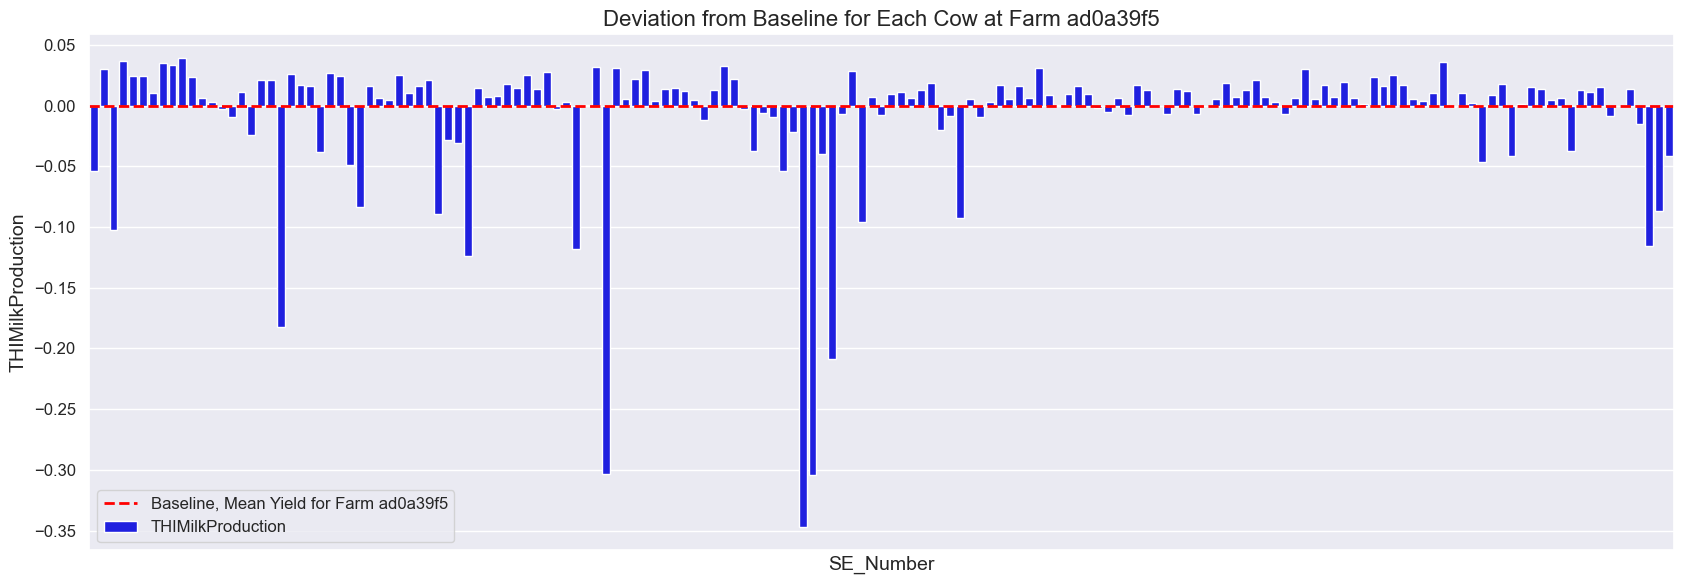

In [45]:
# Create the bar plot
plt.figure(figsize=(17, 6))
sns.barplot(x=results_df.index, y=results_df['THIMilkProduction'], color='blue', label='THIMilkProduction')

# Add a baseline line set to 0
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')

# Formatting the plot
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('THIMilkProduction', fontsize=14)
plt.title(f'Deviation from Baseline for Each Cow at Farm {farm_id}', fontsize=16)

# Optionally, remove x-axis labels if too many entries
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.legend(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

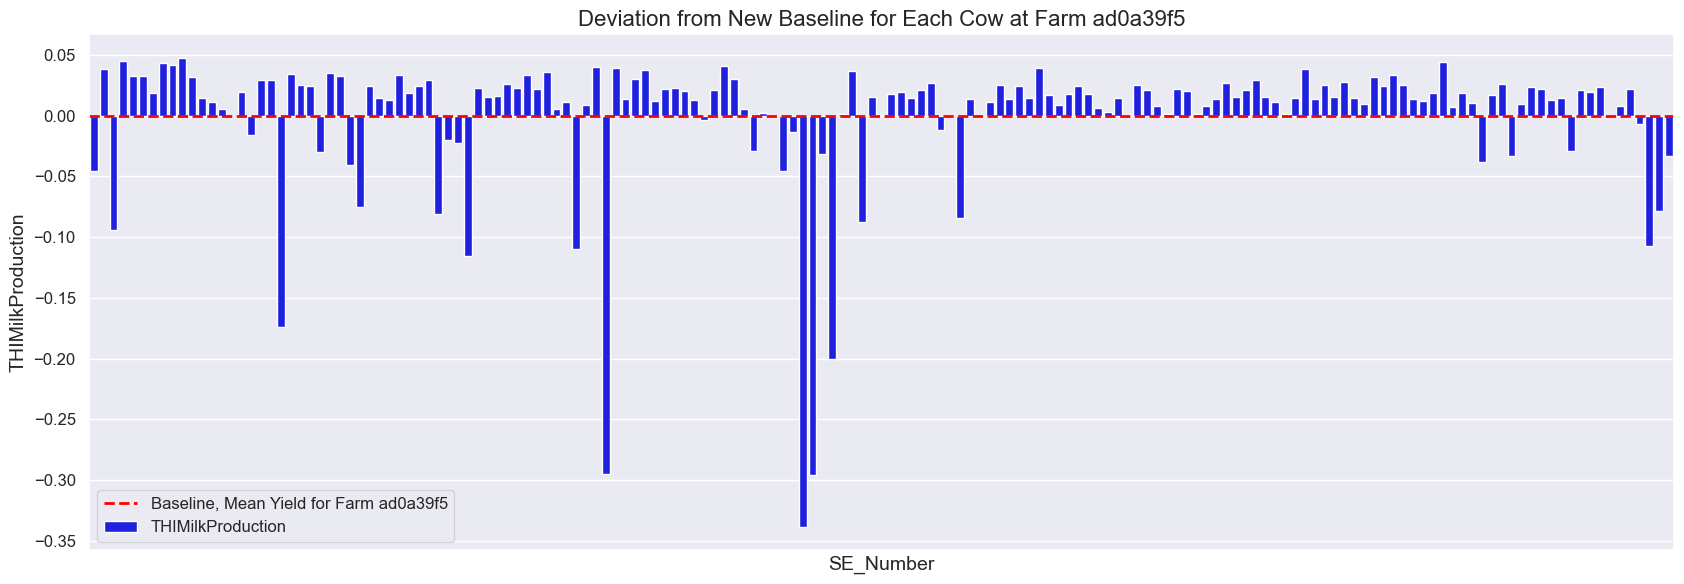

In [46]:
# New baseline value
new_baseline = results_df['THIMilkProduction'].mean()

# Adjust the THIMilkProduction to start from the new baseline
results_df['AdjustedTHIMilkProduction'] = results_df['THIMilkProduction'] - new_baseline

# Create the bar plot
plt.figure(figsize=(17, 6))
sns.barplot(x=results_df.index, y=results_df['AdjustedTHIMilkProduction'], color='blue', label='THIMilkProduction')

# Add a baseline line set to 0 (now adjusted to the new baseline)
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')

# Formatting the plot
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('THIMilkProduction', fontsize=14)
plt.title(f'Deviation from New Baseline for Each Cow at Farm {farm_id}', fontsize=16)

# Optionally, remove x-axis labels if too many entries
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.legend(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

In [47]:
results_df

FarmName_Pseudo         SE_Number  THIMilkProduction [%]  \
0          ad0a39f5  SE-a756bc39-0943              -5.391640   
1          ad0a39f5  SE-a756bc39-0994               2.975340   
2          ad0a39f5  SE-a756bc39-1026             -10.232134   
3          ad0a39f5  SE-a756bc39-1030               3.659849   
4          ad0a39f5  SE-a756bc39-1141               2.444824   
..              ...               ...                    ...   
156        ad0a39f5  SE-ad0a39f5-2721               1.347408   
157        ad0a39f5  SE-ad0a39f5-2728              -1.540333   
158        ad0a39f5  SE-ad0a39f5-2730             -11.534489   
159        ad0a39f5  SE-ad0a39f5-2746              -8.684950   
160        ad0a39f5  SE-ad0a39f5-2756              -4.141704   

     THIMilkProduction  AdjustedTHIMilkProduction  
0            -0.053916                  -0.045569  
1             0.029753                   0.038101  
2            -0.102321                  -0.093974  
3             0.036598                   0.044946  
4             0.024448                   0.032796  
..                 ...                        ...  
156           0.013474                   0.021822  
157          -0.015403                  -0.007056  
158          -0.115345                  -0.106997  
159          -0.086849                  -0.078502  
160          -0.041417                  -0.033070  

[161 rows x 5 columns]

# Plotting THI Milk Production

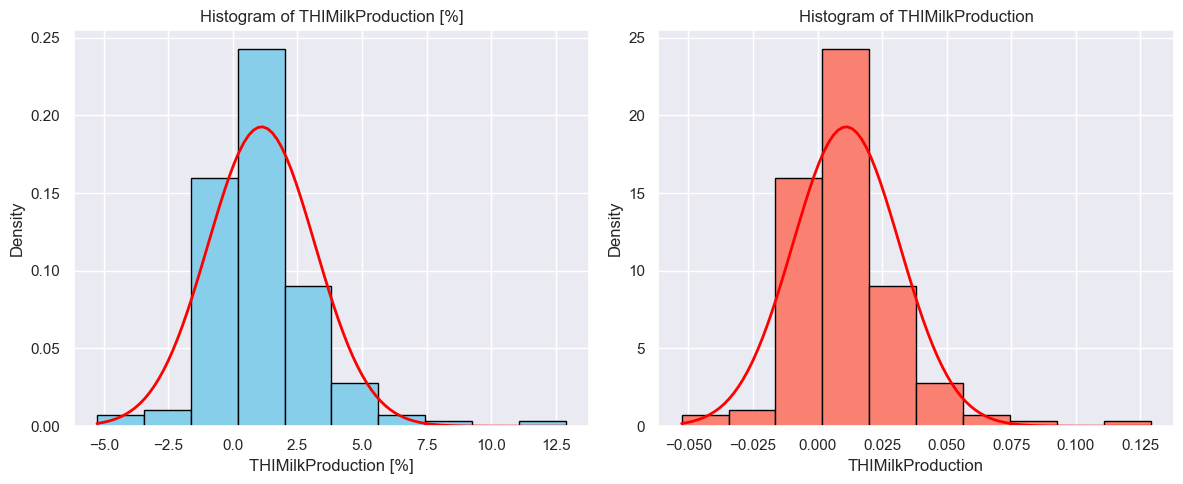

In [34]:
df = pd.DataFrame(results_df)

# Ensure SE_Number is a string type for better plotting labels
df['SE_Number'] = df['SE_Number'].astype(str)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Histogram for THIMilkProduction [%]
ax[0].hist(df['THIMilkProduction [%]'], bins=10, color='skyblue', edgecolor='black', density=True)
ax[0].set_title('Histogram of THIMilkProduction [%]')
ax[0].set_xlabel('THIMilkProduction [%]')
ax[0].set_ylabel('Density')

# Calculate mean and std deviation for THIMilkProduction [%]
mean_thi = np.mean(df['THIMilkProduction [%]'])
std_thi = np.std(df['THIMilkProduction [%]'])

# Generate points for the normal distribution curve
x_thi = np.linspace(min(df['THIMilkProduction [%]']), max(df['THIMilkProduction [%]']), 100)
y_thi = norm.pdf(x_thi, mean_thi, std_thi)

# Plot normal distribution curve on the histogram
ax[0].plot(x_thi, y_thi, color='red', linewidth=2)

# Histogram for THIMilkProduction
ax[1].hist(df['THIMilkProduction'], bins=10, color='salmon', edgecolor='black', density=True)
ax[1].set_title('Histogram of THIMilkProduction')
ax[1].set_xlabel('THIMilkProduction')
ax[1].set_ylabel('Density')

# Calculate mean and std deviation for THIMilkProduction
mean_milk = np.mean(df['THIMilkProduction'])
std_milk = np.std(df['THIMilkProduction'])

# Generate points for the normal distribution curve
x_milk = np.linspace(min(df['THIMilkProduction']), max(df['THIMilkProduction']), 100)
y_milk = norm.pdf(x_milk, mean_milk, std_milk)

# Plot normal distribution curve on the histogram
ax[1].plot(x_milk, y_milk, color='red', linewidth=2)

# Adjust layout
plt.tight_layout()
plt.show()

# GRAPH DAILY AND EXPECTED MY WITH THI

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [42]:
# Ladda in data
df = pd.read_csv('../Data/MergedData/HeatApproachCleanedYieldDataTest.csv', low_memory=False)
col_keep = ["Date", "FarmName_Pseudo", "SE_Number", "LactationNumber", "ExpectedYield", "DailyYield", "MeanTHI_adj", "HeatStress"]
df = df[col_keep]

# Sort values by Date for proper plotting
df = df.sort_values(by=["FarmName_Pseudo", 'Date'])

heat_stressed_cows = df[df['HeatStress'] == 1]
heat_stressed_cows.to_csv("../Data/MergedData/heatstressedcows.csv")

In [39]:
SE_Number = ["SE-5c06d92d-3205"] # ["SE-5c06d92d-3199"] # ["SE-5c06d92d-3194"] # ["SE-5c06d92d-3189"] # ["SE-5c06d92d-3187"]  # ["SE-5c06d92d-3196"]
df = df[df["SE_Number"].isin(SE_Number)]

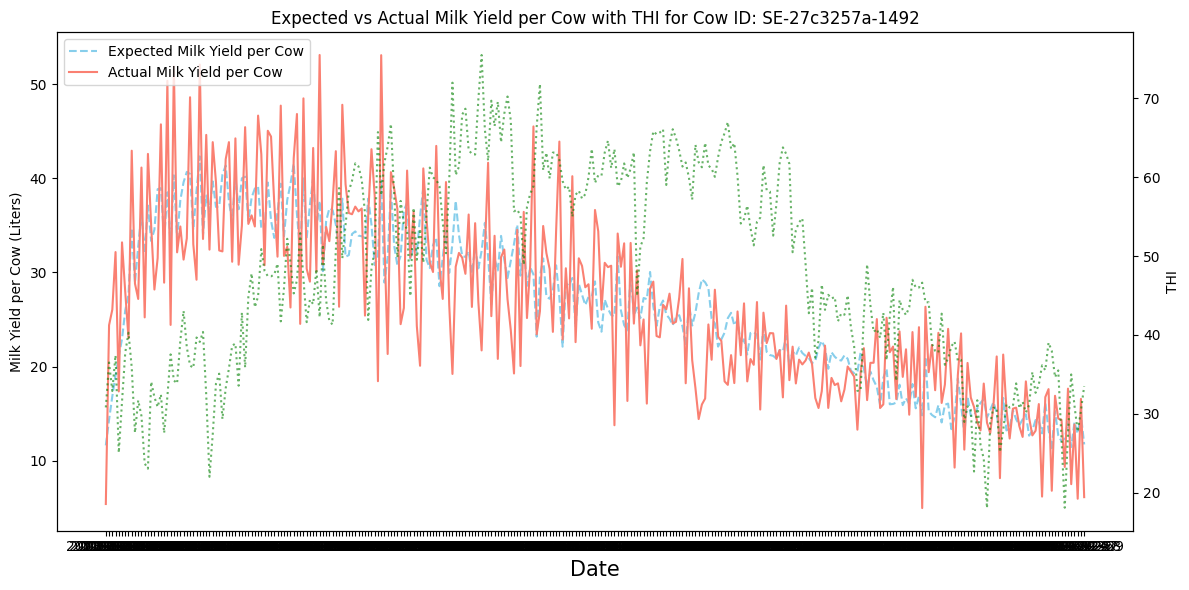

In [116]:
# Set up a figure for the specific cow
fig, ax1 = plt.subplots(figsize=(12, 6))

# Primary y-axis for Expected and Actual Milk Yield per Cow
ax1.plot(cow_data['Date'], cow_data['ExpectedYield'], 
         label='Expected Milk Yield per Cow', color='skyblue', linestyle='--')
ax1.plot(cow_data['Date'], cow_data['DailyYield'], 
         label='Actual Milk Yield per Cow', color='salmon', linestyle='-', markersize=1)

# Set labels and title for the cow's plot
ax1.set_ylabel('Milk Yield per Cow (Liters)')
ax1.set_title(f'Expected vs Actual Milk Yield per Cow with THI for Cow ID: SE-27c3257a-1492')
ax1.legend(loc='upper left')

# Secondary y-axis for THI
ax2 = ax1.twinx()
ax2.plot(cow_data['Date'], cow_data['MeanTHI_adj'], 
         label='THI', color='green', linestyle=':', alpha=0.6)
ax2.set_ylabel('THI')

# Set x-axis label
ax1.set_xlabel('Date', fontsize=15)

# Adjust layout for clarity
plt.tight_layout()
plt.show()

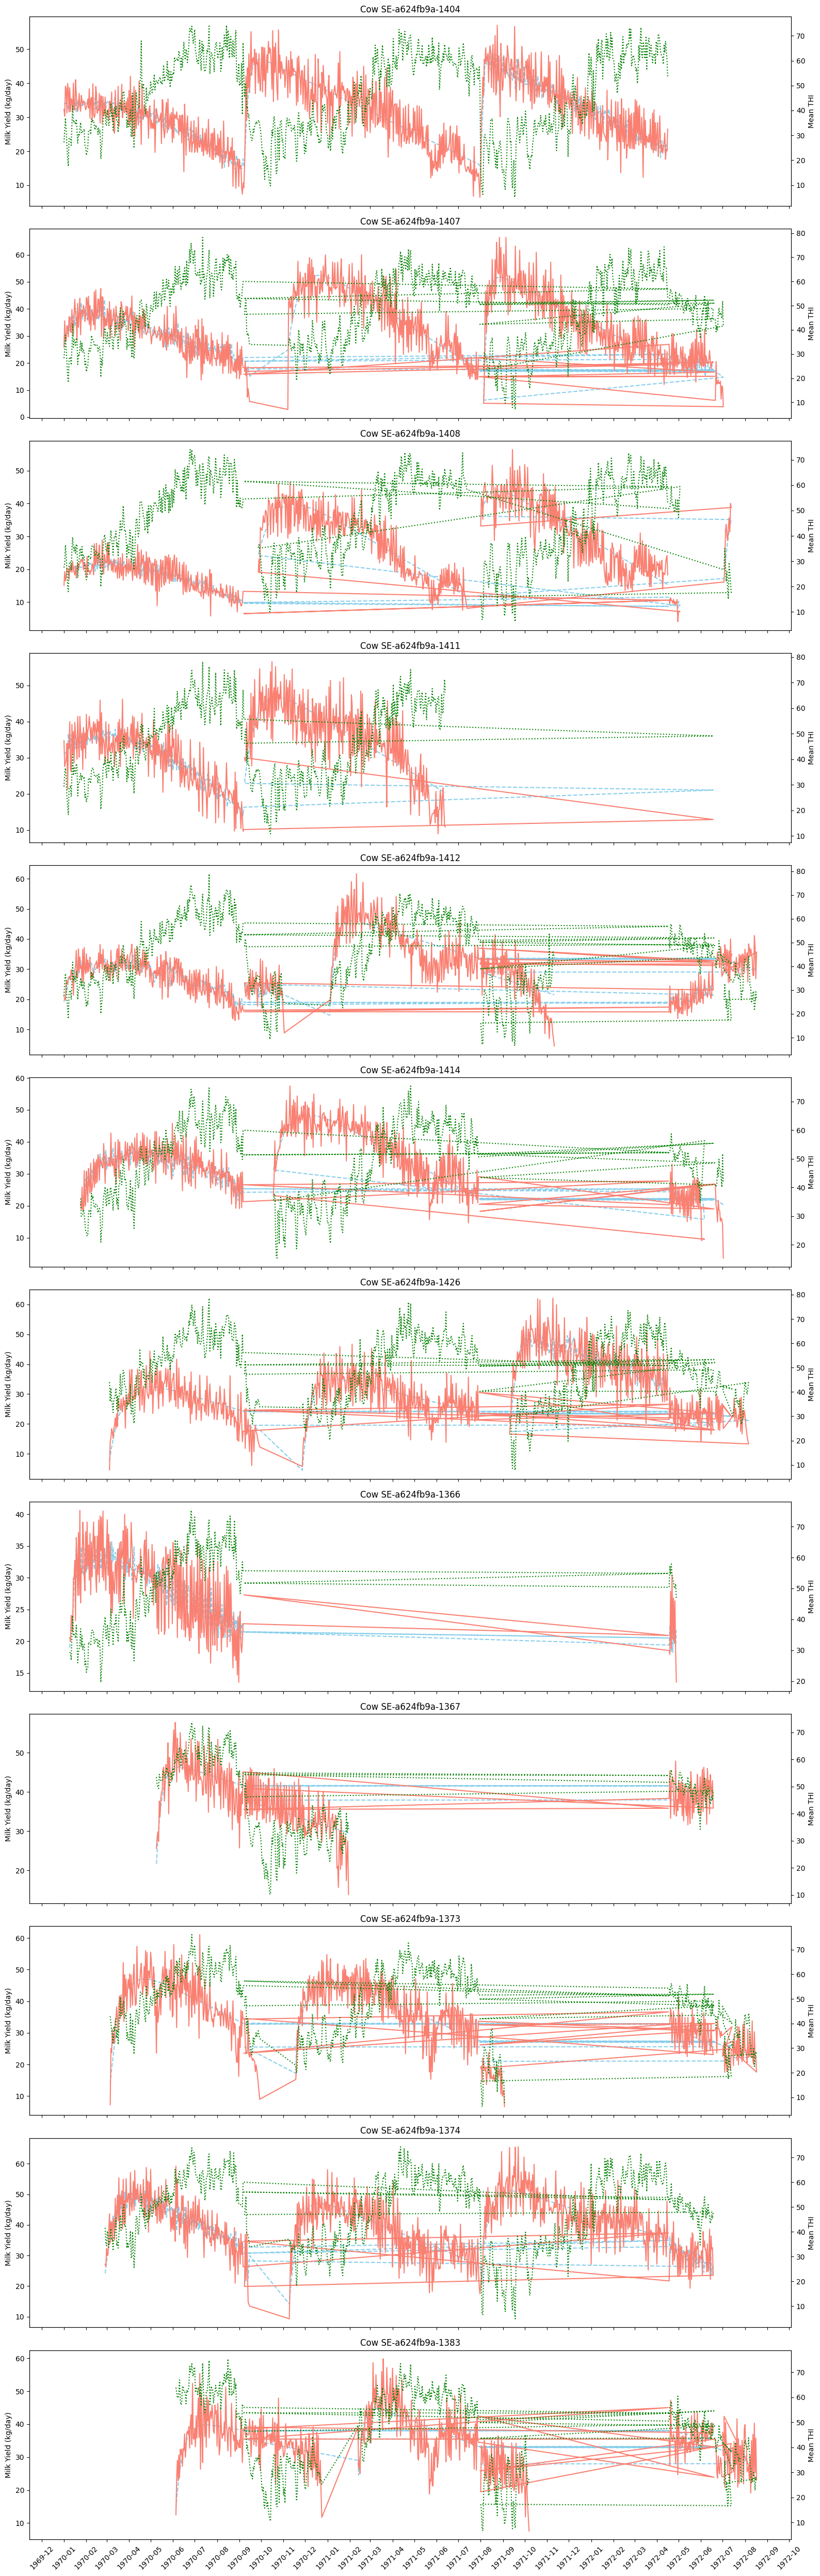

In [126]:
# List of SE_Numbers for 15 cows
"""
SE_Numbers = [
    "SE-5c06d92d-3165", "SE-5c06d92d-3183", "SE-5c06d92d-3186", "SE-5c06d92d-3187",
    "SE-5c06d92d-3189", "SE-5c06d92d-3194", "SE-5c06d92d-3196", "SE-5c06d92d-3199",
    "SE-5c06d92d-3207", "SE-5c06d92d-3200", "SE-5c06d92d-3204", "SE-5c06d92d-3205",
    "SE-5c06d92d-3210", "SE-5c06d92d-3215", "SE-5c06d92d-3216"
]

SE_Numbers = [
    "SE-a66dc90e-1614", "SE-27c3257a-1492", "SE-5b581702-2104", "SE-5b581702-2012",
    "SE-5b581702-2101", "SE-5b581702-2103", "SE-5b581702-2127", "SE-7b463eec-1624",
    "SE-b4326b5d-1016", "SE-5b581702-2104", "SE-a66dc90e-1614", "SE-6d38bc90-2592",
]
"""

SE_Numbers = [
    "SE-a624fb9a-1404", "SE-a624fb9a-1407", "SE-a624fb9a-1408", "SE-a624fb9a-1411",
    "SE-a624fb9a-1412", "SE-a624fb9a-1414", "SE-a624fb9a-1426", "SE-a624fb9a-1366",
    "SE-a624fb9a-1367", "SE-a624fb9a-1373", "SE-a624fb9a-1374", "SE-a624fb9a-1383",
]

# Filter data for cows in the list
cow_data = df[df["SE_Number"].isin(SE_Numbers)]

cow_data = cow_data.sort_values(by='Date')

# Set up the grid for subplots (3 rows by 5 columns for 15 cows)
fig, axes = plt.subplots(12, 1, figsize=(16, 50), sharex=True, sharey=False)
axes = axes.flatten()  # Flatten the axes array for easier iteration

# Loop through each cow and plot their data in separate subplots
for i, se_number in enumerate(SE_Numbers):
    cow_df = cow_data[cow_data["SE_Number"] == se_number]  # Filter data for the specific cow
    
    # Plot the Milk Yield for each cow
    ax1 = axes[i]  # Select the subplot
    ax1.plot(cow_df['Date'], cow_df['ExpectedYield'], label='Expected Milk Yield', color='skyblue', linestyle='--')
    ax1.plot(cow_df['Date'], cow_df['DailyYield'], label='Actual Milk Yield', color='salmon', linestyle='-')

    ax1.set_title(f'Cow {se_number}', fontsize=12)
    ax1.set_ylabel('Milk Yield (kg/day)', fontsize=10)
    ax1.tick_params(axis='x', rotation=45)
    
    # Create a second y-axis for Mean THI
    ax2 = ax1.twinx()
    ax2.plot(cow_df['Date'], cow_df['MeanTHI_adj'], label='THI', color='green', linestyle=':')
    ax2.set_ylabel('Mean THI', fontsize=10)
    
    # Formatting the x-axis dates
    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Adjust layout for clarity
fig.tight_layout()
plt.show()

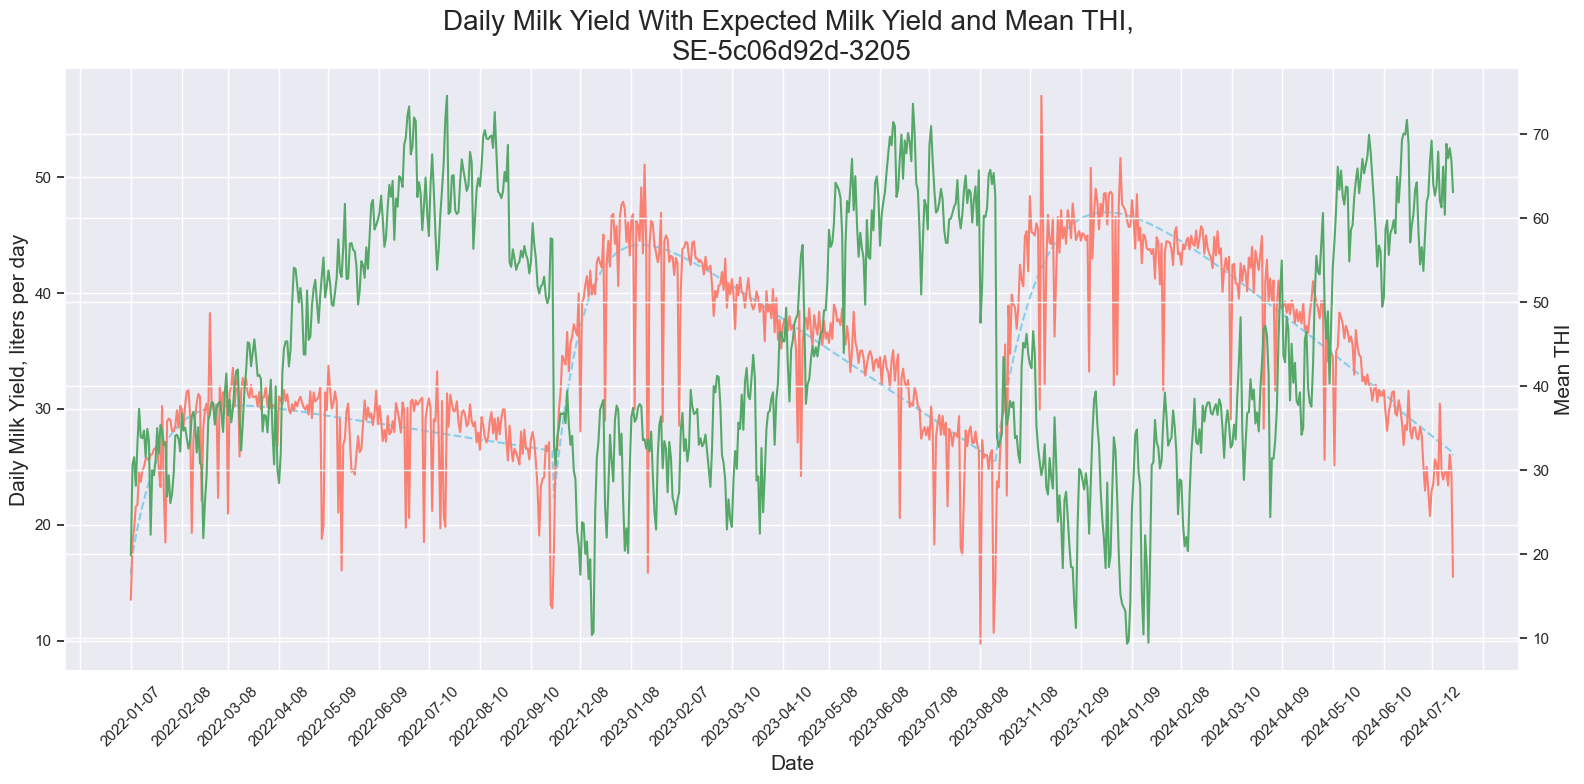

In [40]:
#MY x MEANTHI

cow_data=df.copy()
cow_data = cow_data.sort_values(by='Date')

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(16, 8))

# Plot the first y-axis (Milk Yield)
ax1.plot(cow_data['Date'], cow_data['ExpectedYield'], 
         label='Expected Milk Yield per Cow', color='skyblue', linestyle='--')
ax1.plot(cow_data['Date'], cow_data['DailyYield'], 
         label='Actual Milk Yield per Cow', color='salmon', linestyle='-', markersize=1)

ax1.set_xlabel('Date', fontsize=15)
ax1.set_ylabel('Daily Milk Yield, liters per day', fontsize=15)
ax1.tick_params(axis='y')
plt.xticks(rotation=45)
plt.title('Daily Milk Yield With Expected Milk Yield and Mean THI, \nSE-5c06d92d-3205', fontsize=20)
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx() # instantiate a second Axes that shares the same x-axis
ax2.plot(cow_data['Date'], cow_data['MeanTHI_adj'], color='g')
ax2.set_ylabel('Mean THI', fontsize=15)
ax2.tick_params(axis='y')

# Adjust layout to prevent overlap
fig.tight_layout()
plt.show()

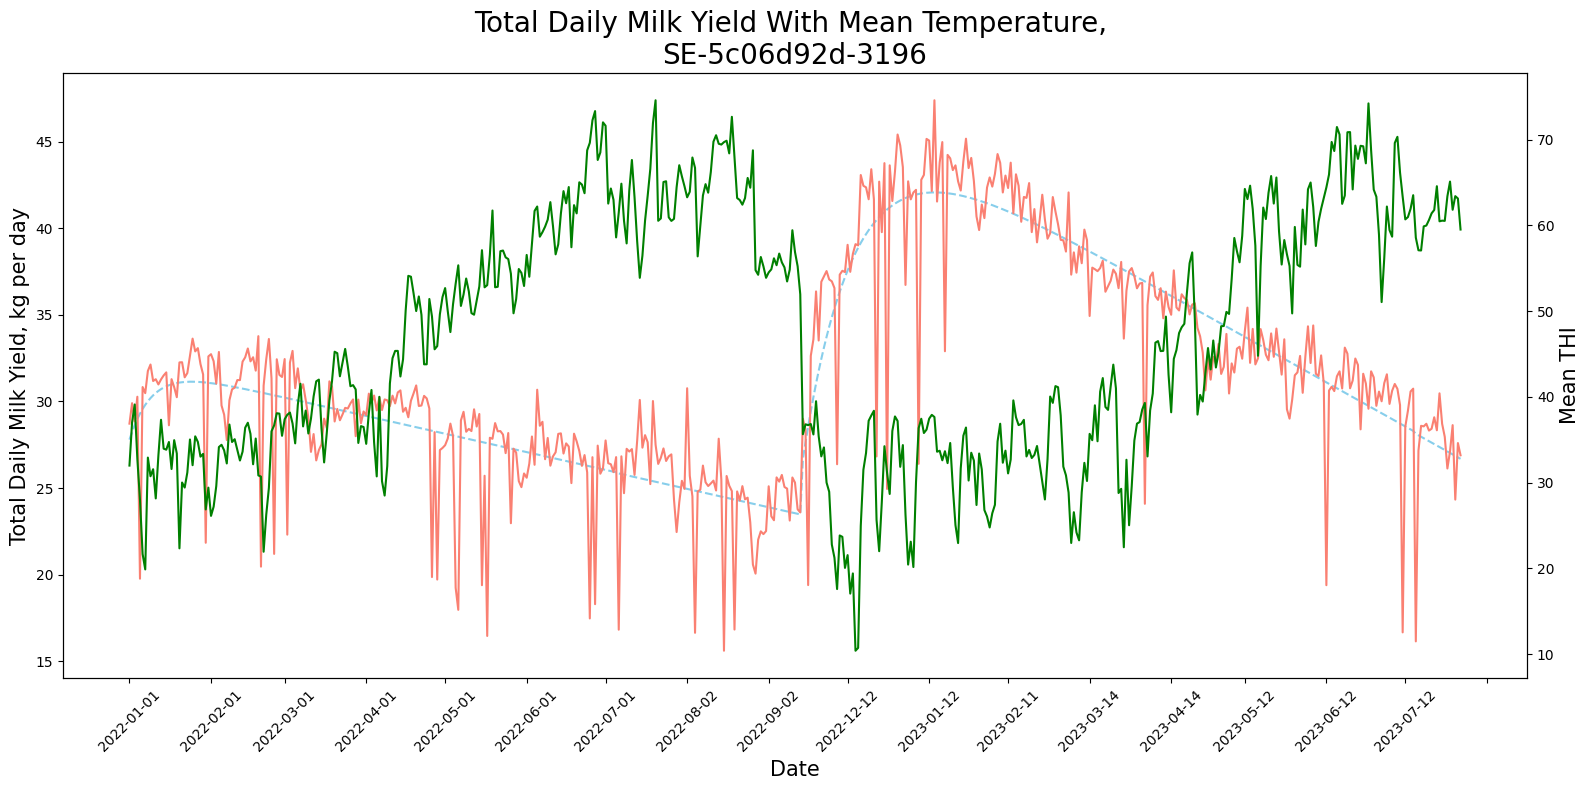

In [212]:
#MY x MEANTEMP
cow_data=df.copy()
#dates = pd.date_range(start='2022-01-01', end='2023-11-13', periods=30)

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(16, 8))

# Plot the first y-axis (Milk Yield)
ax1.plot(cow_data['Date'], cow_data['ExpectedYield'], 
         label='Expected Milk Yield per Cow', color='skyblue', linestyle='--')
ax1.plot(cow_data['Date'], cow_data['DailyYield'], 
         label='Actual Milk Yield per Cow', color='salmon', linestyle='-', markersize=1)

ax1.set_xlabel('Date', fontsize=15)
ax1.set_ylabel('Total Daily Milk Yield, kg per day', fontsize=15)
ax1.tick_params(axis='y')
plt.xticks(rotation=45)
plt.title('Total Daily Milk Yield With Mean Temperature, \nSE-5c06d92d-3196', fontsize=20)
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx() # instantiate a second Axes that shares the same x-axis
ax2.plot(cow_data['Date'], cow_data['MeanTHI_adj'], color='g')
ax2.set_ylabel('Mean THI', fontsize=15)
ax2.tick_params(axis='y')

# Adjust layout to prevent overlap
fig.tight_layout()
plt.show()

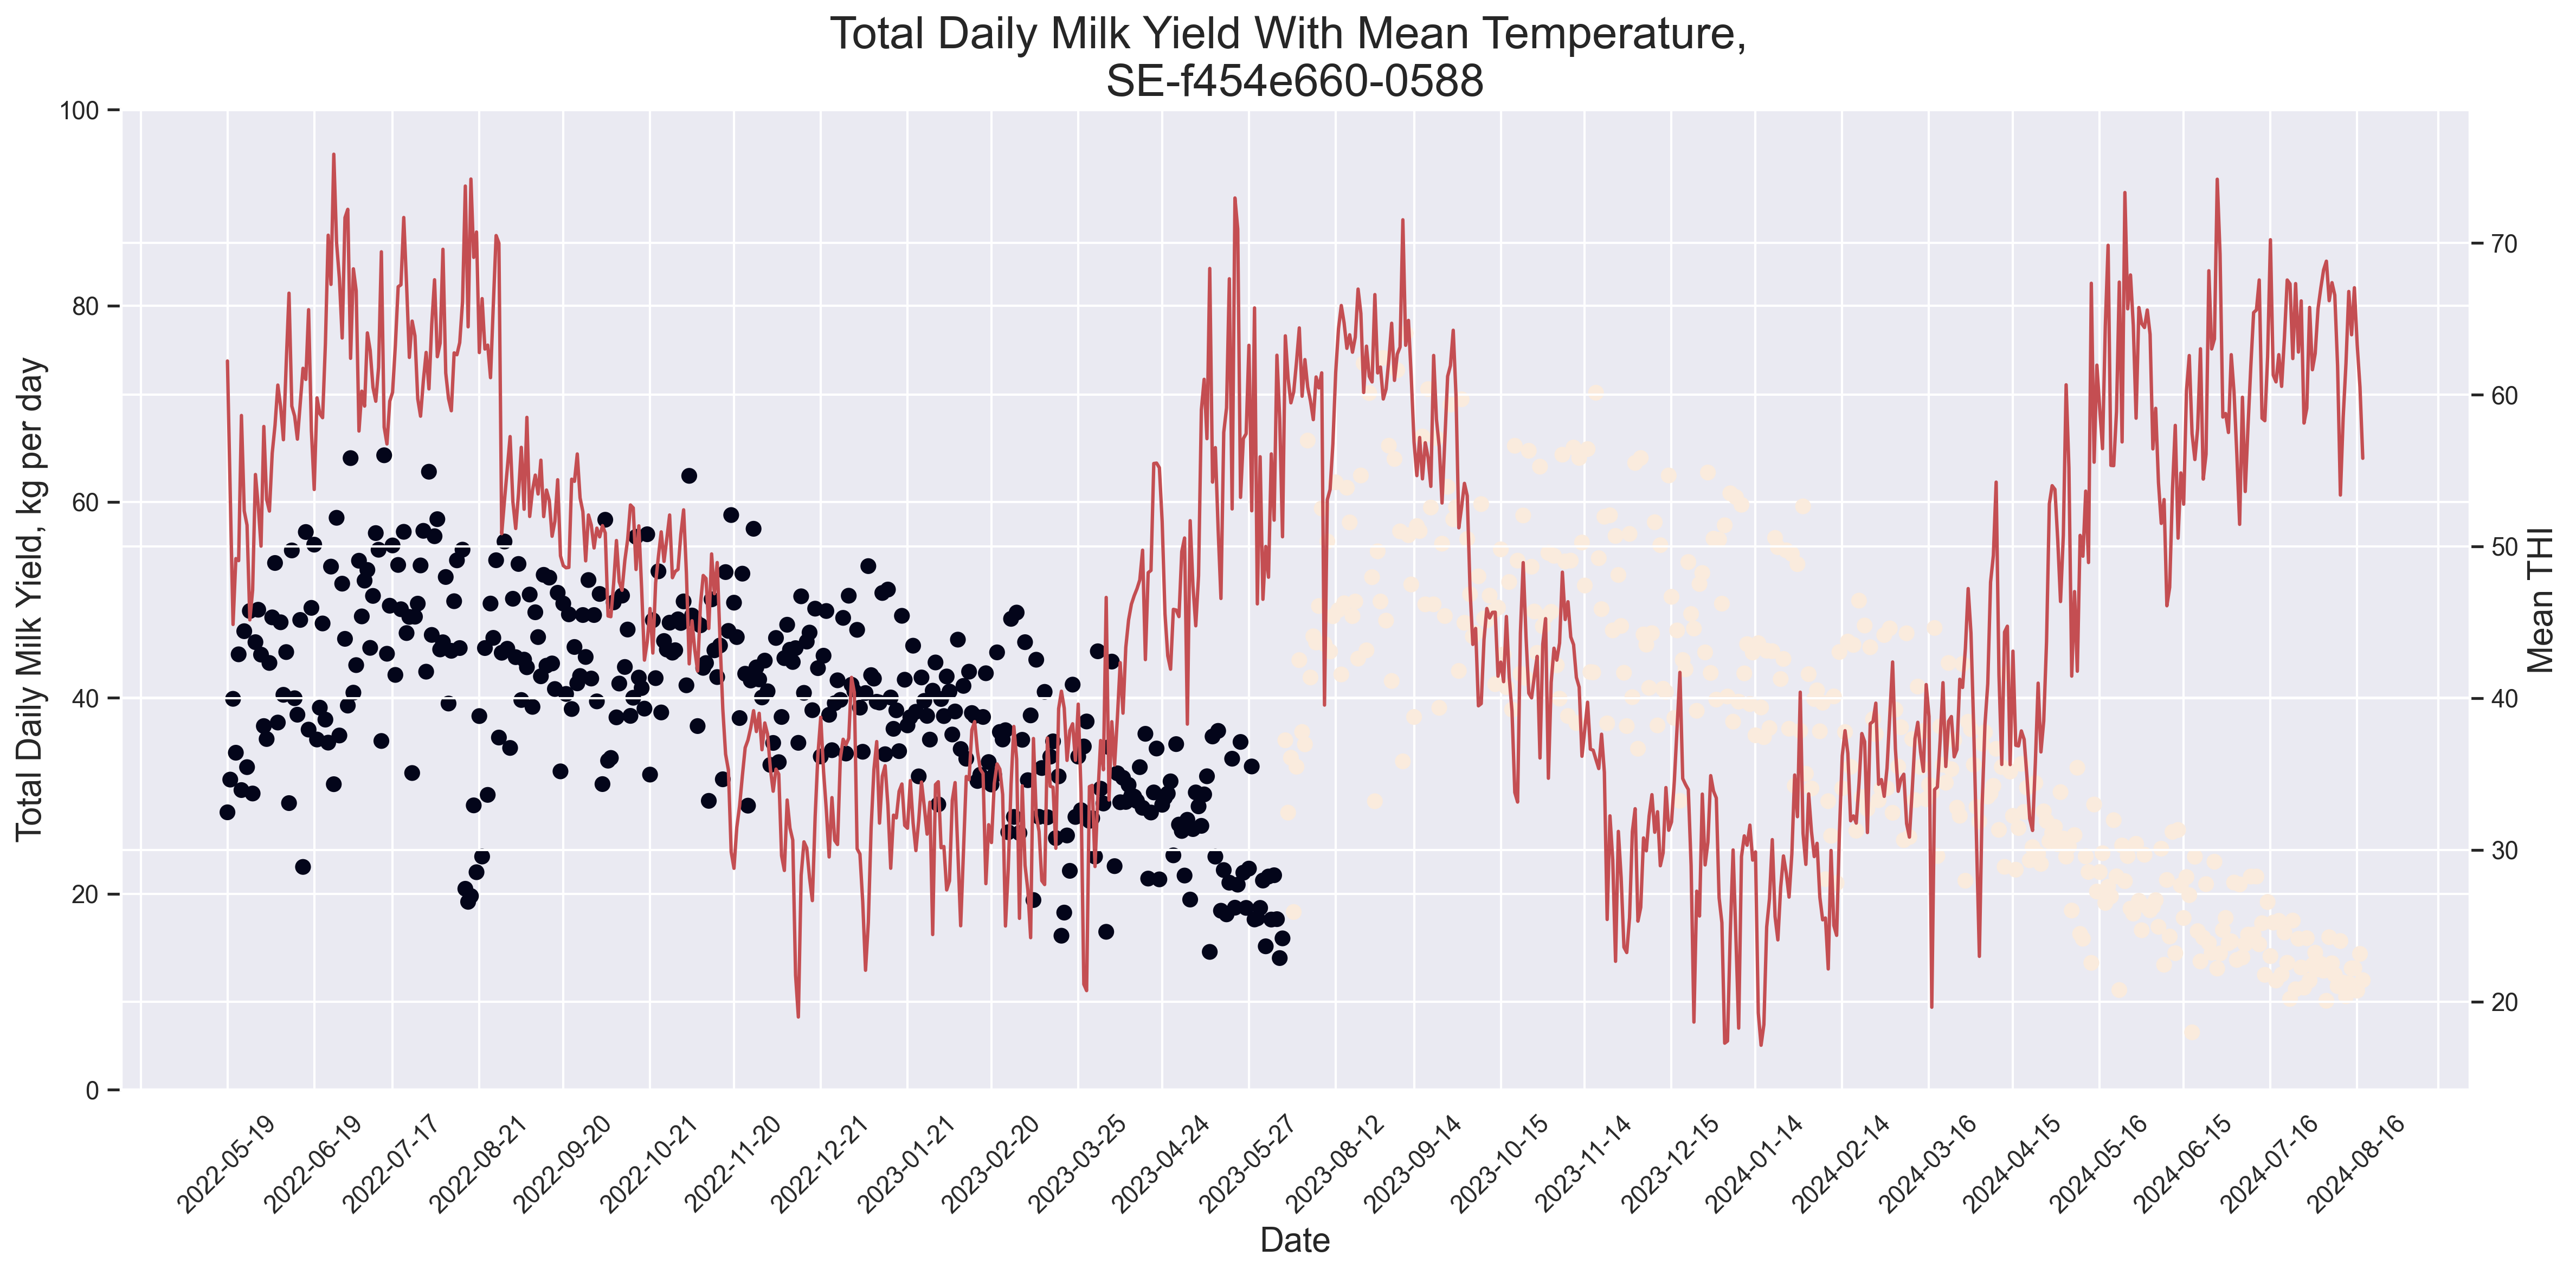

In [43]:
#PLOT MY x MEANTEMP


#SUBSET CHOSEN COW(S)
SE_Number = ["SE-f454e660-0588"] 
df = df[df["SE_Number"].isin(SE_Number)]

#dates = pd.date_range(start='2022-01-01', end='2023-11-13', periods=30)

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(16, 8), dpi=300)

# Plot the first y-axis (Milk Yield)
ax1.scatter(df['Date'], df['DailyYield'], c=df['LactationNumber'])
ax1.set_xlabel('Date', fontsize=15)
ax1.set_ylabel('Total Daily Milk Yield, kg per day', fontsize=15)
ax1.tick_params(axis='y')
ax1.set_ylim(0,100)
plt.xticks(rotation=45)
plt.title('Total Daily Milk Yield With Mean Temperature, \nSE-f454e660-0588', fontsize=20)
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx() # instantiate a second Axes that shares the same x-axis
ax2.plot(df['Date'], df['MeanTHI_adj'], color='r')
ax2.set_ylabel('Mean THI', fontsize=15)
ax2.tick_params(axis='y')

# Adjust layout to prevent overlap
fig.tight_layout()
plt.show()

# Hur stor del av korna minskar i mjölkavkastning, då hela besättningen faller under en period med värmestress?

# Farm a624fb9a

In [59]:
# Ladda in data
# Exempeldata: En DataFrame 'milk_data' med kolumner ['Date', 'SE_Number', 'FarmName_Pseudo', 'DailyYield', 'THI_adj']
df = pd.read_csv('../Data/MergedData/HeatApproachCleanedYieldDataTest.csv', low_memory=False)
col_keep = ["Date", "FarmName_Pseudo", "SE_Number", "DailyYield", "MeanTHI_adj"]
milk_data = df[col_keep]

In [60]:
# 1. Filtrera data för en viss besättning
farm_id = 'a624fb9a'
farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm_id]

# 2. Definiera THI-tröskelvärde för värmestress (t.ex. THI över 61 anses som värmestress)
thi_threshold = 61

# 3. Identifiera perioder med värmestress
farm_data = farm_data.copy()
farm_data['HeatStress'] = farm_data['MeanTHI_adj'] > thi_threshold

# 4. Beräkna medelavkastning före värmestressperioden (för varje ko)
# Antag att vi jämför mot en period utan värmestress precis före (t.ex. 7 dagar före värmestress börjar)
pre_stress_period = 7  # dagar
farm_data['Date'] = pd.to_datetime(farm_data['Date'])

# För varje ko, hitta den senaste perioden utan värmestress (om du har en sådan period)
non_stress_data = farm_data[~farm_data['HeatStress']]

# Beräkna medelavkastning för varje ko innan värmestressperioden
avg_yield_pre_stress = non_stress_data.groupby('SE_Number').apply(lambda x: x.sort_values('Date').tail(pre_stress_period)['DailyYield'].mean())

# 5. Beräkna medelavkastning under värmestressperioden
stress_data = farm_data[farm_data['HeatStress']]

# Medelavkastning för varje ko under värmestressperioden
avg_yield_during_stress = stress_data.groupby('SE_Number')['DailyYield'].mean()

# 6. Beräkna förändring i mjölkavkastning under värmestress för varje ko
yield_change = avg_yield_during_stress - avg_yield_pre_stress

# 7. Räkna andelen kor med minskad avkastning
total_cows = len(yield_change)
decreased_yield_count = (yield_change < 0).sum()
percentage_decreased = (decreased_yield_count / total_cows) * 100

print(f"Andel kor med minskad mjölkavkastning under värmestress: {percentage_decreased:.2f}%")

Andel kor med minskad mjölkavkastning under värmestress: 33.33%


C:\Users\pagd0001\AppData\Local\Temp\ipykernel_12888\2025266259.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_yield_pre_stress = non_stress_data.groupby('SE_Number').apply(lambda x: x.sort_values('Date').tail(pre_stress_period)['DailyYield'].mean())


# Farm 5c06d92d

In [61]:
# 1. Filtrera data för en viss besättning
farm_id = '5c06d92d'
farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm_id]

# 2. Definiera THI-tröskelvärde för värmestress (t.ex. THI över 61 anses som värmestress)
thi_threshold = 61

# 3. Identifiera perioder med värmestress
farm_data = farm_data.copy()
farm_data['HeatStress'] = farm_data['MeanTHI_adj'] > thi_threshold

# 4. Beräkna medelavkastning före värmestressperioden (för varje ko)
# Antag att vi jämför mot en period utan värmestress precis före (t.ex. 7 dagar före värmestress börjar)
pre_stress_period = 7  # dagar
farm_data['Date'] = pd.to_datetime(farm_data['Date'])

# För varje ko, hitta den senaste perioden utan värmestress (om du har en sådan period)
non_stress_data = farm_data[~farm_data['HeatStress']]

# Beräkna medelavkastning för varje ko innan värmestressperioden
avg_yield_pre_stress = non_stress_data.groupby('SE_Number').apply(lambda x: x.sort_values('Date').tail(pre_stress_period)['DailyYield'].mean())

# 5. Beräkna medelavkastning under värmestressperioden
stress_data = farm_data[farm_data['HeatStress']]

# Medelavkastning för varje ko under värmestressperioden
avg_yield_during_stress = stress_data.groupby('SE_Number')['DailyYield'].mean()

# 6. Beräkna förändring i mjölkavkastning under värmestress för varje ko
yield_change = avg_yield_during_stress - avg_yield_pre_stress

# 7. Räkna andelen kor med minskad avkastning
total_cows = len(yield_change)
decreased_yield_count = (yield_change < 0).sum()
percentage_decreased = (decreased_yield_count / total_cows) * 100

print(f"Andel kor med minskad mjölkavkastning under värmestress: {percentage_decreased:.2f}%")

Andel kor med minskad mjölkavkastning under värmestress: 18.70%


C:\Users\pagd0001\AppData\Local\Temp\ipykernel_12888\1254407236.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_yield_pre_stress = non_stress_data.groupby('SE_Number').apply(lambda x: x.sort_values('Date').tail(pre_stress_period)['DailyYield'].mean())


# Farm f454e660

In [62]:
# 1. Filtrera data för en viss besättning
farm_id = 'f454e660'
farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm_id]

# 2. Definiera THI-tröskelvärde för värmestress (t.ex. THI över 61 anses som värmestress)
thi_threshold = 61

# 3. Identifiera perioder med värmestress
farm_data = farm_data.copy()
farm_data['HeatStress'] = farm_data['MeanTHI_adj'] > thi_threshold

# 4. Beräkna medelavkastning före värmestressperioden (för varje ko)
# Antag att vi jämför mot en period utan värmestress precis före (t.ex. 7 dagar före värmestress börjar)
pre_stress_period = 7  # dagar
farm_data['Date'] = pd.to_datetime(farm_data['Date'])

# För varje ko, hitta den senaste perioden utan värmestress (om du har en sådan period)
non_stress_data = farm_data[~farm_data['HeatStress']]

# Beräkna medelavkastning för varje ko innan värmestressperioden
avg_yield_pre_stress = non_stress_data.groupby('SE_Number').apply(lambda x: x.sort_values('Date').tail(pre_stress_period)['DailyYield'].mean())

# 5. Beräkna medelavkastning under värmestressperioden
stress_data = farm_data[farm_data['HeatStress']]

# Medelavkastning för varje ko under värmestressperioden
avg_yield_during_stress = stress_data.groupby('SE_Number')['DailyYield'].mean()

# 6. Beräkna förändring i mjölkavkastning under värmestress för varje ko
yield_change = avg_yield_during_stress - avg_yield_pre_stress

# 7. Räkna andelen kor med minskad avkastning
total_cows = len(yield_change)
decreased_yield_count = (yield_change < 0).sum()
percentage_decreased = (decreased_yield_count / total_cows) * 100

print(f"Andel kor med minskad mjölkavkastning under värmestress: {percentage_decreased:.2f}%")

Andel kor med minskad mjölkavkastning under värmestress: 12.77%


C:\Users\pagd0001\AppData\Local\Temp\ipykernel_12888\779078501.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_yield_pre_stress = non_stress_data.groupby('SE_Number').apply(lambda x: x.sort_values('Date').tail(pre_stress_period)['DailyYield'].mean())


# Farm 5b581702

In [63]:
# 1. Filtrera data för en viss besättning
farm_id = '5b581702'
farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm_id]

# 2. Definiera THI-tröskelvärde för värmestress (t.ex. THI över 61 anses som värmestress)
thi_threshold = 61

# 3. Identifiera perioder med värmestress
farm_data = farm_data.copy()
farm_data['HeatStress'] = farm_data['MeanTHI_adj'] > thi_threshold

# 4. Beräkna medelavkastning före värmestressperioden (för varje ko)
# Antag att vi jämför mot en period utan värmestress precis före (t.ex. 7 dagar före värmestress börjar)
pre_stress_period = 7  # dagar
farm_data['Date'] = pd.to_datetime(farm_data['Date'])

# För varje ko, hitta den senaste perioden utan värmestress (om du har en sådan period)
non_stress_data = farm_data[~farm_data['HeatStress']]

# Beräkna medelavkastning för varje ko innan värmestressperioden
avg_yield_pre_stress = non_stress_data.groupby('SE_Number').apply(lambda x: x.sort_values('Date').tail(pre_stress_period)['DailyYield'].mean())

# 5. Beräkna medelavkastning under värmestressperioden
stress_data = farm_data[farm_data['HeatStress']]

# Medelavkastning för varje ko under värmestressperioden
avg_yield_during_stress = stress_data.groupby('SE_Number')['DailyYield'].mean()

# 6. Beräkna förändring i mjölkavkastning under värmestress för varje ko
yield_change = avg_yield_during_stress - avg_yield_pre_stress

# 7. Räkna andelen kor med minskad avkastning
total_cows = len(yield_change)
decreased_yield_count = (yield_change < 0).sum()
percentage_decreased = (decreased_yield_count / total_cows) * 100

print(f"Andel kor med minskad mjölkavkastning under värmestress: {percentage_decreased:.2f}%")

Andel kor med minskad mjölkavkastning under värmestress: 33.87%


C:\Users\pagd0001\AppData\Local\Temp\ipykernel_12888\2080675350.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_yield_pre_stress = non_stress_data.groupby('SE_Number').apply(lambda x: x.sort_values('Date').tail(pre_stress_period)['DailyYield'].mean())


# Farm ad0a39f5

In [64]:
# 1. Filtrera data för en viss besättning
farm_id = 'ad0a39f5'
farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm_id]

# 2. Definiera THI-tröskelvärde för värmestress (t.ex. THI över 61 anses som värmestress)
thi_threshold = 61

# 3. Identifiera perioder med värmestress
farm_data = farm_data.copy()
farm_data['HeatStress'] = farm_data['MeanTHI_adj'] > thi_threshold

# 4. Beräkna medelavkastning före värmestressperioden (för varje ko)
# Antag att vi jämför mot en period utan värmestress precis före (t.ex. 7 dagar före värmestress börjar)
pre_stress_period = 7  # dagar
farm_data['Date'] = pd.to_datetime(farm_data['Date'])

# För varje ko, hitta den senaste perioden utan värmestress (om du har en sådan period)
non_stress_data = farm_data[~farm_data['HeatStress']]

# Beräkna medelavkastning för varje ko innan värmestressperioden
avg_yield_pre_stress = non_stress_data.groupby('SE_Number').apply(lambda x: x.sort_values('Date').tail(pre_stress_period)['DailyYield'].mean())

# 5. Beräkna medelavkastning under värmestressperioden
stress_data = farm_data[farm_data['HeatStress']]

# Medelavkastning för varje ko under värmestressperioden
avg_yield_during_stress = stress_data.groupby('SE_Number')['DailyYield'].mean()

# 6. Beräkna förändring i mjölkavkastning under värmestress för varje ko
yield_change = avg_yield_during_stress - avg_yield_pre_stress

# 7. Räkna andelen kor med minskad avkastning
total_cows = len(yield_change)
decreased_yield_count = (yield_change < 0).sum()
percentage_decreased = (decreased_yield_count / total_cows) * 100

print(f"Andel kor med minskad mjölkavkastning under värmestress: {percentage_decreased:.2f}%")

Andel kor med minskad mjölkavkastning under värmestress: 10.19%


C:\Users\pagd0001\AppData\Local\Temp\ipykernel_12888\561525955.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_yield_pre_stress = non_stress_data.groupby('SE_Number').apply(lambda x: x.sort_values('Date').tail(pre_stress_period)['DailyYield'].mean())
